## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


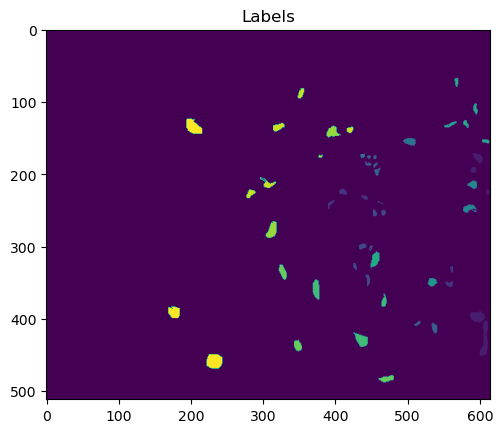

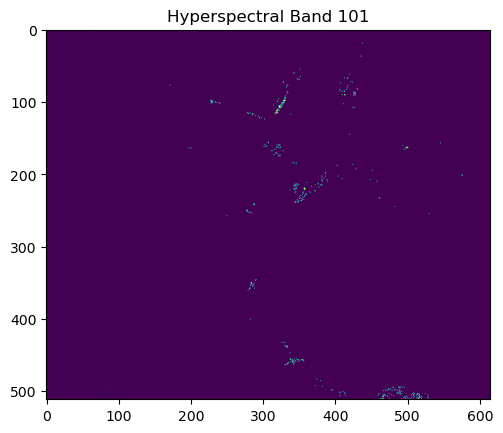

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(520, 5, 5, 176)
(65, 5, 5, 176)
(4626, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2504, PSNR: 6.0140


Epoch [1/50] Training Loss: 0.2394, PSNR: 6.2106
	[Val]   Batch [1/17] Loss: 0.2249, PSNR: 6.4805
	[Val]   Batch [10/17] Loss: 0.2253, PSNR: 6.4716
Epoch [1/50] Validation Loss: 0.2251, PSNR: 6.4759

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2191, PSNR: 6.5936


Epoch [2/50] Training Loss: 0.2029, PSNR: 6.9336
	[Val]   Batch [1/17] Loss: 0.1785, PSNR: 7.4833
	[Val]   Batch [10/17] Loss: 0.1809, PSNR: 7.4264
Epoch [2/50] Validation Loss: 0.1803, PSNR: 7.4390

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1806, PSNR: 7.4317


Epoch [3/50] Training Loss: 0.1662, PSNR: 7.1312
	[Val]   Batch [1/17] Loss: 0.1420, PSNR: 8.4786
	[Val]   Batch [10/17] Loss: 0.1452, PSNR: 8.3810
Epoch [3/50] Validation Loss: 0.1444, PSNR: 8.4046

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1473, PSNR: 8.3192


Epoch [4/50] Training Loss: 0.1341, PSNR: 8.7325
	[Val]   Batch [1/17] Loss: 0.1172, PSNR: 9.3107
	[Val]   Batch [10/17] Loss: 0.1182, PSNR: 9.2743
Epoch [4/50] Validation Loss: 0.1181, PSNR: 9.2766

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1171, PSNR: 9.3148


Epoch [5/50] Training Loss: 0.1071, PSNR: 9.0258
	[Val]   Batch [1/17] Loss: 0.0941, PSNR: 10.2639
	[Val]   Batch [10/17] Loss: 0.0950, PSNR: 10.2227
Epoch [5/50] Validation Loss: 0.0949, PSNR: 10.2258

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0938, PSNR: 10.2795


Epoch [6/50] Training Loss: 0.0857, PSNR: 9.9887
	[Val]   Batch [1/17] Loss: 0.0763, PSNR: 11.1725
	[Val]   Batch [10/17] Loss: 0.0764, PSNR: 11.1711
Epoch [6/50] Validation Loss: 0.0766, PSNR: 11.1577

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0761, PSNR: 11.1877


Epoch [7/50] Training Loss: 0.0693, PSNR: 11.5993
	[Val]   Batch [1/17] Loss: 0.0621, PSNR: 12.0688
	[Val]   Batch [10/17] Loss: 0.0625, PSNR: 12.0402
Epoch [7/50] Validation Loss: 0.0625, PSNR: 12.0390

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0618, PSNR: 12.0931


Epoch [8/50] Training Loss: 0.0568, PSNR: 12.4631
	[Val]   Batch [1/17] Loss: 0.0518, PSNR: 12.8588
	[Val]   Batch [10/17] Loss: 0.0521, PSNR: 12.8311
Epoch [8/50] Validation Loss: 0.0521, PSNR: 12.8294

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0504, PSNR: 12.9719


Epoch [9/50] Training Loss: 0.0472, PSNR: 13.2619
	[Val]   Batch [1/17] Loss: 0.0437, PSNR: 13.5988
	[Val]   Batch [10/17] Loss: 0.0438, PSNR: 13.5813
Epoch [9/50] Validation Loss: 0.0439, PSNR: 13.5799

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0425, PSNR: 13.7149


Epoch [10/50] Training Loss: 0.0400, PSNR: 13.3011
	[Val]   Batch [1/17] Loss: 0.0376, PSNR: 14.2433
	[Val]   Batch [10/17] Loss: 0.0377, PSNR: 14.2363
Epoch [10/50] Validation Loss: 0.0378, PSNR: 14.2273

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0362, PSNR: 14.4090


Epoch [11/50] Training Loss: 0.0343, PSNR: 14.6554
	[Val]   Batch [1/17] Loss: 0.0320, PSNR: 14.9438
	[Val]   Batch [10/17] Loss: 0.0321, PSNR: 14.9327
Epoch [11/50] Validation Loss: 0.0322, PSNR: 14.9245

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0313, PSNR: 15.0496


Epoch [12/50] Training Loss: 0.0297, PSNR: 14.5970
	[Val]   Batch [1/17] Loss: 0.0286, PSNR: 15.4302
	[Val]   Batch [10/17] Loss: 0.0288, PSNR: 15.4046
Epoch [12/50] Validation Loss: 0.0288, PSNR: 15.4014

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0275, PSNR: 15.6138


Epoch [13/50] Training Loss: 0.0261, PSNR: 15.8295
	[Val]   Batch [1/17] Loss: 0.0251, PSNR: 16.0108
	[Val]   Batch [10/17] Loss: 0.0251, PSNR: 16.0001
Epoch [13/50] Validation Loss: 0.0251, PSNR: 15.9952

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0243, PSNR: 16.1408


Epoch [14/50] Training Loss: 0.0231, PSNR: 15.6855
	[Val]   Batch [1/17] Loss: 0.0224, PSNR: 16.4892
	[Val]   Batch [10/17] Loss: 0.0226, PSNR: 16.4664
Epoch [14/50] Validation Loss: 0.0226, PSNR: 16.4657

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0214, PSNR: 16.6950


Epoch [15/50] Training Loss: 0.0207, PSNR: 16.1772
	[Val]   Batch [1/17] Loss: 0.0203, PSNR: 16.9351
	[Val]   Batch [10/17] Loss: 0.0204, PSNR: 16.9143
Epoch [15/50] Validation Loss: 0.0204, PSNR: 16.9106

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0191, PSNR: 17.1854


Epoch [16/50] Training Loss: 0.0186, PSNR: 16.6212
	[Val]   Batch [1/17] Loss: 0.0181, PSNR: 17.4246
	[Val]   Batch [10/17] Loss: 0.0182, PSNR: 17.3920
Epoch [16/50] Validation Loss: 0.0182, PSNR: 17.3908

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0176, PSNR: 17.5403


Epoch [17/50] Training Loss: 0.0168, PSNR: 17.0464
	[Val]   Batch [1/17] Loss: 0.0167, PSNR: 17.7704
	[Val]   Batch [10/17] Loss: 0.0169, PSNR: 17.7299
Epoch [17/50] Validation Loss: 0.0168, PSNR: 17.7354

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0160, PSNR: 17.9622


Epoch [18/50] Training Loss: 0.0153, PSNR: 18.1439
	[Val]   Batch [1/17] Loss: 0.0148, PSNR: 18.2871
	[Val]   Batch [10/17] Loss: 0.0150, PSNR: 18.2485
Epoch [18/50] Validation Loss: 0.0150, PSNR: 18.2537

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0146, PSNR: 18.3572


Epoch [19/50] Training Loss: 0.0140, PSNR: 18.5316
	[Val]   Batch [1/17] Loss: 0.0137, PSNR: 18.6330
	[Val]   Batch [10/17] Loss: 0.0138, PSNR: 18.5937
Epoch [19/50] Validation Loss: 0.0138, PSNR: 18.6004

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0132, PSNR: 18.8041


Epoch [20/50] Training Loss: 0.0129, PSNR: 18.8913
	[Val]   Batch [1/17] Loss: 0.0127, PSNR: 18.9741
	[Val]   Batch [10/17] Loss: 0.0128, PSNR: 18.9157
Epoch [20/50] Validation Loss: 0.0128, PSNR: 18.9301

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0122, PSNR: 19.1204


Epoch [21/50] Training Loss: 0.0119, PSNR: 19.2407
	[Val]   Batch [1/17] Loss: 0.0117, PSNR: 19.3114
	[Val]   Batch [10/17] Loss: 0.0118, PSNR: 19.2734
Epoch [21/50] Validation Loss: 0.0118, PSNR: 19.2832

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0112, PSNR: 19.5144


Epoch [22/50] Training Loss: 0.0110, PSNR: 19.5693
	[Val]   Batch [1/17] Loss: 0.0109, PSNR: 19.6350
	[Val]   Batch [10/17] Loss: 0.0110, PSNR: 19.5705
Epoch [22/50] Validation Loss: 0.0110, PSNR: 19.5879

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0105, PSNR: 19.7999


Epoch [23/50] Training Loss: 0.0103, PSNR: 19.8889
	[Val]   Batch [1/17] Loss: 0.0101, PSNR: 19.9561
	[Val]   Batch [10/17] Loss: 0.0102, PSNR: 19.8928
Epoch [23/50] Validation Loss: 0.0102, PSNR: 19.9100

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0097, PSNR: 20.1150


Epoch [24/50] Training Loss: 0.0096, PSNR: 20.1823
	[Val]   Batch [1/17] Loss: 0.0094, PSNR: 20.2680
	[Val]   Batch [10/17] Loss: 0.0095, PSNR: 20.2033
Epoch [24/50] Validation Loss: 0.0095, PSNR: 20.2174

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0092, PSNR: 20.3851


Epoch [25/50] Training Loss: 0.0090, PSNR: 20.4783
	[Val]   Batch [1/17] Loss: 0.0089, PSNR: 20.5252
	[Val]   Batch [10/17] Loss: 0.0090, PSNR: 20.4585
Epoch [25/50] Validation Loss: 0.0090, PSNR: 20.4736

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0086, PSNR: 20.6562


Epoch [26/50] Training Loss: 0.0084, PSNR: 20.0742
	[Val]   Batch [1/17] Loss: 0.0084, PSNR: 20.7592
	[Val]   Batch [10/17] Loss: 0.0085, PSNR: 20.6910
Epoch [26/50] Validation Loss: 0.0085, PSNR: 20.7056

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0081, PSNR: 20.9327


Epoch [27/50] Training Loss: 0.0079, PSNR: 21.0320
	[Val]   Batch [1/17] Loss: 0.0077, PSNR: 21.1122
	[Val]   Batch [10/17] Loss: 0.0079, PSNR: 21.0351
Epoch [27/50] Validation Loss: 0.0078, PSNR: 21.0527

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0077, PSNR: 21.1167


Epoch [28/50] Training Loss: 0.0074, PSNR: 20.6221
	[Val]   Batch [1/17] Loss: 0.0075, PSNR: 21.2723
	[Val]   Batch [10/17] Loss: 0.0076, PSNR: 21.1894
Epoch [28/50] Validation Loss: 0.0076, PSNR: 21.2118

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0072, PSNR: 21.4220


Epoch [29/50] Training Loss: 0.0070, PSNR: 21.5534
	[Val]   Batch [1/17] Loss: 0.0069, PSNR: 21.5874
	[Val]   Batch [10/17] Loss: 0.0071, PSNR: 21.4999
Epoch [29/50] Validation Loss: 0.0070, PSNR: 21.5256

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0067, PSNR: 21.7489


Epoch [30/50] Training Loss: 0.0066, PSNR: 21.7992
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8469
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7610
Epoch [30/50] Validation Loss: 0.0066, PSNR: 21.7860

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0062, PSNR: 22.0919


Epoch [31/50] Training Loss: 0.0062, PSNR: 22.0434
	[Val]   Batch [1/17] Loss: 0.0062, PSNR: 22.0839
	[Val]   Batch [10/17] Loss: 0.0063, PSNR: 21.9808
Epoch [31/50] Validation Loss: 0.0063, PSNR: 22.0115

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0061, PSNR: 22.1778


Epoch [32/50] Training Loss: 0.0059, PSNR: 22.2856
	[Val]   Batch [1/17] Loss: 0.0058, PSNR: 22.3287
	[Val]   Batch [10/17] Loss: 0.0060, PSNR: 22.2265
Epoch [32/50] Validation Loss: 0.0059, PSNR: 22.2555

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0058, PSNR: 22.3344


Epoch [33/50] Training Loss: 0.0056, PSNR: 22.4924
	[Val]   Batch [1/17] Loss: 0.0055, PSNR: 22.5666
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4547
Epoch [33/50] Validation Loss: 0.0056, PSNR: 22.4854

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0054, PSNR: 22.6374


Epoch [34/50] Training Loss: 0.0054, PSNR: 22.7114
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7642
	[Val]   Batch [10/17] Loss: 0.0054, PSNR: 22.6474
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6793

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0051, PSNR: 22.9087


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.2404
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9247
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8044
Epoch [35/50] Validation Loss: 0.0052, PSNR: 22.8398

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.0638


Epoch [36/50] Training Loss: 0.0049, PSNR: 23.1282
	[Val]   Batch [1/17] Loss: 0.0048, PSNR: 23.1700
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 23.0450
Epoch [36/50] Validation Loss: 0.0049, PSNR: 23.0824

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3585


Epoch [37/50] Training Loss: 0.0047, PSNR: 23.3144
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3700
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.2273
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2738

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0045, PSNR: 23.4748


Epoch [38/50] Training Loss: 0.0044, PSNR: 23.5277
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5301
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.4016
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4411

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6750


Epoch [39/50] Training Loss: 0.0043, PSNR: 23.7029
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7278
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5845
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6306

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7803


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.8918
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9470
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7923
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8394

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 23.9271


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.0789
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.0977
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9468
Epoch [41/50] Validation Loss: 0.0040, PSNR: 23.9945

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.1156


Epoch [42/50] Training Loss: 0.0038, PSNR: 24.2481
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3374
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.1645
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.2204

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5856


Epoch [43/50] Training Loss: 0.0036, PSNR: 23.7278
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4073
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.2455
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.2964

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.3534


Epoch [44/50] Training Loss: 0.0035, PSNR: 23.9223
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.6159
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4413
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.4996

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7402


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7557
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.8542
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6780
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.7349

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.0170


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.9284
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9486
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.7608
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8229

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1060


Epoch [47/50] Training Loss: 0.0031, PSNR: 24.4053
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1334
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9388
Epoch [47/50] Validation Loss: 0.0032, PSNR: 25.0034

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8738


Epoch [48/50] Training Loss: 0.0030, PSNR: 25.2369
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3048
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.1005
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.1671

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2691


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3875
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.4685
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2549
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.3259

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 25.0103


Epoch [50/50] Training Loss: 0.0028, PSNR: 24.8678
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5627
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3454
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.4191


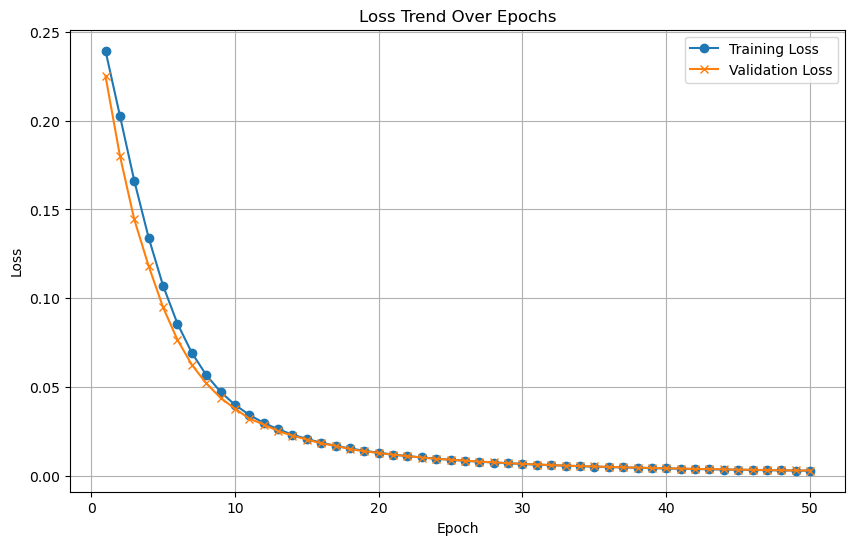

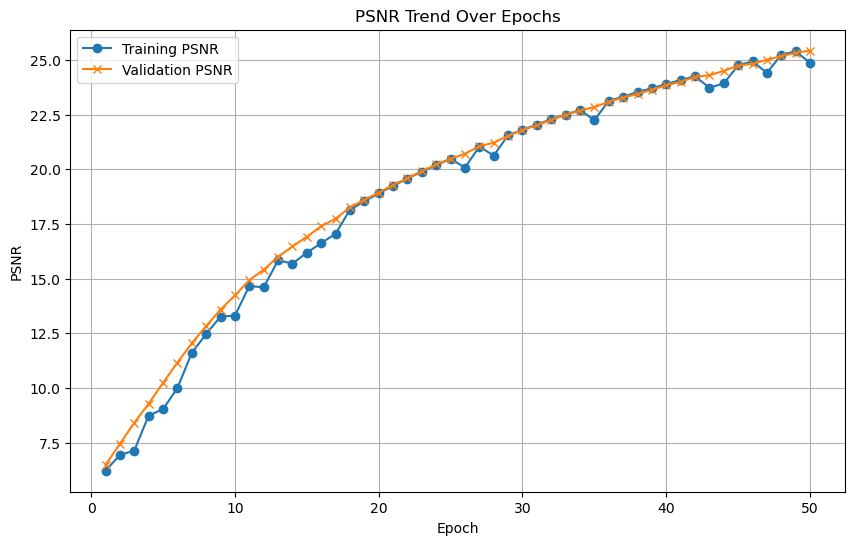

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/19 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5687
    Validation Batch [1/1], Loss: 2.5706
Validation Loss: 2.5706, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5706. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5536
    Validation Batch [1/1], Loss: 2.5706
Validation Loss: 2.5706, Validation Accuracy: 7.69%
Validation loss improved from 2.5706 to 2.5706. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5453
    Validation Batch [1/1], Loss: 2.5706
Validation Loss: 2.5706, Validation Accuracy: 7.69%
Validation loss improved from 2.5706 to 2.5706. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5371
    Validation Batch [1/1], Loss: 2.5706
Validation Loss: 2.5706, Validation Accuracy: 7.69%
Validation loss improved from 2.5706 to 2.5706. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.5704
Validation Loss: 2.5704, Validation Accuracy: 7.69%
Validation loss improved from 2.5705 to 2.5704. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.4951
    Validation Batch [1/1], Loss: 2.5704
Validation Loss: 2.5704, Validation Accuracy: 7.69%
Validation loss improved from 2.5704 to 2.5704. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.4962
    Validation Batch [1/1], Loss: 2.5703
Validation Loss: 2.5703, Validation Accuracy: 7.69%
Validation loss improved from 2.5704 to 2.5703. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4853
    Validation Batch [1/1], Loss: 2.5702
Validation Loss: 2.5702, Validation Accuracy: 7.69%
Validation loss improved from 2.5703 to 2.5702. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4751
    Validation

Epoch [21/1000] completed, Average Training Loss: 2.3934
    Validation Batch [1/1], Loss: 2.5660
Validation Loss: 2.5660, Validation Accuracy: 7.69%
Validation loss improved from 2.5668 to 2.5660. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.3807
    Validation Batch [1/1], Loss: 2.5650
Validation Loss: 2.5650, Validation Accuracy: 7.69%
Validation loss improved from 2.5660 to 2.5650. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.3610
    Validation Batch [1/1], Loss: 2.5635
Validation Loss: 2.5635, Validation Accuracy: 7.69%
Validation loss improved from 2.5650 to 2.5635. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.3528
    Validation Batch [1/1], Loss: 2.5619
Validation Loss: 2.5619, Validation Accuracy: 13.85%
Validation loss improved from 2.5635 to 2.5619. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1

Epoch [36/1000] completed, Average Training Loss: 2.1759
    Validation Batch [1/1], Loss: 2.4799
Validation Loss: 2.4799, Validation Accuracy: 16.92%
Validation loss improved from 2.4958 to 2.4799. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.1500
    Validation Batch [1/1], Loss: 2.4598
Validation Loss: 2.4598, Validation Accuracy: 16.92%
Validation loss improved from 2.4799 to 2.4598. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.1400
    Validation Batch [1/1], Loss: 2.4371
Validation Loss: 2.4371, Validation Accuracy: 16.92%
Validation loss improved from 2.4598 to 2.4371. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.1283
    Validation Batch [1/1], Loss: 2.4095
Validation Loss: 2.4095, Validation Accuracy: 18.46%
Validation loss improved from 2.4371 to 2.4095. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [4

Epoch [51/1000] completed, Average Training Loss: 1.9391
    Validation Batch [1/1], Loss: 2.0783
Validation Loss: 2.0783, Validation Accuracy: 40.00%
Validation loss improved from 2.1027 to 2.0783. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.9111
    Validation Batch [1/1], Loss: 2.0473
Validation Loss: 2.0473, Validation Accuracy: 40.00%
Validation loss improved from 2.0783 to 2.0473. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.9192
    Validation Batch [1/1], Loss: 2.0246
Validation Loss: 2.0246, Validation Accuracy: 38.46%
Validation loss improved from 2.0473 to 2.0246. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.8773
    Validation Batch [1/1], Loss: 2.0233
Validation Loss: 2.0233, Validation Accuracy: 36.92%
Validation loss improved from 2.0246 to 2.0233. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [5

Epoch [66/1000] completed, Average Training Loss: 1.7022
    Validation Batch [1/1], Loss: 1.8082
Validation Loss: 1.8082, Validation Accuracy: 53.85%
Validation loss improved from 1.8133 to 1.8082. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.6904
    Validation Batch [1/1], Loss: 1.7863
Validation Loss: 1.7863, Validation Accuracy: 55.38%
Validation loss improved from 1.8082 to 1.7863. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.6601
    Validation Batch [1/1], Loss: 1.7578
Validation Loss: 1.7578, Validation Accuracy: 53.85%
Validation loss improved from 1.7863 to 1.7578. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.6653
    Validation Batch [1/1], Loss: 1.7415
Validation Loss: 1.7415, Validation Accuracy: 56.92%
Validation loss improved from 1.7578 to 1.7415. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [7

Epoch [81/1000] completed, Average Training Loss: 1.4757
    Validation Batch [1/1], Loss: 1.5512
Validation Loss: 1.5512, Validation Accuracy: 58.46%
Validation loss improved from 1.5813 to 1.5512. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.4615
    Validation Batch [1/1], Loss: 1.5348
Validation Loss: 1.5348, Validation Accuracy: 56.92%
Validation loss improved from 1.5512 to 1.5348. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.4188
    Validation Batch [1/1], Loss: 1.5216
Validation Loss: 1.5216, Validation Accuracy: 63.08%
Validation loss improved from 1.5348 to 1.5216. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.4294
    Validation Batch [1/1], Loss: 1.5160
Validation Loss: 1.5160, Validation Accuracy: 56.92%
Validation loss improved from 1.5216 to 1.5160. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [8

    Validation Batch [1/1], Loss: 1.3720
Validation Loss: 1.3720, Validation Accuracy: 61.54%
Validation loss improved from 1.3875 to 1.3720. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.2356
    Validation Batch [1/1], Loss: 1.3574
Validation Loss: 1.3574, Validation Accuracy: 64.62%
Validation loss improved from 1.3720 to 1.3574. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.2422
    Validation Batch [1/1], Loss: 1.3442
Validation Loss: 1.3442, Validation Accuracy: 66.15%
Validation loss improved from 1.3574 to 1.3442. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.2212
    Validation Batch [1/1], Loss: 1.3423
Validation Loss: 1.3423, Validation Accuracy: 67.69%
Validation loss improved from 1.3442 to 1.3423. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.1736
    Vali

Epoch [110/1000] completed, Average Training Loss: 1.0183
    Validation Batch [1/1], Loss: 1.1919
Validation Loss: 1.1919, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.9970
    Validation Batch [1/1], Loss: 1.1668
Validation Loss: 1.1668, Validation Accuracy: 67.69%
Validation loss improved from 1.1876 to 1.1668. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 0.9813
    Validation Batch [1/1], Loss: 1.1492
Validation Loss: 1.1492, Validation Accuracy: 69.23%
Validation loss improved from 1.1668 to 1.1492. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 0.9618
    Validation Batch [1/1], Loss: 1.1487
Validation Loss: 1.1487, Validation Accuracy: 69.23%
Validation loss improved from 1.1492 to 1.1487. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000

    Validation Batch [1/1], Loss: 1.0230
Validation Loss: 1.0230, Validation Accuracy: 78.46%
Validation loss improved from 1.0378 to 1.0230. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.8045
    Validation Batch [1/1], Loss: 1.0088
Validation Loss: 1.0088, Validation Accuracy: 76.92%
Validation loss improved from 1.0230 to 1.0088. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.8113
    Validation Batch [1/1], Loss: 1.0057
Validation Loss: 1.0057, Validation Accuracy: 76.92%
Validation loss improved from 1.0088 to 1.0057. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.7934
    Validation Batch [1/1], Loss: 1.0122
Validation Loss: 1.0122, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.7745
    Validation 

    Validation Batch [1/1], Loss: 0.8923
Validation Loss: 0.8923, Validation Accuracy: 83.08%
Validation loss improved from 0.8969 to 0.8923. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.6362
    Validation Batch [1/1], Loss: 0.8671
Validation Loss: 0.8671, Validation Accuracy: 81.54%
Validation loss improved from 0.8923 to 0.8671. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.6088
    Validation Batch [1/1], Loss: 0.8542
Validation Loss: 0.8542, Validation Accuracy: 84.62%
Validation loss improved from 0.8671 to 0.8542. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 0.6003
    Validation Batch [1/1], Loss: 0.8525
Validation Loss: 0.8525, Validation Accuracy: 84.62%
Validation loss improved from 0.8542 to 0.8525. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 0.6019


Epoch [155/1000] completed, Average Training Loss: 0.4985
    Validation Batch [1/1], Loss: 0.7654
Validation Loss: 0.7654, Validation Accuracy: 83.08%
Validation loss improved from 0.7788 to 0.7654. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.4764
    Validation Batch [1/1], Loss: 0.7842
Validation Loss: 0.7842, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.4624
    Validation Batch [1/1], Loss: 0.7444
Validation Loss: 0.7444, Validation Accuracy: 84.62%
Validation loss improved from 0.7654 to 0.7444. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.4379
    Validation Batch [1/1], Loss: 0.7447
Validation Loss: 0.7447, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Av

Epoch [171/1000] completed, Average Training Loss: 0.3470
    Validation Batch [1/1], Loss: 0.6902
Validation Loss: 0.6902, Validation Accuracy: 87.69%
Validation loss improved from 0.7017 to 0.6902. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 0.3516
    Validation Batch [1/1], Loss: 0.6857
Validation Loss: 0.6857, Validation Accuracy: 87.69%
Validation loss improved from 0.6902 to 0.6857. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 0.3470
    Validation Batch [1/1], Loss: 0.6884
Validation Loss: 0.6884, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.3276
    Validation Batch [1/1], Loss: 0.6817
Validation Loss: 0.6817, Validation Accuracy: 87.69%
Validation loss improved from 0.6857 to 0.6817. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000

Epoch [186/1000] completed, Average Training Loss: 0.2750
    Validation Batch [1/1], Loss: 0.6206
Validation Loss: 0.6206, Validation Accuracy: 87.69%
Validation loss improved from 0.6247 to 0.6206. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.2719
    Validation Batch [1/1], Loss: 0.6424
Validation Loss: 0.6424, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.2713
    Validation Batch [1/1], Loss: 0.6432
Validation Loss: 0.6432, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.2453
    Validation Batch [1/1], Loss: 0.6386
Validation Loss: 0.6386, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training 

Epoch [201/1000] completed, Average Training Loss: 0.2232
    Validation Batch [1/1], Loss: 0.5940
Validation Loss: 0.5940, Validation Accuracy: 86.15%
Validation loss improved from 0.6037 to 0.5940. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.2129
    Validation Batch [1/1], Loss: 0.6186
Validation Loss: 0.6186, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.2032
    Validation Batch [1/1], Loss: 0.6310
Validation Loss: 0.6310, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.1853
    Validation Batch [1/1], Loss: 0.5923
Validation Loss: 0.5923, Validation Accuracy: 90.77%
Validation loss improved from 0.5940 to 0.5923. Saving model...

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Av

Epoch [209/1000] completed, Average Training Loss: 0.1744
    Validation Batch [1/1], Loss: 0.6240
Validation Loss: 0.6240, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.1820
    Validation Batch [1/1], Loss: 0.6371
Validation Loss: 0.6371, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.1784
    Validation Batch [1/1], Loss: 0.5988
Validation Loss: 0.5988, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.1656
    Validation Batch [1/1], Loss: 0.5940
Validation Loss: 0.5940, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.1577
  

Epoch [224/1000] completed, Average Training Loss: 0.1349
    Validation Batch [1/1], Loss: 0.6328
Validation Loss: 0.6328, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.1447
    Validation Batch [1/1], Loss: 0.6081
Validation Loss: 0.6081, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.1475
    Validation Batch [1/1], Loss: 0.6112
Validation Loss: 0.6112, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.1282
    Validation Batch [1/1], Loss: 0.5930
Validation Loss: 0.5930, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.132

    Validation Batch [1/1], Loss: 0.6225
Validation Loss: 0.6225, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.1101
    Validation Batch [1/1], Loss: 0.5710
Validation Loss: 0.5710, Validation Accuracy: 89.23%
Validation loss improved from 0.5813 to 0.5710. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.1277
    Validation Batch [1/1], Loss: 0.5895
Validation Loss: 0.5895, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.1043
    Validation Batch [1/1], Loss: 0.6177
Validation Loss: 0.6177, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.1058
    Validation Batch [1/1], Loss: 0.5934
Val

Epoch [254/1000] completed, Average Training Loss: 0.0933
    Validation Batch [1/1], Loss: 0.5630
Validation Loss: 0.5630, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.0906
    Validation Batch [1/1], Loss: 0.6080
Validation Loss: 0.6080, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.0962
    Validation Batch [1/1], Loss: 0.5960
Validation Loss: 0.5960, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.0958
    Validation Batch [1/1], Loss: 0.5528
Validation Loss: 0.5528, Validation Accuracy: 89.23%
Validation loss improved from 0.5528 to 0.5528. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training 

Epoch [269/1000] completed, Average Training Loss: 0.0848
    Validation Batch [1/1], Loss: 0.5897
Validation Loss: 0.5897, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.0796
    Validation Batch [1/1], Loss: 0.5552
Validation Loss: 0.5552, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.0848
    Validation Batch [1/1], Loss: 0.5883
Validation Loss: 0.5883, Validation Accuracy: 92.31%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.0795
    Validation Batch [1/1], Loss: 0.6393
Validation Loss: 0.6393, Validation Accuracy: 92.31%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.081

Epoch [284/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.5724
Validation Loss: 0.5724, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 0.5610
Validation Loss: 0.5610, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0713
    Validation Batch [1/1], Loss: 0.5679
Validation Loss: 0.5679, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.0686
    Validation Batch [1/1], Loss: 0.5684
Validation Loss: 0.5684, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.0728
  

Epoch [299/1000] completed, Average Training Loss: 0.0584
    Validation Batch [1/1], Loss: 0.5623
Validation Loss: 0.5623, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.0575
    Validation Batch [1/1], Loss: 0.5528
Validation Loss: 0.5528, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0637
    Validation Batch [1/1], Loss: 0.5254
Validation Loss: 0.5254, Validation Accuracy: 90.77%
Validation loss improved from 0.5450 to 0.5254. Saving model...

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.0689
    Validation Batch [1/1], Loss: 0.5309
Validation Loss: 0.5309, Validation Accuracy: 92.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Trainin

Epoch [313/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.5681
Validation Loss: 0.5681, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.5783
Validation Loss: 0.5783, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.5724
Validation Loss: 0.5724, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.0659
    Validation Batch [1/1], Loss: 0.5499
Validation Loss: 0.5499, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.0458


    Validation Batch [1/1], Loss: 0.5776
Validation Loss: 0.5776, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.5445
Validation Loss: 0.5445, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.5376
Validation Loss: 0.5376, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.5473
Validation Loss: 0.5473, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.5660
Validation Loss

    Validation Batch [1/1], Loss: 0.5636
Validation Loss: 0.5636, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.5627
Validation Loss: 0.5627, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.0425
    Validation Batch [1/1], Loss: 0.5730
Validation Loss: 0.5730, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.6027
Validation Loss: 0.6027, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.0403
    Validation Batch [1/1], Loss: 0.5733
Validation Loss

    Validation Batch [1/1], Loss: 0.6090
Validation Loss: 0.6090, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.0340
    Validation Batch [1/1], Loss: 0.6232
Validation Loss: 0.6232, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.0356
    Validation Batch [1/1], Loss: 0.6697
Validation Loss: 0.6697, Validation Accuracy: 92.31%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.7249
Validation Loss: 0.7249, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.7094
Validation Loss

Validation Loss: 0.6947, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.6559
Validation Loss: 0.6559, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.0344
    Validation Batch [1/1], Loss: 0.6172
Validation Loss: 0.6172, Validation Accuracy: 92.31%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0367
    Validation Batch [1/1], Loss: 0.6092
Validation Loss: 0.6092, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0374
    Validation Batch [1/1], Loss: 0.6149
Validation Loss: 0.6149, Validation Accuracy: 92.31%
Val

    Validation Batch [1/1], Loss: 0.5566
Validation Loss: 0.5566, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0308
    Validation Batch [1/1], Loss: 0.5772
Validation Loss: 0.5772, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.6233
Validation Loss: 0.6233, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0331
    Validation Batch [1/1], Loss: 0.6621
Validation Loss: 0.6621, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0296
    Validation Batch [1/1], Loss: 0.6386
Validation Loss

Epoch [400/1000] completed, Average Training Loss: 0.0267
    Validation Batch [1/1], Loss: 0.5656
Validation Loss: 0.5656, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.5607
Validation Loss: 0.5607, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.5632
Validation Loss: 0.5632, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.0283
    Validation Batch [1/1], Loss: 0.6118
Validation Loss: 0.6118, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.028

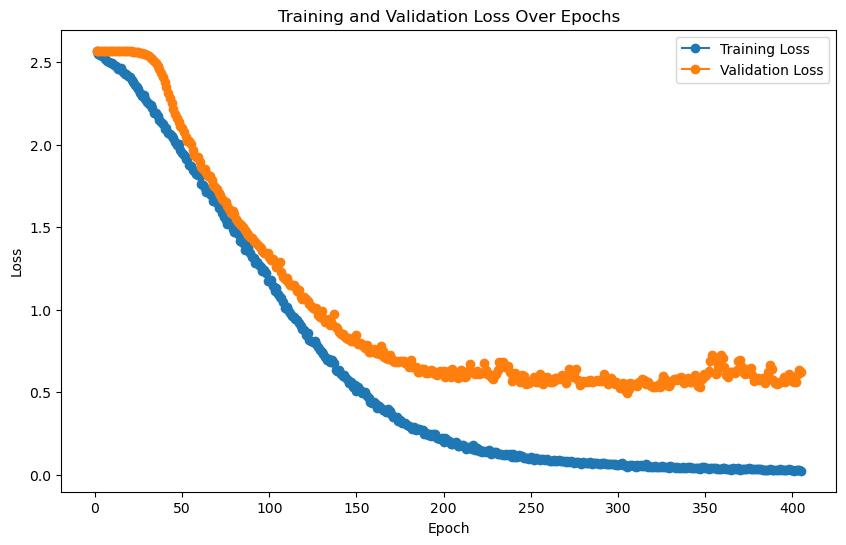

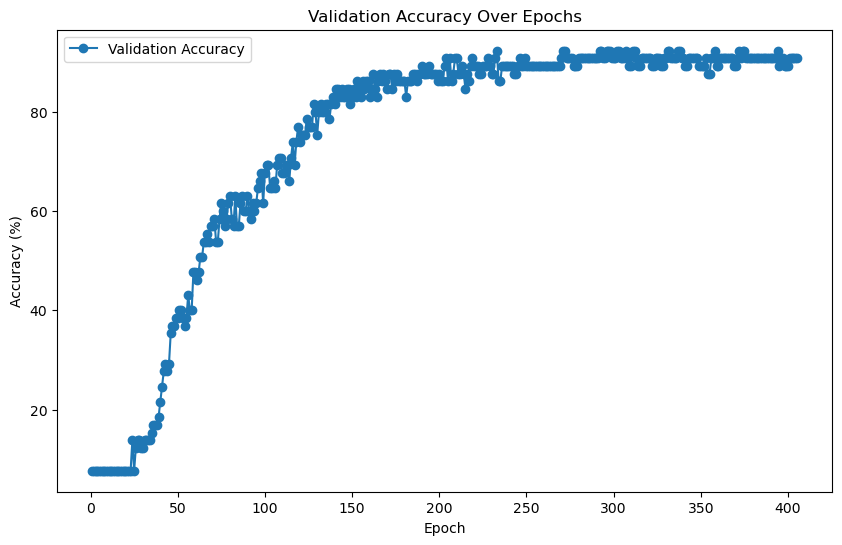


Evaluating on the test set...
    Test Batch [1/19], Loss: 0.3000

Final Test Loss: 0.5267, Test Accuracy: 88.02%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)

LOG: Training features shape: (520, 64), Training labels shape: (520,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4626, 64), Test labels shape: (4626,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 40.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.33      0.20      0.25         5
           2       0.17      0.20      0.18         5
           3       0.00      0.00      0.00         5
           4       0.29      0.40      0.33         5
           5       0.33      0.20      0.25         5
           6       0.33      0.60      0.43         5
           7       0.36      0.80      0.50         5
           8       0.60      0.60      0.60         5
           9       0.00      0.00      0.00         5
          10       1.00      0.60      0.75         5
          11       1.00      0.20      0.33         5
          12       0.50      0.80      0.62         5

    accuracy                           0.40        65
   macro avg       0.41      0.40     

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)
Train reps shape: (520, 64)
Train labels shape: (520,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4626, 64)
Test labels shape: (4626,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6756  |  Val Loss: 2.5673
Validation loss improved from inf to 2.5673.
[Epoch 2/1000] Train Loss: 2.5460  |  Val Loss: 2.5314
Validation loss improved from 2.5673 to 2.5314.
[Epoch 3/1000] Train Loss: 2.5043  |  Val Loss: 2.5260
Validation loss improved from 2.5314 to 2.5260.
[Epoch 4/1000] Train Loss: 2.4817  |  Val Loss: 2.5154
Validation loss improved from 2.5260 to 2.5154.
[Epoch 5/1000] Train Loss: 2.4751  |  Val Loss: 2.5168
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 6/1000] Train Loss: 2.4566  |  Val Loss: 2.5405
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 7/1000] Train Loss: 2.4405  |  Val Loss: 2.5300
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 8/1000] Train Loss: 2.4254  |  Val Loss: 2.5297
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 9/1000] Train Loss: 2.4114  |  Val Loss: 2.5226
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 10/1000] Train Loss: 2.3980  |  Val Loss: 2.5262
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 11/1000] Train Loss: 2.3930  |  Val Loss: 2.5210
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 12/1000] Train Loss: 2.3771  |  Val Loss: 2.5002
Validation loss improved from 2.5154 to 2.5002.


[Epoch 13/1000] Train Loss: 2.3642  |  Val Loss: 2.4962
Validation loss improved from 2.5002 to 2.4962.
[Epoch 14/1000] Train Loss: 2.3530  |  Val Loss: 2.5083
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 15/1000] Train Loss: 2.3689  |  Val Loss: 2.5268
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 16/1000] Train Loss: 2.3286  |  Val Loss: 2.4676
Validation loss improved from 2.4962 to 2.4676.
[Epoch 17/1000] Train Loss: 2.3000  |  Val Loss: 2.4458
Validation loss improved from 2.4676 to 2.4458.
[Epoch 18/1000] Train Loss: 2.2854  |  Val Loss: 2.4212
Validation loss improved from 2.4458 to 2.4212.
[Epoch 19/1000] Train Loss: 2.2675  |  Val Loss: 2.3727
Validation loss improved from 2.4212 to 2.3727.
[Epoch 20/1000] Train Loss: 2.2354  |  Val Loss: 2.3858
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 21/1000] Train Loss: 2.2062  |  Val Loss: 2.3784
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 22/1000] Train Loss: 2.1736  |  Val Loss: 2.3573
Validation loss improved from 2.3727 to 2.3573.
[Epoch 23/1000] Train Loss: 2.1399  |  Val Loss: 2.3216
Validation loss improved from 2.3573 to 2.3216.
[Epoch 24/1000] Train Loss: 2.1042  |  Val Loss: 2.2985
Validation loss improved from 2.3216 to 2.2985.
[Epoch 25/1000] Train Loss: 2.0818  |  Val Loss: 2.2875
Validation loss improved from 2.2985 to 2.2875.


[Epoch 26/1000] Train Loss: 2.0557  |  Val Loss: 2.2764
Validation loss improved from 2.2875 to 2.2764.
[Epoch 27/1000] Train Loss: 2.0397  |  Val Loss: 2.2356
Validation loss improved from 2.2764 to 2.2356.
[Epoch 28/1000] Train Loss: 2.0129  |  Val Loss: 2.2009
Validation loss improved from 2.2356 to 2.2009.
[Epoch 29/1000] Train Loss: 1.9855  |  Val Loss: 2.2068
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 30/1000] Train Loss: 1.9582  |  Val Loss: 2.1622
Validation loss improved from 2.2009 to 2.1622.
[Epoch 31/1000] Train Loss: 1.9207  |  Val Loss: 2.1895
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 1.9047  |  Val Loss: 2.1512
Validation loss improved from 2.1622 to 2.1512.


[Epoch 33/1000] Train Loss: 1.8860  |  Val Loss: 2.1347
Validation loss improved from 2.1512 to 2.1347.
[Epoch 34/1000] Train Loss: 1.8812  |  Val Loss: 2.2073
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 1.8788  |  Val Loss: 2.1603
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 36/1000] Train Loss: 1.8434  |  Val Loss: 2.1480
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 37/1000] Train Loss: 1.8207  |  Val Loss: 2.1365
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 38/1000] Train Loss: 1.8146  |  Val Loss: 2.1495
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 39/1000] Train Loss: 1.8156  |  Val Loss: 2.2026
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 40/1000] Train Loss: 1.8288  |  Val Loss: 2.1320
Validation loss improved from 2.1347 to 2.1320.
[Epoch 41/1000] Train Loss: 1.7767  |  Val Loss: 2.1268
Validation loss improved from 2.1320 to 2.1268.
[Epoch 42/1000] Train Loss: 1.7788  |  Val Loss: 2.1189
Validation loss improved from 2.1268 to 2.1189.
[Epoch 43/1000] Train Loss: 1.7763  |  Val Loss: 2.0929
Validation loss improved from 2.1189 to 2.0929.
[Epoch 44/1000] Train Loss: 1.7489  |  Val Loss: 2.1143
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 45/1000] Train Loss: 1.7989  |  Val Loss: 2.1577
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 46/1000] Train Loss: 1.7646  |  Val Loss: 2.0654
Validation loss improved from 2.0929 to 2.0654.
[Epoch 47/1000] Train Loss: 1.7466  |  Val Loss: 2.1533
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 48/1000] Train Loss: 1.7333  |  Val Loss: 2.1306
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 49/1000] Train Loss: 1.7296  |  Val Loss: 2.0890
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 50/1000] Train Loss: 1.7197  |  Val Loss: 2.1647
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 51/1000] Train Loss: 1.7306  |  Val Loss: 2.1573
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 52/1000] Train Loss: 1.7278  |  Val Loss: 2.1009
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 53/1000] Train Loss: 1.6900  |  Val Loss: 2.0705
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 54/1000] Train Loss: 1.6702  |  Val Loss: 2.0521
Validation loss improved from 2.0654 to 2.0521.
[Epoch 55/1000] Train Loss: 1.6668  |  Val Loss: 2.0528
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 1.6661  |  Val Loss: 2.1243
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 57/1000] Train Loss: 1.6726  |  Val Loss: 2.0893
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 58/1000] Train Loss: 1.6520  |  Val Loss: 2.0763
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 59/1000] Train Loss: 1.6817  |  Val Loss: 2.0845
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 60/1000] Train Loss: 1.6467  |  Val Loss: 2.1087
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 61/1000] Train Loss: 1.6236  |  Val Loss: 2.0665
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 62/1000] Train Loss: 1.6578  |  Val Loss: 2.0694
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 63/1000] Train Loss: 1.6340  |  Val Loss: 2.0633
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 64/1000] Train Loss: 1.6010  |  Val Loss: 2.1568
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 65/1000] Train Loss: 1.6087  |  Val Loss: 2.0950
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 66/1000] Train Loss: 1.6352  |  Val Loss: 2.0722
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 67/1000] Train Loss: 1.6350  |  Val Loss: 2.1011
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 68/1000] Train Loss: 1.5977  |  Val Loss: 2.0913
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 69/1000] Train Loss: 1.6039  |  Val Loss: 2.2149
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 70/1000] Train Loss: 1.6308  |  Val Loss: 2.1258
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 71/1000] Train Loss: 1.6187  |  Val Loss: 2.1160
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 72/1000] Train Loss: 1.5775  |  Val Loss: 2.0952
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 73/1000] Train Loss: 1.5940  |  Val Loss: 2.0419
Validation loss improved from 2.0521 to 2.0419.
[Epoch 74/1000] Train Loss: 1.5691  |  Val Loss: 2.1040
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 75/1000] Train Loss: 1.6108  |  Val Loss: 2.1134
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 76/1000] Train Loss: 1.5941  |  Val Loss: 2.1104
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 77/1000] Train Loss: 1.5799  |  Val Loss: 2.0862
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 78/1000] Train Loss: 1.5610  |  Val Loss: 2.1157
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 79/1000] Train Loss: 1.5700  |  Val Loss: 2.0594
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 80/1000] Train Loss: 1.5776  |  Val Loss: 2.0918
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 81/1000] Train Loss: 1.5647  |  Val Loss: 2.0599
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 82/1000] Train Loss: 1.5675  |  Val Loss: 2.1265
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 83/1000] Train Loss: 1.6169  |  Val Loss: 2.3547
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 84/1000] Train Loss: 1.6077  |  Val Loss: 2.3200
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 85/1000] Train Loss: 1.6353  |  Val Loss: 2.2928
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 86/1000] Train Loss: 1.6279  |  Val Loss: 2.4740
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 87/1000] Train Loss: 1.7530  |  Val Loss: 2.0786
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 88/1000] Train Loss: 1.5770  |  Val Loss: 2.0965
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 89/1000] Train Loss: 1.5398  |  Val Loss: 2.0994
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 90/1000] Train Loss: 1.5470  |  Val Loss: 2.1032
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 91/1000] Train Loss: 1.5467  |  Val Loss: 2.0624
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 92/1000] Train Loss: 1.5363  |  Val Loss: 2.0903
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 93/1000] Train Loss: 1.5452  |  Val Loss: 2.0579
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 94/1000] Train Loss: 1.5390  |  Val Loss: 2.0747
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 95/1000] Train Loss: 1.5227  |  Val Loss: 2.1101
!! Validation loss did NOT improve !! Patience: 22/100


[Epoch 96/1000] Train Loss: 1.5324  |  Val Loss: 2.1007
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 97/1000] Train Loss: 1.5223  |  Val Loss: 2.1828
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 98/1000] Train Loss: 1.5530  |  Val Loss: 2.0776
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 99/1000] Train Loss: 1.5040  |  Val Loss: 2.0519
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 100/1000] Train Loss: 1.5018  |  Val Loss: 2.0752
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 101/1000] Train Loss: 1.5108  |  Val Loss: 2.0597
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 102/1000] Train Loss: 1.5090  |  Val Loss: 2.0720
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 103/1000] Train Loss: 1.4903  |  Val Loss: 2.0711
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 104/1000] Train Loss: 1.4928  |  Val Loss: 2.1538
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 105/1000] Train Loss: 1.5359  |  Val Loss: 2.0885
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 106/1000] Train Loss: 1.5257  |  Val Loss: 2.1760
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 107/1000] Train Loss: 1.4935  |  Val Loss: 2.1430
!! Validation loss did NOT improve !! Patience: 34/100


[Epoch 108/1000] Train Loss: 1.5269  |  Val Loss: 2.0868
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 109/1000] Train Loss: 1.5265  |  Val Loss: 2.0846
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 110/1000] Train Loss: 1.5365  |  Val Loss: 2.0813
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 111/1000] Train Loss: 1.5122  |  Val Loss: 2.0799
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 112/1000] Train Loss: 1.5018  |  Val Loss: 2.1160
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 113/1000] Train Loss: 1.5228  |  Val Loss: 2.1038
!! Validation loss did NOT improve !! Patience: 40/100


[Epoch 114/1000] Train Loss: 1.4906  |  Val Loss: 2.1088
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 115/1000] Train Loss: 1.5379  |  Val Loss: 2.0848
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 116/1000] Train Loss: 1.4625  |  Val Loss: 2.0941
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 117/1000] Train Loss: 1.4686  |  Val Loss: 2.0979
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 118/1000] Train Loss: 1.5123  |  Val Loss: 2.0845
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 119/1000] Train Loss: 1.4817  |  Val Loss: 2.1054
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 120/1000] Train Loss: 1.4682  |  Val Loss: 2.0240
Validation loss improved from 2.0419 to 2.0240.
[Epoch 121/1000] Train Loss: 1.4779  |  Val Loss: 2.0942
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Train Loss: 1.4751  |  Val Loss: 2.0575
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 123/1000] Train Loss: 1.4765  |  Val Loss: 2.0546
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 124/1000] Train Loss: 1.4695  |  Val Loss: 2.2427
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 125/1000] Train Loss: 1.5464  |  Val Loss: 2.3400
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 126/1000] Train Loss: 1.5115  |  Val Loss: 2.1138
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 127/1000] Train Loss: 1.4864  |  Val Loss: 2.1269
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 128/1000] Train Loss: 1.4681  |  Val Loss: 2.0965
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 129/1000] Train Loss: 1.4417  |  Val Loss: 2.0779
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 130/1000] Train Loss: 1.4759  |  Val Loss: 2.0874
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 131/1000] Train Loss: 1.4520  |  Val Loss: 2.1355
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 132/1000] Train Loss: 1.4874  |  Val Loss: 2.1018
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 133/1000] Train Loss: 1.4660  |  Val Loss: 2.0898
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 134/1000] Train Loss: 1.4441  |  Val Loss: 2.0874
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 135/1000] Train Loss: 1.4628  |  Val Loss: 2.1288
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 136/1000] Train Loss: 1.4827  |  Val Loss: 2.0713
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 137/1000] Train Loss: 1.4294  |  Val Loss: 2.1425
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 138/1000] Train Loss: 1.4507  |  Val Loss: 2.1175
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 139/1000] Train Loss: 1.4405  |  Val Loss: 2.0897
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 140/1000] Train Loss: 1.4182  |  Val Loss: 2.0759
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 141/1000] Train Loss: 1.4329  |  Val Loss: 2.0819
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 142/1000] Train Loss: 1.4281  |  Val Loss: 2.0729
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 143/1000] Train Loss: 1.4764  |  Val Loss: 2.1994
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 144/1000] Train Loss: 1.5255  |  Val Loss: 2.1136
!! Validation loss did NOT improve !! Patience: 24/100


[Epoch 145/1000] Train Loss: 1.4383  |  Val Loss: 2.0747
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 146/1000] Train Loss: 1.4032  |  Val Loss: 2.0773
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 147/1000] Train Loss: 1.4115  |  Val Loss: 2.1733
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 148/1000] Train Loss: 1.5047  |  Val Loss: 2.1898
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 149/1000] Train Loss: 1.4618  |  Val Loss: 2.0832
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 150/1000] Train Loss: 1.4125  |  Val Loss: 2.0718
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 151/1000] Train Loss: 1.3947  |  Val Loss: 2.0622
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 152/1000] Train Loss: 1.3887  |  Val Loss: 2.0588
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 153/1000] Train Loss: 1.3900  |  Val Loss: 2.0763
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 154/1000] Train Loss: 1.4551  |  Val Loss: 2.0511
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 155/1000] Train Loss: 1.4129  |  Val Loss: 2.0737
!! Validation loss did NOT improve !! Patience: 35/100


[Epoch 156/1000] Train Loss: 1.3983  |  Val Loss: 2.0673
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 157/1000] Train Loss: 1.4194  |  Val Loss: 2.0692
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 158/1000] Train Loss: 1.4143  |  Val Loss: 2.1296
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 159/1000] Train Loss: 1.3931  |  Val Loss: 2.0605
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 160/1000] Train Loss: 1.3933  |  Val Loss: 2.0715
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 161/1000] Train Loss: 1.3966  |  Val Loss: 2.1039
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 162/1000] Train Loss: 1.3868  |  Val Loss: 2.1108
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 163/1000] Train Loss: 1.3565  |  Val Loss: 2.0373
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 164/1000] Train Loss: 1.3568  |  Val Loss: 2.0846
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 165/1000] Train Loss: 1.3717  |  Val Loss: 2.0627
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 166/1000] Train Loss: 1.3692  |  Val Loss: 2.0467
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 167/1000] Train Loss: 1.3659  |  Val Loss: 2.0857
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 168/1000] Train Loss: 1.3475  |  Val Loss: 2.0760
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 169/1000] Train Loss: 1.3510  |  Val Loss: 2.2637
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 170/1000] Train Loss: 1.4124  |  Val Loss: 2.1114
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 171/1000] Train Loss: 1.3857  |  Val Loss: 2.0314
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 172/1000] Train Loss: 1.3353  |  Val Loss: 2.0249
!! Validation loss did NOT improve !! Patience: 52/100


[Epoch 173/1000] Train Loss: 1.3439  |  Val Loss: 2.0280
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 174/1000] Train Loss: 1.3300  |  Val Loss: 2.0360
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 175/1000] Train Loss: 1.3401  |  Val Loss: 2.0082
Validation loss improved from 2.0240 to 2.0082.
[Epoch 176/1000] Train Loss: 1.3300  |  Val Loss: 2.0450
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 1.3577  |  Val Loss: 2.0792
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 1.3790  |  Val Loss: 2.1007
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Train Loss: 1.3467  |  Val Loss: 2.0905
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 180/1000] Train Loss: 1.3668  |  Val Loss: 2.0632
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 181/1000] Train Loss: 1.3219  |  Val Loss: 2.0265
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 182/1000] Train Loss: 1.3352  |  Val Loss: 2.0003
Validation loss improved from 2.0082 to 2.0003.
[Epoch 183/1000] Train Loss: 1.3296  |  Val Loss: 2.0289
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 184/1000] Train Loss: 1.3446  |  Val Loss: 2.0311
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 185/1000] Train Loss: 1.3314  |  Val Loss: 2.1047
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 186/1000] Train Loss: 1.3771  |  Val Loss: 1.9712
Validation loss improved from 2.0003 to 1.9712.
[Epoch 187/1000] Train Loss: 1.3019  |  Val Loss: 2.0023
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 1.3223  |  Val Loss: 1.9719
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 189/1000] Train Loss: 1.2943  |  Val Loss: 2.0257
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 190/1000] Train Loss: 1.3112  |  Val Loss: 1.9928
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 191/1000] Train Loss: 1.3567  |  Val Loss: 1.9157
Validation loss improved from 1.9712 to 1.9157.
[Epoch 192/1000] Train Loss: 1.3007  |  Val Loss: 2.0220
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 193/1000] Train Loss: 1.3879  |  Val Loss: 2.1367
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 194/1000] Train Loss: 1.3955  |  Val Loss: 2.0570
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 195/1000] Train Loss: 1.3244  |  Val Loss: 2.0392
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 196/1000] Train Loss: 1.3340  |  Val Loss: 2.0631
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 197/1000] Train Loss: 1.3217  |  Val Loss: 2.0999
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 198/1000] Train Loss: 1.4414  |  Val Loss: 1.9557
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 199/1000] Train Loss: 1.3056  |  Val Loss: 1.9234
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 200/1000] Train Loss: 1.2796  |  Val Loss: 1.9756
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 201/1000] Train Loss: 1.2820  |  Val Loss: 1.9552
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 202/1000] Train Loss: 1.2926  |  Val Loss: 1.9168
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 203/1000] Train Loss: 1.2871  |  Val Loss: 1.9198
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 204/1000] Train Loss: 1.2949  |  Val Loss: 1.9404
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 205/1000] Train Loss: 1.2700  |  Val Loss: 1.8919
Validation loss improved from 1.9157 to 1.8919.
[Epoch 206/1000] Train Loss: 1.2479  |  Val Loss: 1.9210
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 1.2569  |  Val Loss: 1.9102
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 1.2533  |  Val Loss: 1.8769
Validation loss improved from 1.8919 to 1.8769.


[Epoch 209/1000] Train Loss: 1.2890  |  Val Loss: 1.9153
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 210/1000] Train Loss: 1.2757  |  Val Loss: 1.8676
Validation loss improved from 1.8769 to 1.8676.
[Epoch 211/1000] Train Loss: 1.2601  |  Val Loss: 1.9077
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/1000] Train Loss: 1.2742  |  Val Loss: 1.9026
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 213/1000] Train Loss: 1.2527  |  Val Loss: 1.8725
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 214/1000] Train Loss: 1.2432  |  Val Loss: 1.9055
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 215/1000] Train Loss: 1.2757  |  Val Loss: 1.9203
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 216/1000] Train Loss: 1.2470  |  Val Loss: 1.9265
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 217/1000] Train Loss: 1.2438  |  Val Loss: 1.9840
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 218/1000] Train Loss: 1.2784  |  Val Loss: 1.9728
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 219/1000] Train Loss: 1.2681  |  Val Loss: 1.9162
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 220/1000] Train Loss: 1.2663  |  Val Loss: 1.8898
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 221/1000] Train Loss: 1.2318  |  Val Loss: 1.9068
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 222/1000] Train Loss: 1.2231  |  Val Loss: 1.8377
Validation loss improved from 1.8676 to 1.8377.
[Epoch 223/1000] Train Loss: 1.2390  |  Val Loss: 1.9386
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 1.2502  |  Val Loss: 1.9898
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 225/1000] Train Loss: 1.2563  |  Val Loss: 2.0164
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 226/1000] Train Loss: 1.2472  |  Val Loss: 1.9302
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 227/1000] Train Loss: 1.2348  |  Val Loss: 1.9837
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 228/1000] Train Loss: 1.2485  |  Val Loss: 1.9112
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 229/1000] Train Loss: 1.2369  |  Val Loss: 1.9168
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 230/1000] Train Loss: 1.2549  |  Val Loss: 1.9669
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 231/1000] Train Loss: 1.2635  |  Val Loss: 1.9486
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 232/1000] Train Loss: 1.2419  |  Val Loss: 1.9040
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 233/1000] Train Loss: 1.2597  |  Val Loss: 1.9023
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 234/1000] Train Loss: 1.2043  |  Val Loss: 1.8663
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 235/1000] Train Loss: 1.2347  |  Val Loss: 1.8758
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 236/1000] Train Loss: 1.2380  |  Val Loss: 1.9331
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 237/1000] Train Loss: 1.2331  |  Val Loss: 1.9224
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 238/1000] Train Loss: 1.2473  |  Val Loss: 1.9034
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 239/1000] Train Loss: 1.2180  |  Val Loss: 1.8504
!! Validation loss did NOT improve !! Patience: 

[Epoch 241/1000] Train Loss: 1.2024  |  Val Loss: 2.0042
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 242/1000] Train Loss: 1.2566  |  Val Loss: 1.9547
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 243/1000] Train Loss: 1.2285  |  Val Loss: 1.9241
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 244/1000] Train Loss: 1.2271  |  Val Loss: 1.8258
Validation loss improved from 1.8377 to 1.8258.
[Epoch 245/1000] Train Loss: 1.2089  |  Val Loss: 1.8091
Validation loss improved from 1.8258 to 1.8091.
[Epoch 246/1000] Train Loss: 1.2378  |  Val Loss: 1.8457
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 247/1000] Train Loss: 1.2300  |  Val Loss: 1.8926
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 248/1000] Train Loss: 1.2145  |  Val Loss: 1.8456
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 249/1000] Train Loss: 1.2309  |  Val Loss: 1.9106
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 250/1000] Train Loss: 1.2013  |  Val Loss: 1.8550
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 251/

[Epoch 253/1000] Train Loss: 1.2481  |  Val Loss: 1.7277
Validation loss improved from 1.8091 to 1.7277.
[Epoch 254/1000] Train Loss: 1.1987  |  Val Loss: 1.7399
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 255/1000] Train Loss: 1.2268  |  Val Loss: 1.8035
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 256/1000] Train Loss: 1.2384  |  Val Loss: 2.1540
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 257/1000] Train Loss: 1.2845  |  Val Loss: 2.1230
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 258/1000] Train Loss: 1.2482  |  Val Loss: 2.1050
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 259/1000] Train Loss: 1.2028  |  Val Loss: 2.0784
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 260/1000] Train Loss: 1.1825  |  Val Loss: 2.2330
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 261/1000] Train Loss: 1.2023  |  Val Loss: 1.9604
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 265/1000] Train Loss: 1.2232  |  Val Loss: 2.3811
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 266/1000] Train Loss: 1.1988  |  Val Loss: 1.8322
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 267/1000] Train Loss: 1.2169  |  Val Loss: 1.7981
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 268/1000] Train Loss: 1.2491  |  Val Loss: 2.4210
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 269/1000] Train Loss: 1.2451  |  Val Loss: 2.0440
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 270/1000] Train Loss: 1.1969  |  Val Loss: 2.0723
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 271/1000] Train Loss: 1.2136  |  Val Loss: 1.8332
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 272/1000] Train Loss: 1.2158  |  Val Loss: 1.9264
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 273/1000] Train Loss: 1.2292  |  Val Loss: 2.2289
!! Validation loss did NOT improve !! Patience:

[Epoch 277/1000] Train Loss: 1.1723  |  Val Loss: 2.2388
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 278/1000] Train Loss: 1.1872  |  Val Loss: 2.4139
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 279/1000] Train Loss: 1.3257  |  Val Loss: 2.3721
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 280/1000] Train Loss: 1.2504  |  Val Loss: 2.3041
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 281/1000] Train Loss: 1.2391  |  Val Loss: 2.1875
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 282/1000] Train Loss: 1.1943  |  Val Loss: 2.2277
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 283/1000] Train Loss: 1.1796  |  Val Loss: 2.1197
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 284/1000] Train Loss: 1.1562  |  Val Loss: 2.2147
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 285/1000] Train Loss: 1.2198  |  Val Loss: 2.2089
!! Validation loss did NOT improve !! Patience:

[Epoch 288/1000] Train Loss: 1.2513  |  Val Loss: 2.2040
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 289/1000] Train Loss: 1.2226  |  Val Loss: 2.1458
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 290/1000] Train Loss: 1.2201  |  Val Loss: 2.1136
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 291/1000] Train Loss: 1.1962  |  Val Loss: 2.1003
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 292/1000] Train Loss: 1.1901  |  Val Loss: 2.1369
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 293/1000] Train Loss: 1.1670  |  Val Loss: 2.1436
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 294/1000] Train Loss: 1.1947  |  Val Loss: 2.1158
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 295/1000] Train Loss: 1.1651  |  Val Loss: 2.1484
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 296/1000] Train Loss: 1.1620  |  Val Loss: 2.1146
!! Validation loss did NOT improve !! Patience:

[Epoch 300/1000] Train Loss: 1.1626  |  Val Loss: 2.1651
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 301/1000] Train Loss: 1.1728  |  Val Loss: 2.0681
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 302/1000] Train Loss: 1.1529  |  Val Loss: 2.1061
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 303/1000] Train Loss: 1.1446  |  Val Loss: 2.1559
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 304/1000] Train Loss: 1.1616  |  Val Loss: 2.1715
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 305/1000] Train Loss: 1.1616  |  Val Loss: 2.1583
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 306/1000] Train Loss: 1.1835  |  Val Loss: 2.1060
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 307/1000] Train Loss: 1.1815  |  Val Loss: 2.1574
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 308/1000] Train Loss: 1.1553  |  Val Loss: 2.1573
!! Validation loss did NOT improve !! Patience:

[Epoch 312/1000] Train Loss: 1.1427  |  Val Loss: 2.1203
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 313/1000] Train Loss: 1.1297  |  Val Loss: 2.2191
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 314/1000] Train Loss: 1.1457  |  Val Loss: 2.1789
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 315/1000] Train Loss: 1.1500  |  Val Loss: 2.1614
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 316/1000] Train Loss: 1.1254  |  Val Loss: 2.1646
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 317/1000] Train Loss: 1.1992  |  Val Loss: 2.1147
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 318/1000] Train Loss: 1.1451  |  Val Loss: 2.1090
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 319/1000] Train Loss: 1.1925  |  Val Loss: 2.1492
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 320/1000] Train Loss: 1.1855  |  Val Loss: 2.2545
!! Validation loss did NOT improve !! Patience:

[Epoch 323/1000] Train Loss: 1.3785  |  Val Loss: 2.1906
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 324/1000] Train Loss: 1.3118  |  Val Loss: 2.2836
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 325/1000] Train Loss: 1.2177  |  Val Loss: 2.1925
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 326/1000] Train Loss: 1.1780  |  Val Loss: 2.1890
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 327/1000] Train Loss: 1.1548  |  Val Loss: 2.1542
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 328/1000] Train Loss: 1.1446  |  Val Loss: 2.1207
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 329/1000] Train Loss: 1.1354  |  Val Loss: 2.1592
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 330/1000] Train Loss: 1.2145  |  Val Loss: 2.0740
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 331/1000] Train Loss: 1.1286  |  Val Loss: 2.0758
!! Validation loss did NOT improve !! Patience:

[Epoch 334/1000] Train Loss: 1.1177  |  Val Loss: 2.0725
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 335/1000] Train Loss: 1.1097  |  Val Loss: 2.1420
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 336/1000] Train Loss: 1.1706  |  Val Loss: 2.1647
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 337/1000] Train Loss: 1.1570  |  Val Loss: 2.1787
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 338/1000] Train Loss: 1.1476  |  Val Loss: 2.0925
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 339/1000] Train Loss: 1.1047  |  Val Loss: 2.2197
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 340/1000] Train Loss: 1.1440  |  Val Loss: 2.2524
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 341/1000] Train Loss: 1.1188  |  Val Loss: 2.0846
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 342/1000] Train Loss: 1.1071  |  Val Loss: 2.0591
!! Validation loss did NOT improve !! Patience:

[Epoch 347/1000] Train Loss: 1.1441  |  Val Loss: 2.0886
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 348/1000] Train Loss: 1.1352  |  Val Loss: 2.1725
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 349/1000] Train Loss: 1.1130  |  Val Loss: 2.1663
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 350/1000] Train Loss: 1.1494  |  Val Loss: 2.0450
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 351/1000] Train Loss: 1.1367  |  Val Loss: 2.1235
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 352/1000] Train Loss: 1.1374  |  Val Loss: 2.1471
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 353/1000] Train Loss: 1.1185  |  Val Loss: 2.1483
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 353 !!
No improvement for 100 epochs.


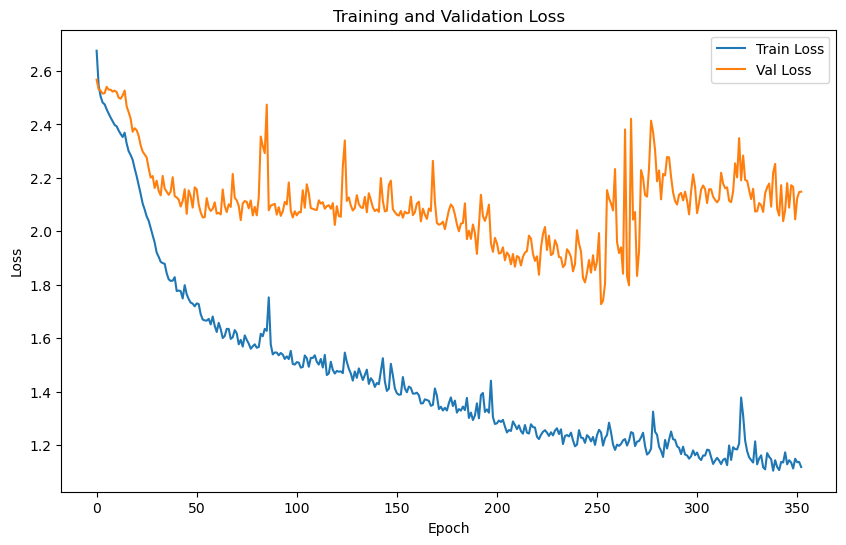

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.8616 | Test Accuracy: 54.97%


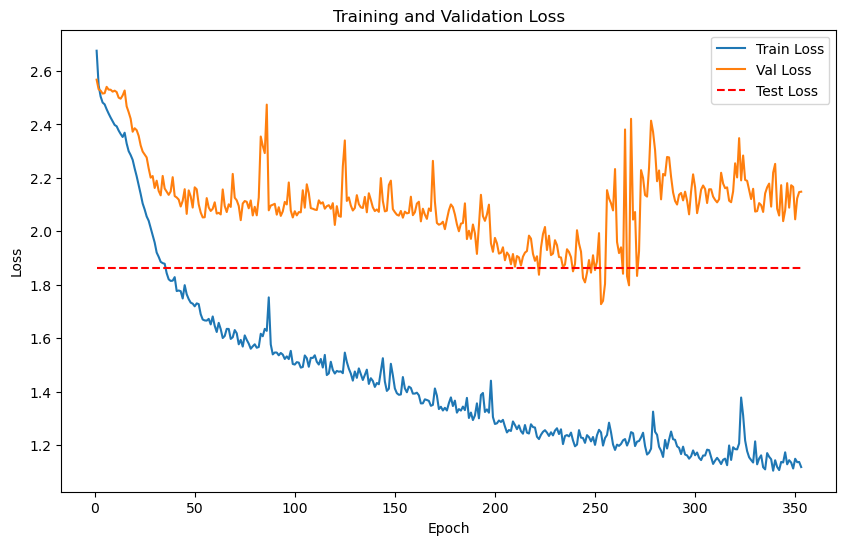

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 7.9541
    Batch [2/2], Train Loss: 8.0393
Epoch [1/2000], Avg Train Loss: 7.9967
Epoch [1/2000], Avg Val Loss: 4.9877
Validation loss improved from inf to 4.9877. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 7.6452
    Batch [2/2], Train Loss: 7.9240
Epoch [2/2000], Avg Train Loss: 7.7846
Epoch [2/2000], Avg Val Loss: 4.9373
Validation loss improved from 4.9877 to 4.9373. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.8382
    Batch [2/2], Train Loss: 7.7485
Epoch [3/2000], Avg Train Loss: 7.7934
Epoch [3/2000], Avg Val Loss: 4.8874
Validation loss improved from 4.9373 to 4.8874. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.7063
    Batch [2/2], Train Loss: 7.5078
Epoch [4/2000], Avg Train Loss: 7.6071
Epoch [4/2000], Avg Val Loss: 4.8398
Validation loss improved from 4.8874 to 4.8398. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

    Batch [1/2], Train Loss: 7.1960
    Batch [2/2], Train Loss: 7.2635
Epoch [10/2000], Avg Train Loss: 7.2297
Epoch [10/2000], Avg Val Loss: 4.5686
Validation loss improved from 4.6118 to 4.5686. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 6.9583
    Batch [2/2], Train Loss: 7.0230
Epoch [11/2000], Avg Train Loss: 6.9907
Epoch [11/2000], Avg Val Loss: 4.5265
Validation loss improved from 4.5686 to 4.5265. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 7.1178
    Batch [2/2], Train Loss: 6.9356
Epoch [12/2000], Avg Train Loss: 7.0267
Epoch [12/2000], Avg Val Loss: 4.4858
Validation loss improved from 4.5265 to 4.4858. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.8022
    Batch [2/2], Train Loss: 6.9679
Epoch [13/2000], Avg Train Loss: 6.8851
Epoch [13/2000], Avg Val Loss: 4.4461
Validation loss improved from 4.4858 to 4.4461. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 6.7775
    Batch [2/2], Train Loss: 6.6200
Epoch [15/2000], Avg Train Loss: 6.6987
Epoch [15/2000], Avg Val Loss: 4.3700
Validation loss improved from 4.4076 to 4.3700. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.8276
    Batch [2/2], Train Loss: 6.7355
Epoch [16/2000], Avg Train Loss: 6.7815
Epoch [16/2000], Avg Val Loss: 4.3331
Validation loss improved from 4.3700 to 4.3331. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.7024
    Batch [2/2], Train Loss: 6.5544
Epoch [17/2000], Avg Train Loss: 6.6284
Epoch [17/2000], Avg Val Loss: 4.2969
Validation loss improved from 4.3331 to 4.2969. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 6.4771
    Batch [2/2], Train Loss: 6.4984
Epoch [18/2000], Avg Train Loss: 6.4877
Epoch [18/2000], Avg Val Loss: 4.2625
Validation loss improved from 4.2969 to 4.2625. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 6.3242
    Batch [2/2], Train Loss: 6.2590
Epoch [23/2000], Avg Train Loss: 6.2916
Epoch [23/2000], Avg Val Loss: 4.1099
Validation loss improved from 4.1377 to 4.1099. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 6.2969
    Batch [2/2], Train Loss: 6.2248
Epoch [24/2000], Avg Train Loss: 6.2608
Epoch [24/2000], Avg Val Loss: 4.0830
Validation loss improved from 4.1099 to 4.0830. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 6.2686
    Batch [2/2], Train Loss: 6.1564
Epoch [25/2000], Avg Train Loss: 6.2125
Epoch [25/2000], Avg Val Loss: 4.0573
Validation loss improved from 4.0830 to 4.0573. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 6.0564
    Batch [2/2], Train Loss: 5.9981
Epoch [26/2000], Avg Train Loss: 6.0273
Epoch [26/2000], Avg Val Loss: 4.0333
Validation loss improved from 4.0573 to 4.0333. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.9975
Epoch [32/2000], Avg Train Loss: 5.9611
Epoch [32/2000], Avg Val Loss: 3.9158
Validation loss improved from 3.9323 to 3.9158. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.8596
    Batch [2/2], Train Loss: 5.8600
Epoch [33/2000], Avg Train Loss: 5.8598
Epoch [33/2000], Avg Val Loss: 3.9004
Validation loss improved from 3.9158 to 3.9004. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.8591
    Batch [2/2], Train Loss: 5.8184
Epoch [34/2000], Avg Train Loss: 5.8388
Epoch [34/2000], Avg Val Loss: 3.8862
Validation loss improved from 3.9004 to 3.8862. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.8497
    Batch [2/2], Train Loss: 5.9733
Epoch [35/2000], Avg Train Loss: 5.9115
Epoch [35/2000], Avg Val Loss: 3.8730
Validation loss improved from 3.8862 to 3.8730. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.7882


    Batch [2/2], Train Loss: 5.7948
Epoch [36/2000], Avg Train Loss: 5.7915
Epoch [36/2000], Avg Val Loss: 3.8609
Validation loss improved from 3.8730 to 3.8609. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.7363
    Batch [2/2], Train Loss: 5.7880
Epoch [37/2000], Avg Train Loss: 5.7621
Epoch [37/2000], Avg Val Loss: 3.8496
Validation loss improved from 3.8609 to 3.8496. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.7816
    Batch [2/2], Train Loss: 5.7156
Epoch [38/2000], Avg Train Loss: 5.7486
Epoch [38/2000], Avg Val Loss: 3.8392
Validation loss improved from 3.8496 to 3.8392. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 5.8298
    Batch [2/2], Train Loss: 5.6965
Epoch [39/2000], Avg Train Loss: 5.7632
Epoch [39/2000], Avg Val Loss: 3.8295
Validation loss improved from 3.8392 to 3.8295. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 5.6845
    Batch [2

    Batch [2/2], Train Loss: 5.5586
Epoch [46/2000], Avg Train Loss: 5.5949
Epoch [46/2000], Avg Val Loss: 3.7794
Validation loss improved from 3.7851 to 3.7794. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.6115
    Batch [2/2], Train Loss: 5.6242
Epoch [47/2000], Avg Train Loss: 5.6178
Epoch [47/2000], Avg Val Loss: 3.7741
Validation loss improved from 3.7794 to 3.7741. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 5.5223
    Batch [2/2], Train Loss: 5.6140
Epoch [48/2000], Avg Train Loss: 5.5682
Epoch [48/2000], Avg Val Loss: 3.7692
Validation loss improved from 3.7741 to 3.7692. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 5.5871
    Batch [2/2], Train Loss: 5.5270
Epoch [49/2000], Avg Train Loss: 5.5571
Epoch [49/2000], Avg Val Loss: 3.7646
Validation loss improved from 3.7692 to 3.7646. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 5.5530
    Batch [2

    Batch [1/2], Train Loss: 5.4033
    Batch [2/2], Train Loss: 5.4559
Epoch [56/2000], Avg Train Loss: 5.4296
Epoch [56/2000], Avg Val Loss: 3.7403
Validation loss improved from 3.7433 to 3.7403. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 5.3783
    Batch [2/2], Train Loss: 5.4604
Epoch [57/2000], Avg Train Loss: 5.4193
Epoch [57/2000], Avg Val Loss: 3.7377
Validation loss improved from 3.7403 to 3.7377. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 5.4780
    Batch [2/2], Train Loss: 5.4543
Epoch [58/2000], Avg Train Loss: 5.4661
Epoch [58/2000], Avg Val Loss: 3.7351
Validation loss improved from 3.7377 to 3.7351. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 5.3939
    Batch [2/2], Train Loss: 5.3834
Epoch [59/2000], Avg Train Loss: 5.3887
Epoch [59/2000], Avg Val Loss: 3.7327
Validation loss improved from 3.7351 to 3.7327. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.3674
Epoch [68/2000], Avg Train Loss: 5.3398
Epoch [68/2000], Avg Val Loss: 3.7147
Validation loss improved from 3.7163 to 3.7147. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 5.2967
    Batch [2/2], Train Loss: 5.3326
Epoch [69/2000], Avg Train Loss: 5.3146
Epoch [69/2000], Avg Val Loss: 3.7133
Validation loss improved from 3.7147 to 3.7133. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 5.3109
    Batch [2/2], Train Loss: 5.3448
Epoch [70/2000], Avg Train Loss: 5.3279
Epoch [70/2000], Avg Val Loss: 3.7118
Validation loss improved from 3.7133 to 3.7118. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 5.3023
    Batch [2/2], Train Loss: 5.3498
Epoch [71/2000], Avg Train Loss: 5.3260
Epoch [71/2000], Avg Val Loss: 3.7104
Validation loss improved from 3.7118 to 3.7104. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 5.3570
    Batch [2

    Batch [2/2], Train Loss: 5.2854
Epoch [78/2000], Avg Train Loss: 5.2866
Epoch [78/2000], Avg Val Loss: 3.7016
Validation loss improved from 3.7028 to 3.7016. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 5.2982
    Batch [2/2], Train Loss: 5.2669
Epoch [79/2000], Avg Train Loss: 5.2826
Epoch [79/2000], Avg Val Loss: 3.7005
Validation loss improved from 3.7016 to 3.7005. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 5.2595
    Batch [2/2], Train Loss: 5.3181
Epoch [80/2000], Avg Train Loss: 5.2888
Epoch [80/2000], Avg Val Loss: 3.6994
Validation loss improved from 3.7005 to 3.6994. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 5.2849
    Batch [2/2], Train Loss: 5.2883
Epoch [81/2000], Avg Train Loss: 5.2866
Epoch [81/2000], Avg Val Loss: 3.6984
Validation loss improved from 3.6994 to 3.6984. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 5.3074
    Batch [2

    Batch [1/2], Train Loss: 5.2176
    Batch [2/2], Train Loss: 5.1799
Epoch [91/2000], Avg Train Loss: 5.1987
Epoch [91/2000], Avg Val Loss: 3.6880
Validation loss improved from 3.6890 to 3.6880. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 5.2242
    Batch [2/2], Train Loss: 5.2567
Epoch [92/2000], Avg Train Loss: 5.2404
Epoch [92/2000], Avg Val Loss: 3.6870
Validation loss improved from 3.6880 to 3.6870. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 5.1799
    Batch [2/2], Train Loss: 5.2725
Epoch [93/2000], Avg Train Loss: 5.2262
Epoch [93/2000], Avg Val Loss: 3.6860
Validation loss improved from 3.6870 to 3.6860. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 5.2641
    Batch [2/2], Train Loss: 5.2197
Epoch [94/2000], Avg Train Loss: 5.2419
Epoch [94/2000], Avg Val Loss: 3.6849
Validation loss improved from 3.6860 to 3.6849. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.1978
    Batch [2/2], Train Loss: 5.1964
Epoch [99/2000], Avg Train Loss: 5.1971
Epoch [99/2000], Avg Val Loss: 3.6799
Validation loss improved from 3.6808 to 3.6799. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 5.1936
    Batch [2/2], Train Loss: 5.1911
Epoch [100/2000], Avg Train Loss: 5.1923
Epoch [100/2000], Avg Val Loss: 3.6790
Validation loss improved from 3.6799 to 3.6790. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 5.1961
    Batch [2/2], Train Loss: 5.2316
Epoch [101/2000], Avg Train Loss: 5.2139
Epoch [101/2000], Avg Val Loss: 3.6783
Validation loss improved from 3.6790 to 3.6783. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 5.1609
    Batch [2/2], Train Loss: 5.1837
Epoch [102/2000], Avg Train Loss: 5.1723
Epoch [102/2000], Avg Val Loss: 3.6776
Validation loss improved from 3.6783 to 3.6776. Saving model...

LOG: Epoch [103/2000] - Training
  

    Batch [1/2], Train Loss: 5.2276
    Batch [2/2], Train Loss: 5.1578
Epoch [113/2000], Avg Train Loss: 5.1927
Epoch [113/2000], Avg Val Loss: 3.6708
Validation loss improved from 3.6715 to 3.6708. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 5.1371
    Batch [2/2], Train Loss: 5.2056
Epoch [114/2000], Avg Train Loss: 5.1713
Epoch [114/2000], Avg Val Loss: 3.6702
Validation loss improved from 3.6708 to 3.6702. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 5.1561
    Batch [2/2], Train Loss: 5.1599
Epoch [115/2000], Avg Train Loss: 5.1580
Epoch [115/2000], Avg Val Loss: 3.6696
Validation loss improved from 3.6702 to 3.6696. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 5.1198
    Batch [2/2], Train Loss: 5.1470
Epoch [116/2000], Avg Train Loss: 5.1334
Epoch [116/2000], Avg Val Loss: 3.6689
Validation loss improved from 3.6696 to 3.6689. Saving model...

LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 5.1779
    Batch [2/2], Train Loss: 5.1332
Epoch [120/2000], Avg Train Loss: 5.1556
Epoch [120/2000], Avg Val Loss: 3.6662
Validation loss improved from 3.6670 to 3.6662. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 5.0993
    Batch [2/2], Train Loss: 5.1030
Epoch [121/2000], Avg Train Loss: 5.1012
Epoch [121/2000], Avg Val Loss: 3.6655
Validation loss improved from 3.6662 to 3.6655. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 5.1455
    Batch [2/2], Train Loss: 5.1325
Epoch [122/2000], Avg Train Loss: 5.1390
Epoch [122/2000], Avg Val Loss: 3.6648
Validation loss improved from 3.6655 to 3.6648. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 5.1360
    Batch [2/2], Train Loss: 5.1301
Epoch [123/2000], Avg Train Loss: 5.1331
Epoch [123/2000], Avg Val Loss: 3.6641
Validation loss improved from 3.6648 to 3.6641. Saving model...

LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 5.0828
    Batch [2/2], Train Loss: 5.0874
Epoch [134/2000], Avg Train Loss: 5.0851
Epoch [134/2000], Avg Val Loss: 3.6571
Validation loss improved from 3.6578 to 3.6571. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 5.1380
    Batch [2/2], Train Loss: 5.1214
Epoch [135/2000], Avg Train Loss: 5.1297
Epoch [135/2000], Avg Val Loss: 3.6564
Validation loss improved from 3.6571 to 3.6564. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 5.1444
    Batch [2/2], Train Loss: 5.0752
Epoch [136/2000], Avg Train Loss: 5.1098
Epoch [136/2000], Avg Val Loss: 3.6556
Validation loss improved from 3.6564 to 3.6556. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 5.0876
    Batch [2/2], Train Loss: 5.0536
Epoch [137/2000], Avg Train Loss: 5.0706
Epoch [137/2000], Avg Val Loss: 3.6547
Validation loss improved from 3.6556 to 3.6547. Saving model...

LOG: Epoch [138/2000] - Training


    Batch [2/2], Train Loss: 5.1215
Epoch [141/2000], Avg Train Loss: 5.1026
Epoch [141/2000], Avg Val Loss: 3.6522
Validation loss improved from 3.6528 to 3.6522. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 5.1087
    Batch [2/2], Train Loss: 5.0949
Epoch [142/2000], Avg Train Loss: 5.1018
Epoch [142/2000], Avg Val Loss: 3.6516
Validation loss improved from 3.6522 to 3.6516. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 5.1208
    Batch [2/2], Train Loss: 5.0741
Epoch [143/2000], Avg Train Loss: 5.0975
Epoch [143/2000], Avg Val Loss: 3.6511
Validation loss improved from 3.6516 to 3.6511. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 5.1051
    Batch [2/2], Train Loss: 5.0906
Epoch [144/2000], Avg Train Loss: 5.0979
Epoch [144/2000], Avg Val Loss: 3.6506
Validation loss improved from 3.6511 to 3.6506. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 5.1072


    Batch [1/2], Train Loss: 5.0369
    Batch [2/2], Train Loss: 4.9970
Epoch [155/2000], Avg Train Loss: 5.0169
Epoch [155/2000], Avg Val Loss: 3.6442
Validation loss improved from 3.6448 to 3.6442. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 5.0545
    Batch [2/2], Train Loss: 5.0198
Epoch [156/2000], Avg Train Loss: 5.0372
Epoch [156/2000], Avg Val Loss: 3.6436
Validation loss improved from 3.6442 to 3.6436. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 5.0426
    Batch [2/2], Train Loss: 5.0417
Epoch [157/2000], Avg Train Loss: 5.0422
Epoch [157/2000], Avg Val Loss: 3.6430
Validation loss improved from 3.6436 to 3.6430. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 5.0467
    Batch [2/2], Train Loss: 5.0472
Epoch [158/2000], Avg Train Loss: 5.0470
Epoch [158/2000], Avg Val Loss: 3.6424
Validation loss improved from 3.6430 to 3.6424. Saving model...

LOG: Epoch [159/2000] - Training


    Batch [2/2], Train Loss: 5.0190
Epoch [163/2000], Avg Train Loss: 5.0270
Epoch [163/2000], Avg Val Loss: 3.6386
Validation loss improved from 3.6393 to 3.6386. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 5.0126
    Batch [2/2], Train Loss: 5.0431
Epoch [164/2000], Avg Train Loss: 5.0278
Epoch [164/2000], Avg Val Loss: 3.6379
Validation loss improved from 3.6386 to 3.6379. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 5.0359
    Batch [2/2], Train Loss: 5.0617
Epoch [165/2000], Avg Train Loss: 5.0488
Epoch [165/2000], Avg Val Loss: 3.6371
Validation loss improved from 3.6379 to 3.6371. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.9919
    Batch [2/2], Train Loss: 5.0314
Epoch [166/2000], Avg Train Loss: 5.0117
Epoch [166/2000], Avg Val Loss: 3.6365
Validation loss improved from 3.6371 to 3.6365. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 5.0118


    Batch [1/2], Train Loss: 4.9925
    Batch [2/2], Train Loss: 4.9781
Epoch [177/2000], Avg Train Loss: 4.9853
Epoch [177/2000], Avg Val Loss: 3.6289
Validation loss improved from 3.6296 to 3.6289. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 4.9313
    Batch [2/2], Train Loss: 5.0138
Epoch [178/2000], Avg Train Loss: 4.9726
Epoch [178/2000], Avg Val Loss: 3.6284
Validation loss improved from 3.6289 to 3.6284. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 5.0088
    Batch [2/2], Train Loss: 5.0570
Epoch [179/2000], Avg Train Loss: 5.0329
Epoch [179/2000], Avg Val Loss: 3.6277
Validation loss improved from 3.6284 to 3.6277. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 4.9664
    Batch [2/2], Train Loss: 4.9944
Epoch [180/2000], Avg Train Loss: 4.9804
Epoch [180/2000], Avg Val Loss: 3.6270
Validation loss improved from 3.6277 to 3.6270. Saving model...

LOG: Epoch [181/2000] - Training


    Batch [2/2], Train Loss: 5.0118
Epoch [186/2000], Avg Train Loss: 4.9865
Epoch [186/2000], Avg Val Loss: 3.6231
Validation loss improved from 3.6237 to 3.6231. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 4.9894
    Batch [2/2], Train Loss: 4.9760
Epoch [187/2000], Avg Train Loss: 4.9827
Epoch [187/2000], Avg Val Loss: 3.6223
Validation loss improved from 3.6231 to 3.6223. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 5.0119
    Batch [2/2], Train Loss: 4.9746
Epoch [188/2000], Avg Train Loss: 4.9933
Epoch [188/2000], Avg Val Loss: 3.6214
Validation loss improved from 3.6223 to 3.6214. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 4.9692
    Batch [2/2], Train Loss: 4.9715
Epoch [189/2000], Avg Train Loss: 4.9704
Epoch [189/2000], Avg Val Loss: 3.6203
Validation loss improved from 3.6214 to 3.6203. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 5.0468


    Batch [2/2], Train Loss: 4.9614
Epoch [197/2000], Avg Train Loss: 4.9798
Epoch [197/2000], Avg Val Loss: 3.6111
Validation loss improved from 3.6121 to 3.6111. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 4.9596
    Batch [2/2], Train Loss: 4.9772
Epoch [198/2000], Avg Train Loss: 4.9684
Epoch [198/2000], Avg Val Loss: 3.6101
Validation loss improved from 3.6111 to 3.6101. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 4.9732
    Batch [2/2], Train Loss: 4.9824
Epoch [199/2000], Avg Train Loss: 4.9778
Epoch [199/2000], Avg Val Loss: 3.6090
Validation loss improved from 3.6101 to 3.6090. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 4.9757
    Batch [2/2], Train Loss: 4.9539
Epoch [200/2000], Avg Train Loss: 4.9648
Epoch [200/2000], Avg Val Loss: 3.6078
Validation loss improved from 3.6090 to 3.6078. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 4.9205


    Batch [1/2], Train Loss: 4.9472
    Batch [2/2], Train Loss: 4.9854
Epoch [211/2000], Avg Train Loss: 4.9663
Epoch [211/2000], Avg Val Loss: 3.5984
Validation loss improved from 3.5994 to 3.5984. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 4.9237
    Batch [2/2], Train Loss: 4.9460
Epoch [212/2000], Avg Train Loss: 4.9348
Epoch [212/2000], Avg Val Loss: 3.5973
Validation loss improved from 3.5984 to 3.5973. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 4.9786
    Batch [2/2], Train Loss: 4.8991
Epoch [213/2000], Avg Train Loss: 4.9388
Epoch [213/2000], Avg Val Loss: 3.5960
Validation loss improved from 3.5973 to 3.5960. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 4.9623
    Batch [2/2], Train Loss: 4.9468
Epoch [214/2000], Avg Train Loss: 4.9546
Epoch [214/2000], Avg Val Loss: 3.5947
Validation loss improved from 3.5960 to 3.5947. Saving model...

LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 4.8939
    Batch [2/2], Train Loss: 4.8960
Epoch [221/2000], Avg Train Loss: 4.8949
Epoch [221/2000], Avg Val Loss: 3.5855
Validation loss improved from 3.5865 to 3.5855. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 4.8870
    Batch [2/2], Train Loss: 4.9748
Epoch [222/2000], Avg Train Loss: 4.9309
Epoch [222/2000], Avg Val Loss: 3.5848
Validation loss improved from 3.5855 to 3.5848. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 4.8681
    Batch [2/2], Train Loss: 4.9150
Epoch [223/2000], Avg Train Loss: 4.8915
Epoch [223/2000], Avg Val Loss: 3.5843
Validation loss improved from 3.5848 to 3.5843. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 4.8793
    Batch [2/2], Train Loss: 4.9449
Epoch [224/2000], Avg Train Loss: 4.9121
Epoch [224/2000], Avg Val Loss: 3.5838
Validation loss improved from 3.5843 to 3.5838. Saving model...

LOG: Epoch [225/2000] - Training


    Batch [2/2], Train Loss: 4.8809
Epoch [234/2000], Avg Train Loss: 4.9115
Epoch [234/2000], Avg Val Loss: 3.5752
Validation loss improved from 3.5763 to 3.5752. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 4.8599
    Batch [2/2], Train Loss: 4.8117
Epoch [235/2000], Avg Train Loss: 4.8358
Epoch [235/2000], Avg Val Loss: 3.5741
Validation loss improved from 3.5752 to 3.5741. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 4.8371
    Batch [2/2], Train Loss: 4.9148
Epoch [236/2000], Avg Train Loss: 4.8759
Epoch [236/2000], Avg Val Loss: 3.5731
Validation loss improved from 3.5741 to 3.5731. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 4.9200
    Batch [2/2], Train Loss: 4.9391
Epoch [237/2000], Avg Train Loss: 4.9296
Epoch [237/2000], Avg Val Loss: 3.5720
Validation loss improved from 3.5731 to 3.5720. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 4.9017


    Batch [2/2], Train Loss: 4.9392
Epoch [243/2000], Avg Train Loss: 4.9234
Epoch [243/2000], Avg Val Loss: 3.5661
Validation loss improved from 3.5668 to 3.5661. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.8779
    Batch [2/2], Train Loss: 4.8630
Epoch [244/2000], Avg Train Loss: 4.8704
Epoch [244/2000], Avg Val Loss: 3.5652
Validation loss improved from 3.5661 to 3.5652. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.8274
    Batch [2/2], Train Loss: 4.8628
Epoch [245/2000], Avg Train Loss: 4.8451
Epoch [245/2000], Avg Val Loss: 3.5643
Validation loss improved from 3.5652 to 3.5643. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 4.8617
    Batch [2/2], Train Loss: 4.9340
Epoch [246/2000], Avg Train Loss: 4.8979
Epoch [246/2000], Avg Val Loss: 3.5634
Validation loss improved from 3.5643 to 3.5634. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 4.8688


    Batch [2/2], Train Loss: 4.8872
Epoch [256/2000], Avg Train Loss: 4.8577
Epoch [256/2000], Avg Val Loss: 3.5549
Validation loss improved from 3.5557 to 3.5549. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 4.8448
    Batch [2/2], Train Loss: 4.8393
Epoch [257/2000], Avg Train Loss: 4.8420
Epoch [257/2000], Avg Val Loss: 3.5536
Validation loss improved from 3.5549 to 3.5536. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 4.8712
    Batch [2/2], Train Loss: 4.8254
Epoch [258/2000], Avg Train Loss: 4.8483
Epoch [258/2000], Avg Val Loss: 3.5525
Validation loss improved from 3.5536 to 3.5525. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 4.8362
    Batch [2/2], Train Loss: 4.8960
Epoch [259/2000], Avg Train Loss: 4.8661
Epoch [259/2000], Avg Val Loss: 3.5516
Validation loss improved from 3.5525 to 3.5516. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 4.8096


    Batch [2/2], Train Loss: 4.8275
Epoch [266/2000], Avg Train Loss: 4.8349
Epoch [266/2000], Avg Val Loss: 3.5455
Validation loss improved from 3.5461 to 3.5455. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 4.8370
    Batch [2/2], Train Loss: 4.8749
Epoch [267/2000], Avg Train Loss: 4.8560
Epoch [267/2000], Avg Val Loss: 3.5447
Validation loss improved from 3.5455 to 3.5447. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 4.8293
    Batch [2/2], Train Loss: 4.8091
Epoch [268/2000], Avg Train Loss: 4.8192
Epoch [268/2000], Avg Val Loss: 3.5439
Validation loss improved from 3.5447 to 3.5439. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 4.8527
    Batch [2/2], Train Loss: 4.8070
Epoch [269/2000], Avg Train Loss: 4.8298
Epoch [269/2000], Avg Val Loss: 3.5430
Validation loss improved from 3.5439 to 3.5430. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 4.8407


    Batch [1/2], Train Loss: 4.7861
    Batch [2/2], Train Loss: 4.7593
Epoch [280/2000], Avg Train Loss: 4.7727
Epoch [280/2000], Avg Val Loss: 3.5313
Validation loss improved from 3.5322 to 3.5313. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 4.7707
    Batch [2/2], Train Loss: 4.8660
Epoch [281/2000], Avg Train Loss: 4.8184
Epoch [281/2000], Avg Val Loss: 3.5307
Validation loss improved from 3.5313 to 3.5307. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 4.8362
    Batch [2/2], Train Loss: 4.8103
Epoch [282/2000], Avg Train Loss: 4.8233
Epoch [282/2000], Avg Val Loss: 3.5301
Validation loss improved from 3.5307 to 3.5301. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 4.8005
    Batch [2/2], Train Loss: 4.7781
Epoch [283/2000], Avg Train Loss: 4.7893
Epoch [283/2000], Avg Val Loss: 3.5295
Validation loss improved from 3.5301 to 3.5295. Saving model...

LOG: Epoch [284/2000] - Training


    Batch [2/2], Train Loss: 4.7765
Epoch [291/2000], Avg Train Loss: 4.7819
Epoch [291/2000], Avg Val Loss: 3.5249
Validation loss improved from 3.5257 to 3.5249. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 4.7659
    Batch [2/2], Train Loss: 4.7752
Epoch [292/2000], Avg Train Loss: 4.7705
Epoch [292/2000], Avg Val Loss: 3.5238
Validation loss improved from 3.5249 to 3.5238. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 4.8069
    Batch [2/2], Train Loss: 4.8463
Epoch [293/2000], Avg Train Loss: 4.8266
Epoch [293/2000], Avg Val Loss: 3.5226
Validation loss improved from 3.5238 to 3.5226. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 4.7802
    Batch [2/2], Train Loss: 4.7772
Epoch [294/2000], Avg Train Loss: 4.7787
Epoch [294/2000], Avg Val Loss: 3.5215
Validation loss improved from 3.5226 to 3.5215. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 4.7342


    Batch [1/2], Train Loss: 4.7639
    Batch [2/2], Train Loss: 4.8281
Epoch [303/2000], Avg Train Loss: 4.7960
Epoch [303/2000], Avg Val Loss: 3.5163
Validation loss improved from 3.5166 to 3.5163. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 4.7927
    Batch [2/2], Train Loss: 4.7628
Epoch [304/2000], Avg Train Loss: 4.7777
Epoch [304/2000], Avg Val Loss: 3.5159
Validation loss improved from 3.5163 to 3.5159. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 4.8240
    Batch [2/2], Train Loss: 4.8227
Epoch [305/2000], Avg Train Loss: 4.8234
Epoch [305/2000], Avg Val Loss: 3.5152
Validation loss improved from 3.5159 to 3.5152. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 4.7896
    Batch [2/2], Train Loss: 4.6901
Epoch [306/2000], Avg Train Loss: 4.7398
Epoch [306/2000], Avg Val Loss: 3.5147
Validation loss improved from 3.5152 to 3.5147. Saving model...

LOG: Epoch [307/2000] - Training


Epoch [313/2000], Avg Val Loss: 3.5126
Validation loss improved from 3.5131 to 3.5126. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 4.8016
    Batch [2/2], Train Loss: 4.7805
Epoch [314/2000], Avg Train Loss: 4.7911
Epoch [314/2000], Avg Val Loss: 3.5121
Validation loss improved from 3.5126 to 3.5121. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 4.7592
    Batch [2/2], Train Loss: 4.7640
Epoch [315/2000], Avg Train Loss: 4.7616
Epoch [315/2000], Avg Val Loss: 3.5116
Validation loss improved from 3.5121 to 3.5116. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 4.7706
    Batch [2/2], Train Loss: 4.8497
Epoch [316/2000], Avg Train Loss: 4.8101
Epoch [316/2000], Avg Val Loss: 3.5113
Validation loss improved from 3.5116 to 3.5113. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 4.8292
    Batch [2/2], Train Loss: 4.7483
Epoch [317/2000], Avg Train Loss: 4.7887


    Batch [2/2], Train Loss: 4.7578
Epoch [324/2000], Avg Train Loss: 4.7862
Epoch [324/2000], Avg Val Loss: 3.5048
Validation loss improved from 3.5058 to 3.5048. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 4.7335
    Batch [2/2], Train Loss: 4.7909
Epoch [325/2000], Avg Train Loss: 4.7622
Epoch [325/2000], Avg Val Loss: 3.5036
Validation loss improved from 3.5048 to 3.5036. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 4.7358
    Batch [2/2], Train Loss: 4.7358
Epoch [326/2000], Avg Train Loss: 4.7358
Epoch [326/2000], Avg Val Loss: 3.5025
Validation loss improved from 3.5036 to 3.5025. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 4.7866
    Batch [2/2], Train Loss: 4.7566
Epoch [327/2000], Avg Train Loss: 4.7716
Epoch [327/2000], Avg Val Loss: 3.5018
Validation loss improved from 3.5025 to 3.5018. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 4.7996


    Batch [2/2], Train Loss: 4.8011
Epoch [337/2000], Avg Train Loss: 4.7600
Epoch [337/2000], Avg Val Loss: 3.4966
Validation loss did not improve. Patience: 2/100

LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 4.7071
    Batch [2/2], Train Loss: 4.7607
Epoch [338/2000], Avg Train Loss: 4.7339
Epoch [338/2000], Avg Val Loss: 3.4964
Validation loss did not improve. Patience: 3/100

LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 4.7462
    Batch [2/2], Train Loss: 4.7802
Epoch [339/2000], Avg Train Loss: 4.7632
Epoch [339/2000], Avg Val Loss: 3.4962
Validation loss did not improve. Patience: 4/100

LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 4.6887
    Batch [2/2], Train Loss: 4.7848
Epoch [340/2000], Avg Train Loss: 4.7368
Epoch [340/2000], Avg Val Loss: 3.4959
Validation loss improved from 3.4962 to 3.4959. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 4.7728
    Batch [2/2], Train Loss: 4.7518
Epoch [34

Epoch [347/2000], Avg Val Loss: 3.4880
Validation loss improved from 3.4895 to 3.4880. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 4.7380
    Batch [2/2], Train Loss: 4.7083
Epoch [348/2000], Avg Train Loss: 4.7231
Epoch [348/2000], Avg Val Loss: 3.4869
Validation loss improved from 3.4880 to 3.4869. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 4.6902
    Batch [2/2], Train Loss: 4.6979
Epoch [349/2000], Avg Train Loss: 4.6940
Epoch [349/2000], Avg Val Loss: 3.4863
Validation loss improved from 3.4869 to 3.4863. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 4.7804
    Batch [2/2], Train Loss: 4.7846
Epoch [350/2000], Avg Train Loss: 4.7825
Epoch [350/2000], Avg Val Loss: 3.4859
Validation loss improved from 3.4863 to 3.4859. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 4.7861
    Batch [2/2], Train Loss: 4.7004
Epoch [351/2000], Avg Train Loss: 4.7432


    Batch [2/2], Train Loss: 4.7267
Epoch [359/2000], Avg Train Loss: 4.7192
Epoch [359/2000], Avg Val Loss: 3.4862
Validation loss did not improve. Patience: 8/100

LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 4.7343
    Batch [2/2], Train Loss: 4.7226
Epoch [360/2000], Avg Train Loss: 4.7285
Epoch [360/2000], Avg Val Loss: 3.4856
Validation loss improved from 3.4857 to 3.4856. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 4.6501
    Batch [2/2], Train Loss: 4.7127
Epoch [361/2000], Avg Train Loss: 4.6814
Epoch [361/2000], Avg Val Loss: 3.4850
Validation loss improved from 3.4856 to 3.4850. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 4.7021
    Batch [2/2], Train Loss: 4.7058
Epoch [362/2000], Avg Train Loss: 4.7040
Epoch [362/2000], Avg Val Loss: 3.4846
Validation loss improved from 3.4850 to 3.4846. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 4.6925
    Batch [2/2]

    Batch [2/2], Train Loss: 4.7269
Epoch [369/2000], Avg Train Loss: 4.7348
Epoch [369/2000], Avg Val Loss: 3.4784
Validation loss improved from 3.4792 to 3.4784. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 4.7398
    Batch [2/2], Train Loss: 4.6725
Epoch [370/2000], Avg Train Loss: 4.7062
Epoch [370/2000], Avg Val Loss: 3.4777
Validation loss improved from 3.4784 to 3.4777. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 4.7273
    Batch [2/2], Train Loss: 4.6662
Epoch [371/2000], Avg Train Loss: 4.6967
Epoch [371/2000], Avg Val Loss: 3.4769
Validation loss improved from 3.4777 to 3.4769. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 4.7127
    Batch [2/2], Train Loss: 4.6929
Epoch [372/2000], Avg Train Loss: 4.7028
Epoch [372/2000], Avg Val Loss: 3.4764
Validation loss improved from 3.4769 to 3.4764. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 4.6921


    Batch [1/2], Train Loss: 4.7068
    Batch [2/2], Train Loss: 4.6215
Epoch [382/2000], Avg Train Loss: 4.6641
Epoch [382/2000], Avg Val Loss: 3.4725
Validation loss improved from 3.4727 to 3.4725. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 4.6897
    Batch [2/2], Train Loss: 4.7274
Epoch [383/2000], Avg Train Loss: 4.7085
Epoch [383/2000], Avg Val Loss: 3.4719
Validation loss improved from 3.4725 to 3.4719. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 4.6867
    Batch [2/2], Train Loss: 4.7205
Epoch [384/2000], Avg Train Loss: 4.7036
Epoch [384/2000], Avg Val Loss: 3.4716
Validation loss improved from 3.4719 to 3.4716. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 4.6996
    Batch [2/2], Train Loss: 4.7557
Epoch [385/2000], Avg Train Loss: 4.7277
Epoch [385/2000], Avg Val Loss: 3.4712
Validation loss improved from 3.4716 to 3.4712. Saving model...

LOG: Epoch [386/2000] - Training


    Batch [2/2], Train Loss: 4.6583
Epoch [392/2000], Avg Train Loss: 4.6599
Epoch [392/2000], Avg Val Loss: 3.4669
Validation loss did not improve. Patience: 2/100

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 4.7022
    Batch [2/2], Train Loss: 4.6459
Epoch [393/2000], Avg Train Loss: 4.6741
Epoch [393/2000], Avg Val Loss: 3.4669
Validation loss did not improve. Patience: 3/100

LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 4.7454
    Batch [2/2], Train Loss: 4.6858
Epoch [394/2000], Avg Train Loss: 4.7156
Epoch [394/2000], Avg Val Loss: 3.4672
Validation loss did not improve. Patience: 4/100

LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 4.6723
    Batch [2/2], Train Loss: 4.6919
Epoch [395/2000], Avg Train Loss: 4.6821
Epoch [395/2000], Avg Val Loss: 3.4679
Validation loss did not improve. Patience: 5/100

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 4.6536
    Batch [2/2], Train Loss: 4.7160
Epoch [396/2000], Avg Tr

    Batch [1/2], Train Loss: 4.7105
    Batch [2/2], Train Loss: 4.7352
Epoch [403/2000], Avg Train Loss: 4.7228
Epoch [403/2000], Avg Val Loss: 3.4653
Validation loss improved from 3.4662 to 3.4653. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 4.6680
    Batch [2/2], Train Loss: 4.6938
Epoch [404/2000], Avg Train Loss: 4.6809
Epoch [404/2000], Avg Val Loss: 3.4646
Validation loss improved from 3.4653 to 3.4646. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 4.6536
    Batch [2/2], Train Loss: 4.6386
Epoch [405/2000], Avg Train Loss: 4.6461
Epoch [405/2000], Avg Val Loss: 3.4640
Validation loss improved from 3.4646 to 3.4640. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 4.6813
    Batch [2/2], Train Loss: 4.6949
Epoch [406/2000], Avg Train Loss: 4.6881
Epoch [406/2000], Avg Val Loss: 3.4637
Validation loss improved from 3.4640 to 3.4637. Saving model...

LOG: Epoch [407/2000] - Training


    Batch [2/2], Train Loss: 4.6498
Epoch [415/2000], Avg Train Loss: 4.6478
Epoch [415/2000], Avg Val Loss: 3.4593
Validation loss improved from 3.4599 to 3.4593. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 4.6841
    Batch [2/2], Train Loss: 4.6613
Epoch [416/2000], Avg Train Loss: 4.6727
Epoch [416/2000], Avg Val Loss: 3.4586
Validation loss improved from 3.4593 to 3.4586. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 4.6450
    Batch [2/2], Train Loss: 4.6969
Epoch [417/2000], Avg Train Loss: 4.6709
Epoch [417/2000], Avg Val Loss: 3.4578
Validation loss improved from 3.4586 to 3.4578. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 4.6384
    Batch [2/2], Train Loss: 4.6506
Epoch [418/2000], Avg Train Loss: 4.6445
Epoch [418/2000], Avg Val Loss: 3.4569
Validation loss improved from 3.4578 to 3.4569. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 4.5851


    Batch [1/2], Train Loss: 4.6539


    Batch [2/2], Train Loss: 4.6591
Epoch [425/2000], Avg Train Loss: 4.6565
Epoch [425/2000], Avg Val Loss: 3.4524
Validation loss improved from 3.4528 to 3.4524. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 4.6652
    Batch [2/2], Train Loss: 4.7350
Epoch [426/2000], Avg Train Loss: 4.7001
Epoch [426/2000], Avg Val Loss: 3.4525
Validation loss did not improve. Patience: 1/100

LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 4.5885
    Batch [2/2], Train Loss: 4.6553
Epoch [427/2000], Avg Train Loss: 4.6219
Epoch [427/2000], Avg Val Loss: 3.4522
Validation loss improved from 3.4524 to 3.4522. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 4.5711
    Batch [2/2], Train Loss: 4.6644
Epoch [428/2000], Avg Train Loss: 4.6178
Epoch [428/2000], Avg Val Loss: 3.4518
Validation loss improved from 3.4522 to 3.4518. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 4.6668
    Batch [2/2]

    Batch [2/2], Train Loss: 4.6707
Epoch [448/2000], Avg Train Loss: 4.6456
Epoch [448/2000], Avg Val Loss: 3.4464
Validation loss improved from 3.4467 to 3.4464. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 4.5784
    Batch [2/2], Train Loss: 4.6049
Epoch [449/2000], Avg Train Loss: 4.5917
Epoch [449/2000], Avg Val Loss: 3.4461
Validation loss improved from 3.4464 to 3.4461. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 4.6105
    Batch [2/2], Train Loss: 4.5509
Epoch [450/2000], Avg Train Loss: 4.5807
Epoch [450/2000], Avg Val Loss: 3.4455
Validation loss improved from 3.4461 to 3.4455. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 4.6028
    Batch [2/2], Train Loss: 4.6593
Epoch [451/2000], Avg Train Loss: 4.6311
Epoch [451/2000], Avg Val Loss: 3.4452
Validation loss improved from 3.4455 to 3.4452. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 4.7141


    Batch [1/2], Train Loss: 4.5665
    Batch [2/2], Train Loss: 4.6508
Epoch [472/2000], Avg Train Loss: 4.6086
Epoch [472/2000], Avg Val Loss: 3.4429
Validation loss did not improve. Patience: 15/100

LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 4.6092
    Batch [2/2], Train Loss: 4.6003
Epoch [473/2000], Avg Train Loss: 4.6047
Epoch [473/2000], Avg Val Loss: 3.4411
Validation loss improved from 3.4425 to 3.4411. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 4.6141
    Batch [2/2], Train Loss: 4.5726
Epoch [474/2000], Avg Train Loss: 4.5933
Epoch [474/2000], Avg Val Loss: 3.4396
Validation loss improved from 3.4411 to 3.4396. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 4.5879
    Batch [2/2], Train Loss: 4.5513
Epoch [475/2000], Avg Train Loss: 4.5696
Epoch [475/2000], Avg Val Loss: 3.4386
Validation loss improved from 3.4396 to 3.4386. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/2

    Batch [1/2], Train Loss: 4.5772
    Batch [2/2], Train Loss: 4.5819
Epoch [494/2000], Avg Train Loss: 4.5795
Epoch [494/2000], Avg Val Loss: 3.4404
Validation loss did not improve. Patience: 16/100

LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 4.6292
    Batch [2/2], Train Loss: 4.5747
Epoch [495/2000], Avg Train Loss: 4.6019
Epoch [495/2000], Avg Val Loss: 3.4399
Validation loss did not improve. Patience: 17/100

LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 4.5291
    Batch [2/2], Train Loss: 4.5504
Epoch [496/2000], Avg Train Loss: 4.5397
Epoch [496/2000], Avg Val Loss: 3.4385
Validation loss did not improve. Patience: 18/100

LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 4.6388
    Batch [2/2], Train Loss: 4.5436
Epoch [497/2000], Avg Train Loss: 4.5912
Epoch [497/2000], Avg Val Loss: 3.4369
Validation loss improved from 3.4375 to 3.4369. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 4.6327
    Ba

    Batch [2/2], Train Loss: 4.5735
Epoch [516/2000], Avg Train Loss: 4.5753
Epoch [516/2000], Avg Val Loss: 3.4305
Validation loss did not improve. Patience: 10/100

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 4.5615
    Batch [2/2], Train Loss: 4.5460
Epoch [517/2000], Avg Train Loss: 4.5538
Epoch [517/2000], Avg Val Loss: 3.4310
Validation loss did not improve. Patience: 11/100

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 4.5065
    Batch [2/2], Train Loss: 4.5604
Epoch [518/2000], Avg Train Loss: 4.5334
Epoch [518/2000], Avg Val Loss: 3.4322
Validation loss did not improve. Patience: 12/100

LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 4.6128
    Batch [2/2], Train Loss: 4.5891
Epoch [519/2000], Avg Train Loss: 4.6009
Epoch [519/2000], Avg Val Loss: 3.4328
Validation loss did not improve. Patience: 13/100

LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 4.4835
    Batch [2/2], Train Loss: 4.5290
Epoch [520/2000], Av

    Batch [2/2], Train Loss: 4.5685
Epoch [540/2000], Avg Train Loss: 4.5155
Epoch [540/2000], Avg Val Loss: 3.4304
Validation loss did not improve. Patience: 34/100

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 4.5602
    Batch [2/2], Train Loss: 4.5028
Epoch [541/2000], Avg Train Loss: 4.5315
Epoch [541/2000], Avg Val Loss: 3.4304
Validation loss did not improve. Patience: 35/100

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 4.5351
    Batch [2/2], Train Loss: 4.5470
Epoch [542/2000], Avg Train Loss: 4.5411
Epoch [542/2000], Avg Val Loss: 3.4300
Validation loss did not improve. Patience: 36/100

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 4.5687
    Batch [2/2], Train Loss: 4.4743
Epoch [543/2000], Avg Train Loss: 4.5215
Epoch [543/2000], Avg Val Loss: 3.4303
Validation loss did not improve. Patience: 37/100

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 4.5559
    Batch [2/2], Train Loss: 4.5095
Epoch [544/2000], Av

    Batch [1/2], Train Loss: 4.5462
    Batch [2/2], Train Loss: 4.4710
Epoch [562/2000], Avg Train Loss: 4.5086
Epoch [562/2000], Avg Val Loss: 3.4337
Validation loss did not improve. Patience: 56/100

LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 4.5036
    Batch [2/2], Train Loss: 4.5228
Epoch [563/2000], Avg Train Loss: 4.5132
Epoch [563/2000], Avg Val Loss: 3.4327
Validation loss did not improve. Patience: 57/100

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 4.4884
    Batch [2/2], Train Loss: 4.5260
Epoch [564/2000], Avg Train Loss: 4.5072
Epoch [564/2000], Avg Val Loss: 3.4317
Validation loss did not improve. Patience: 58/100

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 4.5055
    Batch [2/2], Train Loss: 4.4884
Epoch [565/2000], Avg Train Loss: 4.4970
Epoch [565/2000], Avg Val Loss: 3.4314
Validation loss did not improve. Patience: 59/100

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 4.4854
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 4.4964
    Batch [2/2], Train Loss: 4.4820
Epoch [586/2000], Avg Train Loss: 4.4892
Epoch [586/2000], Avg Val Loss: 3.4258
Validation loss improved from 3.4268 to 3.4258. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 4.4739
    Batch [2/2], Train Loss: 4.4423
Epoch [587/2000], Avg Train Loss: 4.4581
Epoch [587/2000], Avg Val Loss: 3.4245
Validation loss improved from 3.4258 to 3.4245. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 4.4995
    Batch [2/2], Train Loss: 4.5125
Epoch [588/2000], Avg Train Loss: 4.5060
Epoch [588/2000], Avg Val Loss: 3.4241
Validation loss improved from 3.4245 to 3.4241. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 4.4852
    Batch [2/2], Train Loss: 4.4524
Epoch [589/2000], Avg Train Loss: 4.4688
Epoch [589/2000], Avg Val Loss: 3.4246
Validation loss did not improve. Patience: 1/100

LOG: Epoch [590/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 4.4601
Epoch [607/2000], Avg Train Loss: 4.4592
Epoch [607/2000], Avg Val Loss: 3.4332
Validation loss did not improve. Patience: 19/100

LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 4.5035
    Batch [2/2], Train Loss: 4.4548
Epoch [608/2000], Avg Train Loss: 4.4792
Epoch [608/2000], Avg Val Loss: 3.4346
Validation loss did not improve. Patience: 20/100

LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 4.4868
    Batch [2/2], Train Loss: 4.5235
Epoch [609/2000], Avg Train Loss: 4.5051
Epoch [609/2000], Avg Val Loss: 3.4361
Validation loss did not improve. Patience: 21/100

LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 4.5115
    Batch [2/2], Train Loss: 4.5343
Epoch [610/2000], Avg Train Loss: 4.5229
Epoch [610/2000], Avg Val Loss: 3.4362
Validation loss did not improve. Patience: 22/100

LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 4.4428
    Batch [2/2], Train Loss: 4.4268
Epoch [611/2000], Av

    Batch [2/2], Train Loss: 4.4893
Epoch [631/2000], Avg Train Loss: 4.4563
Epoch [631/2000], Avg Val Loss: 3.4331
Validation loss did not improve. Patience: 43/100

LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 4.5060
    Batch [2/2], Train Loss: 4.4783
Epoch [632/2000], Avg Train Loss: 4.4921
Epoch [632/2000], Avg Val Loss: 3.4325
Validation loss did not improve. Patience: 44/100

LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 4.4646
    Batch [2/2], Train Loss: 4.4679
Epoch [633/2000], Avg Train Loss: 4.4662
Epoch [633/2000], Avg Val Loss: 3.4318
Validation loss did not improve. Patience: 45/100

LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 4.5137
    Batch [2/2], Train Loss: 4.5061
Epoch [634/2000], Avg Train Loss: 4.5099
Epoch [634/2000], Avg Val Loss: 3.4304
Validation loss did not improve. Patience: 46/100

LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 4.4436
    Batch [2/2], Train Loss: 4.4292
Epoch [635/2000], Av

    Batch [1/2], Train Loss: 4.3937
    Batch [2/2], Train Loss: 4.4686
Epoch [655/2000], Avg Train Loss: 4.4311
Epoch [655/2000], Avg Val Loss: 3.4252
Validation loss did not improve. Patience: 67/100

LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 4.4794
    Batch [2/2], Train Loss: 4.4811
Epoch [656/2000], Avg Train Loss: 4.4802
Epoch [656/2000], Avg Val Loss: 3.4239
Validation loss improved from 3.4241 to 3.4239. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/2], Train Loss: 4.4885
    Batch [2/2], Train Loss: 4.4144
Epoch [657/2000], Avg Train Loss: 4.4514
Epoch [657/2000], Avg Val Loss: 3.4220
Validation loss improved from 3.4239 to 3.4220. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 4.4231
    Batch [2/2], Train Loss: 4.4267
Epoch [658/2000], Avg Train Loss: 4.4249
Epoch [658/2000], Avg Val Loss: 3.4202
Validation loss improved from 3.4220 to 3.4202. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/2

    Batch [1/2], Train Loss: 4.3948
    Batch [2/2], Train Loss: 4.4241
Epoch [678/2000], Avg Train Loss: 4.4095
Epoch [678/2000], Avg Val Loss: 3.4223
Validation loss did not improve. Patience: 19/100

LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 4.4979
    Batch [2/2], Train Loss: 4.4181
Epoch [679/2000], Avg Train Loss: 4.4580
Epoch [679/2000], Avg Val Loss: 3.4218
Validation loss did not improve. Patience: 20/100

LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 4.4115
    Batch [2/2], Train Loss: 4.4125
Epoch [680/2000], Avg Train Loss: 4.4120
Epoch [680/2000], Avg Val Loss: 3.4211
Validation loss did not improve. Patience: 21/100

LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 4.4592
    Batch [2/2], Train Loss: 4.3707
Epoch [681/2000], Avg Train Loss: 4.4149
Epoch [681/2000], Avg Val Loss: 3.4211
Validation loss did not improve. Patience: 22/100

LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 4.3851
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 4.3863
    Batch [2/2], Train Loss: 4.3693
Epoch [701/2000], Avg Train Loss: 4.3778
Epoch [701/2000], Avg Val Loss: 3.4250
Validation loss did not improve. Patience: 42/100

LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 4.4170
    Batch [2/2], Train Loss: 4.4022
Epoch [702/2000], Avg Train Loss: 4.4096
Epoch [702/2000], Avg Val Loss: 3.4249
Validation loss did not improve. Patience: 43/100

LOG: Epoch [703/2000] - Training
    Batch [1/2], Train Loss: 4.4317
    Batch [2/2], Train Loss: 4.4392
Epoch [703/2000], Avg Train Loss: 4.4354
Epoch [703/2000], Avg Val Loss: 3.4250
Validation loss did not improve. Patience: 44/100

LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 4.4886
    Batch [2/2], Train Loss: 4.4353
Epoch [704/2000], Avg Train Loss: 4.4620
Epoch [704/2000], Avg Val Loss: 3.4243
Validation loss did not improve. Patience: 45/100

LOG: Epoch [705/2000] - Training
    Batch [1/2], Train Loss: 4.3987
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 4.4425
Epoch [723/2000], Avg Train Loss: 4.4075
Epoch [723/2000], Avg Val Loss: 3.4199
Validation loss did not improve. Patience: 9/100

LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 4.4199
    Batch [2/2], Train Loss: 4.3672
Epoch [724/2000], Avg Train Loss: 4.3935
Epoch [724/2000], Avg Val Loss: 3.4179
Validation loss improved from 3.4189 to 3.4179. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 4.3591
    Batch [2/2], Train Loss: 4.4651
Epoch [725/2000], Avg Train Loss: 4.4121
Epoch [725/2000], Avg Val Loss: 3.4157
Validation loss improved from 3.4179 to 3.4157. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/2], Train Loss: 4.3843
    Batch [2/2], Train Loss: 4.4195
Epoch [726/2000], Avg Train Loss: 4.4019
Epoch [726/2000], Avg Val Loss: 3.4132
Validation loss improved from 3.4157 to 3.4132. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/2], Train Loss: 4.4365
    Batch [2/2]

    Batch [1/2], Train Loss: 4.4190
    Batch [2/2], Train Loss: 4.3934
Epoch [746/2000], Avg Train Loss: 4.4062
Epoch [746/2000], Avg Val Loss: 3.4245
Validation loss did not improve. Patience: 17/100

LOG: Epoch [747/2000] - Training
    Batch [1/2], Train Loss: 4.3394
    Batch [2/2], Train Loss: 4.4466
Epoch [747/2000], Avg Train Loss: 4.3930
Epoch [747/2000], Avg Val Loss: 3.4228
Validation loss did not improve. Patience: 18/100

LOG: Epoch [748/2000] - Training
    Batch [1/2], Train Loss: 4.3280
    Batch [2/2], Train Loss: 4.4183
Epoch [748/2000], Avg Train Loss: 4.3732
Epoch [748/2000], Avg Val Loss: 3.4227
Validation loss did not improve. Patience: 19/100

LOG: Epoch [749/2000] - Training
    Batch [1/2], Train Loss: 4.3471
    Batch [2/2], Train Loss: 4.4553
Epoch [749/2000], Avg Train Loss: 4.4012
Epoch [749/2000], Avg Val Loss: 3.4229
Validation loss did not improve. Patience: 20/100

LOG: Epoch [750/2000] - Training
    Batch [1/2], Train Loss: 4.4886
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 4.3640
Epoch [769/2000], Avg Train Loss: 4.3654
Epoch [769/2000], Avg Val Loss: 3.4281
Validation loss did not improve. Patience: 40/100

LOG: Epoch [770/2000] - Training
    Batch [1/2], Train Loss: 4.3408
    Batch [2/2], Train Loss: 4.3729
Epoch [770/2000], Avg Train Loss: 4.3568
Epoch [770/2000], Avg Val Loss: 3.4274
Validation loss did not improve. Patience: 41/100

LOG: Epoch [771/2000] - Training
    Batch [1/2], Train Loss: 4.3214
    Batch [2/2], Train Loss: 4.4371
Epoch [771/2000], Avg Train Loss: 4.3793
Epoch [771/2000], Avg Val Loss: 3.4271
Validation loss did not improve. Patience: 42/100

LOG: Epoch [772/2000] - Training
    Batch [1/2], Train Loss: 4.4046
    Batch [2/2], Train Loss: 4.3356
Epoch [772/2000], Avg Train Loss: 4.3701
Epoch [772/2000], Avg Val Loss: 3.4262
Validation loss did not improve. Patience: 43/100

LOG: Epoch [773/2000] - Training
    Batch [1/2], Train Loss: 4.3749
    Batch [2/2], Train Loss: 4.3329
Epoch [773/2000], Av

    Batch [2/2], Train Loss: 4.3765
Epoch [791/2000], Avg Train Loss: 4.3995
Epoch [791/2000], Avg Val Loss: 3.4377
Validation loss did not improve. Patience: 62/100

LOG: Epoch [792/2000] - Training
    Batch [1/2], Train Loss: 4.3501
    Batch [2/2], Train Loss: 4.3315
Epoch [792/2000], Avg Train Loss: 4.3408
Epoch [792/2000], Avg Val Loss: 3.4372
Validation loss did not improve. Patience: 63/100

LOG: Epoch [793/2000] - Training
    Batch [1/2], Train Loss: 4.3861
    Batch [2/2], Train Loss: 4.3208
Epoch [793/2000], Avg Train Loss: 4.3534
Epoch [793/2000], Avg Val Loss: 3.4372
Validation loss did not improve. Patience: 64/100

LOG: Epoch [794/2000] - Training
    Batch [1/2], Train Loss: 4.3992
    Batch [2/2], Train Loss: 4.3003
Epoch [794/2000], Avg Train Loss: 4.3497
Epoch [794/2000], Avg Val Loss: 3.4377
Validation loss did not improve. Patience: 65/100

LOG: Epoch [795/2000] - Training
    Batch [1/2], Train Loss: 4.3896
    Batch [2/2], Train Loss: 4.3387
Epoch [795/2000], Av

    Batch [1/2], Train Loss: 4.2985
    Batch [2/2], Train Loss: 4.3024
Epoch [815/2000], Avg Train Loss: 4.3004
Epoch [815/2000], Avg Val Loss: 3.4420
Validation loss did not improve. Patience: 86/100

LOG: Epoch [816/2000] - Training
    Batch [1/2], Train Loss: 4.3608
    Batch [2/2], Train Loss: 4.3379
Epoch [816/2000], Avg Train Loss: 4.3494
Epoch [816/2000], Avg Val Loss: 3.4425
Validation loss did not improve. Patience: 87/100

LOG: Epoch [817/2000] - Training
    Batch [1/2], Train Loss: 4.2515
    Batch [2/2], Train Loss: 4.3577
Epoch [817/2000], Avg Train Loss: 4.3046
Epoch [817/2000], Avg Val Loss: 3.4443
Validation loss did not improve. Patience: 88/100

LOG: Epoch [818/2000] - Training
    Batch [1/2], Train Loss: 4.3108
    Batch [2/2], Train Loss: 4.3222
Epoch [818/2000], Avg Train Loss: 4.3165
Epoch [818/2000], Avg Val Loss: 3.4453
Validation loss did not improve. Patience: 89/100

LOG: Epoch [819/2000] - Training
    Batch [1/2], Train Loss: 4.3555
    Batch [2/2], Tra

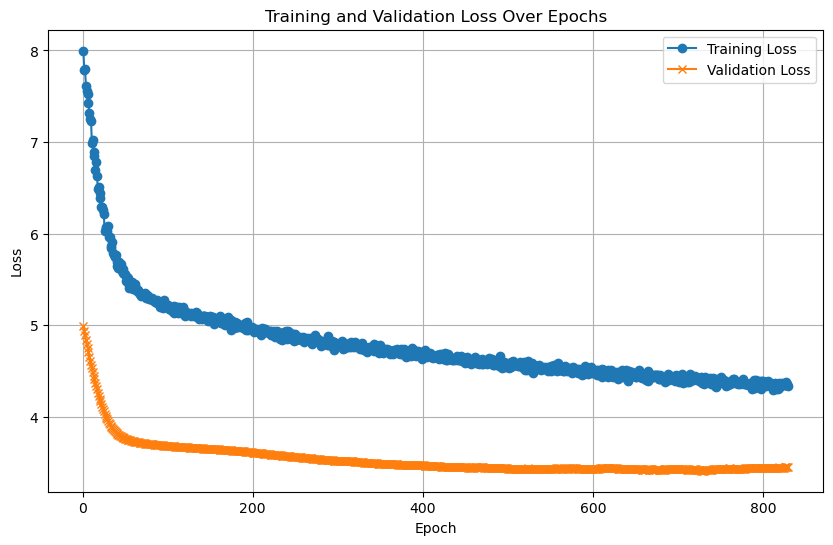

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/19], Loss: 8.0404

Test Loss: 5.8119


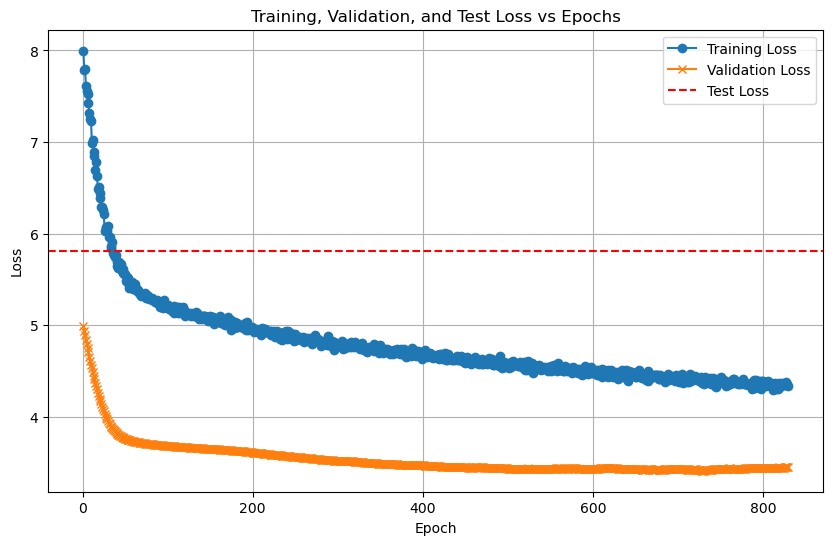

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 58.46%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       1.00      0.20      0.33         5
           2       0.27      0.60      0.38         5
           3       0.00      0.00      0.00         5
           4       0.50      0.40      0.44         5
           5       0.50      0.40      0.44         5
           6       0.57      0.80      0.67         5
           7       0.57      0.80      0.67         5
           8       1.00      1.00      1.00         5
           9       0.50      0.20      0.29         5
          10       1.00      1.00      1.00         5
          11       0.57      0.80      0.67         5
          12       0.80      0.80      0.80         5

    accuracy         

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8262  |  Val Loss: 2.6908
Validation loss improved from inf to 2.6908.
[Epoch 2/1000] Train Loss: 2.7404  |  Val Loss: 2.6610
Validation loss improved from 2.6908 to 2.6610.
[Epoch 3/1000] Train Loss: 2.6766  |  Val Loss: 2.6396
Validation loss improved from 2.6610 to 2.6396.


[Epoch 4/1000] Train Loss: 2.6318  |  Val Loss: 2.6233
Validation loss improved from 2.6396 to 2.6233.
[Epoch 5/1000] Train Loss: 2.5944  |  Val Loss: 2.6110
Validation loss improved from 2.6233 to 2.6110.
[Epoch 6/1000] Train Loss: 2.5693  |  Val Loss: 2.6040
Validation loss improved from 2.6110 to 2.6040.
[Epoch 7/1000] Train Loss: 2.5497  |  Val Loss: 2.5990
Validation loss improved from 2.6040 to 2.5990.
[Epoch 8/1000] Train Loss: 2.5309  |  Val Loss: 2.5950
Validation loss improved from 2.5990 to 2.5950.


[Epoch 9/1000] Train Loss: 2.5147  |  Val Loss: 2.5945
Validation loss improved from 2.5950 to 2.5945.
[Epoch 10/1000] Train Loss: 2.4992  |  Val Loss: 2.5951
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 11/1000] Train Loss: 2.4864  |  Val Loss: 2.5916
Validation loss improved from 2.5945 to 2.5916.


[Epoch 12/1000] Train Loss: 2.4763  |  Val Loss: 2.5875
Validation loss improved from 2.5916 to 2.5875.
[Epoch 13/1000] Train Loss: 2.4660  |  Val Loss: 2.5812
Validation loss improved from 2.5875 to 2.5812.
[Epoch 14/1000] Train Loss: 2.4554  |  Val Loss: 2.5742
Validation loss improved from 2.5812 to 2.5742.
[Epoch 15/1000] Train Loss: 2.4457  |  Val Loss: 2.5678
Validation loss improved from 2.5742 to 2.5678.
[Epoch 16/1000] Train Loss: 2.4360  |  Val Loss: 2.5590
Validation loss improved from 2.5678 to 2.5590.


[Epoch 17/1000] Train Loss: 2.4256  |  Val Loss: 2.5601
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 18/1000] Train Loss: 2.4157  |  Val Loss: 2.5657
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 19/1000] Train Loss: 2.4042  |  Val Loss: 2.5590
Validation loss improved from 2.5590 to 2.5590.
[Epoch 20/1000] Train Loss: 2.3939  |  Val Loss: 2.5574
Validation loss improved from 2.5590 to 2.5574.


[Epoch 21/1000] Train Loss: 2.3840  |  Val Loss: 2.5518
Validation loss improved from 2.5574 to 2.5518.
[Epoch 22/1000] Train Loss: 2.3738  |  Val Loss: 2.5489
Validation loss improved from 2.5518 to 2.5489.
[Epoch 23/1000] Train Loss: 2.3643  |  Val Loss: 2.5483
Validation loss improved from 2.5489 to 2.5483.
[Epoch 24/1000] Train Loss: 2.3552  |  Val Loss: 2.5422
Validation loss improved from 2.5483 to 2.5422.


[Epoch 25/1000] Train Loss: 2.3458  |  Val Loss: 2.5301
Validation loss improved from 2.5422 to 2.5301.
[Epoch 26/1000] Train Loss: 2.3359  |  Val Loss: 2.5337
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 2.3263  |  Val Loss: 2.5355
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 28/1000] Train Loss: 2.3174  |  Val Loss: 2.5228
Validation loss improved from 2.5301 to 2.5228.


[Epoch 29/1000] Train Loss: 2.3088  |  Val Loss: 2.5235
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 30/1000] Train Loss: 2.2995  |  Val Loss: 2.5278
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 31/1000] Train Loss: 2.2896  |  Val Loss: 2.5241
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 32/1000] Train Loss: 2.2798  |  Val Loss: 2.5162
Validation loss improved from 2.5228 to 2.5162.
[Epoch 33/1000] Train Loss: 2.2701  |  Val Loss: 2.5119
Validation loss improved from 2.5162 to 2.5119.
[Epoch 34/1000] Train Loss: 2.2606  |  Val Loss: 2.5055
Validation loss improved from 2.5119 to 2.5055.
[Epoch 35/1000] Train Loss: 2.2507  |  Val Loss: 2.5023
Validation loss improved from 2.5055 to 2.5023.


[Epoch 36/1000] Train Loss: 2.2406  |  Val Loss: 2.5137
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 2.2297  |  Val Loss: 2.5016
Validation loss improved from 2.5023 to 2.5016.
[Epoch 38/1000] Train Loss: 2.2186  |  Val Loss: 2.4968
Validation loss improved from 2.5016 to 2.4968.
[Epoch 39/1000] Train Loss: 2.2080  |  Val Loss: 2.4766
Validation loss improved from 2.4968 to 2.4766.


[Epoch 40/1000] Train Loss: 2.1975  |  Val Loss: 2.4814
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 2.1855  |  Val Loss: 2.4917
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 42/1000] Train Loss: 2.1761  |  Val Loss: 2.4950
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 43/1000] Train Loss: 2.1647  |  Val Loss: 2.4741
Validation loss improved from 2.4766 to 2.4741.
[Epoch 44/1000] Train Loss: 2.1519  |  Val Loss: 2.5199
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 2.1446  |  Val Loss: 2.4968
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 46/1000] Train Loss: 2.1293  |  Val Loss: 2.4639
Validation loss improved from 2.4741 to 2.4639.


[Epoch 47/1000] Train Loss: 2.1181  |  Val Loss: 2.4538
Validation loss improved from 2.4639 to 2.4538.
[Epoch 48/1000] Train Loss: 2.1041  |  Val Loss: 2.4755
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 2.0931  |  Val Loss: 2.4772
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 50/1000] Train Loss: 2.0817  |  Val Loss: 2.4431
Validation loss improved from 2.4538 to 2.4431.
[Epoch 51/1000] Train Loss: 2.0671  |  Val Loss: 2.4321
Validation loss improved from 2.4431 to 2.4321.
[Epoch 52/1000] Train Loss: 2.0569  |  Val Loss: 2.4309
Validation loss improved from 2.4321 to 2.4309.
[Epoch 53/1000] Train Loss: 2.0453  |  Val Loss: 2.4319
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 54/1000] Train Loss: 2.0332  |  Val Loss: 2.4467
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 55/1000] Train Loss: 2.0195  |  Val Loss: 2.4116
Validation loss improved from 2.4309 to 2.4116.
[Epoch 56/1000] Train Loss: 2.0042  |  Val Loss: 2.3880
Validation loss improved from 2.4116 to 2.3880.
[Epoch 57/1000] Train Loss: 1.9904  |  Val Loss: 2.3839
Validation loss improved from 2.3880 to 2.3839.
[Epoch 58/1000] Train Loss: 1.9782  |  Val Loss: 2.3934
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 59/1000] Train Loss: 1.9628  |  Val Loss: 2.3741
Validation loss improved from 2.3839 to 2.3741.
[Epoch 60/1000] Train Loss: 1.9501  |  Val Loss: 2.3573
Validation loss improved from 2.3741 to 2.3573.
[Epoch 61/1000] Train Loss: 1.9392  |  Val Loss: 2.3821
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 1.9233  |  Val Loss: 2.3627
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 63/1000] Train Loss: 1.9096  |  Val Loss: 2.3436
Validation loss improved from 2.3573 to 2.3436.
[Epoch 64/1000] Train Loss: 1.8965  |  Val Loss: 2.3377
Validation loss improved from 2.3436 to 2.3377.
[Epoch 65/1000] Train Loss: 1.8856  |  Val Loss: 2.3367
Validation loss improved from 2.3377 to 2.3367.
[Epoch 66/1000] Train Loss: 1.8766  |  Val Loss: 2.2853
Validation loss improved from 2.3367 to 2.2853.


[Epoch 67/1000] Train Loss: 1.8603  |  Val Loss: 2.3194
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 1.8470  |  Val Loss: 2.3296
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 69/1000] Train Loss: 1.8313  |  Val Loss: 2.3122
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 70/1000] Train Loss: 1.8196  |  Val Loss: 2.2932
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 71/1000] Train Loss: 1.8078  |  Val Loss: 2.3308
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 72/1000] Train Loss: 1.7944  |  Val Loss: 2.3017
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 73/1000] Train Loss: 1.7799  |  Val Loss: 2.2803
Validation loss improved from 2.2853 to 2.2803.
[Epoch 74/1000] Train Loss: 1.7671  |  Val Loss: 2.2770
Validation loss improved from 2.2803 to 2.2770.
[Epoch 75/1000] Train Loss: 1.7553  |  Val Loss: 2.2527
Validation loss improved from 2.2770 to 2.2527.
[Epoch 76/1000] Train Loss: 1.7417  |  Val Loss: 2.3082
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 77/1000] Train Loss: 1.7323  |  Val Loss: 2.2721
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 78/1000] Train Loss: 1.7183  |  Val Loss: 2.2539
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 79/1000] Train Loss: 1.7061  |  Val Loss: 2.2377
Validation loss improved from 2.2527 to 2.2377.
[Epoch 80/1000] Train Loss: 1.6921  |  Val Loss: 2.2402
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 81/1000] Train Loss: 1.6802  |  Val Loss: 2.2526
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 82/1000] Train Loss: 1.6666  |  Val Loss: 2.2592
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 83/1000] Train Loss: 1.6559  |  Val Loss: 2.2385
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 84/1000] Train Loss: 1.6433  |  Val Loss: 2.1866
Validation loss improved from 2.2377 to 2.1866.
[Epoch 85/1000] Train Loss: 1.6347  |  Val Loss: 2.2095
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 1.6194  |  Val Loss: 2.2302
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 1.6086  |  Val Loss: 2.2268
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 88/1000] Train Loss: 1.5954  |  Val Loss: 2.2132
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 89/1000] Train Loss: 1.5832  |  Val Loss: 2.2114
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 90/1000] Train Loss: 1.5724  |  Val Loss: 2.2111
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 91/1000] 

[Epoch 92/1000] Train Loss: 1.5504  |  Val Loss: 2.2106
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 93/1000] Train Loss: 1.5442  |  Val Loss: 2.2150
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 94/1000] Train Loss: 1.5316  |  Val Loss: 2.1817
Validation loss improved from 2.1826 to 2.1817.
[Epoch 95/1000] Train Loss: 1.5155  |  Val Loss: 2.1945
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 96/1000] Train Loss: 1.5040  |  Val Loss: 2.1929
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 1.4920  |  Val Loss: 2.1995
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 98/1000] Train Loss: 1.4813  |  Val Loss: 2.1925
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 99/1000] Train Loss: 1.4701  |  Val Loss: 2.2052
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 100/1000] Train Loss: 1.4593  |  Val Loss: 2.2096
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 101/1000] Train Loss: 1.4492  |  Val Loss: 2.2004
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 102/100

[Epoch 104/1000] Train Loss: 1.4173  |  Val Loss: 2.1812
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 105/1000] Train Loss: 1.4063  |  Val Loss: 2.1995
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 106/1000] Train Loss: 1.3970  |  Val Loss: 2.2361
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 107/1000] Train Loss: 1.3909  |  Val Loss: 2.1995
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 108/1000] Train Loss: 1.3824  |  Val Loss: 2.1575
Validation loss improved from 2.1710 to 2.1575.
[Epoch 109/1000] Train Loss: 1.3684  |  Val Loss: 2.2213
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 1.3598  |  Val Loss: 2.2092
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 111/1000] Train Loss: 1.3489  |  Val Loss: 2.1752
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 112/1000] Train Loss: 1.3426  |  Val Loss: 2.1727
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 117/1000] Train Loss: 1.2966  |  Val Loss: 2.2199
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 118/1000] Train Loss: 1.2888  |  Val Loss: 2.2060
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 119/1000] Train Loss: 1.2806  |  Val Loss: 2.1491
Validation loss improved from 2.1575 to 2.1491.
[Epoch 120/1000] Train Loss: 1.2714  |  Val Loss: 2.1580
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 121/1000] Train Loss: 1.2630  |  Val Loss: 2.1929
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 122/1000] Train Loss: 1.2583  |  Val Loss: 2.1856
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 123/1000] Train Loss: 1.2513  |  Val Loss: 2.1643
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 124/1000] Train Loss: 1.2413  |  Val Loss: 2.1269
Validation loss improved from 2.1491 to 2.1269.
[Epoch 125/1000] Train Loss: 1.2377  |  Val Loss: 2.1468
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1

[Epoch 129/1000] Train Loss: 1.2041  |  Val Loss: 2.1662
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 130/1000] Train Loss: 1.1965  |  Val Loss: 2.1756
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 131/1000] Train Loss: 1.1911  |  Val Loss: 2.1909
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 132/1000] Train Loss: 1.1833  |  Val Loss: 2.1746
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 133/1000] Train Loss: 1.1789  |  Val Loss: 2.1743
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 134/1000] Train Loss: 1.1735  |  Val Loss: 2.1727
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 135/1000] Train Loss: 1.1697  |  Val Loss: 2.0779
Validation loss improved from 2.1269 to 2.0779.
[Epoch 136/1000] Train Loss: 1.1732  |  Val Loss: 2.1193
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 137/1000] Train Loss: 1.1563  |  Val Loss: 2.1787
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch

[Epoch 139/1000] Train Loss: 1.1441  |  Val Loss: 2.1935
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 140/1000] Train Loss: 1.1363  |  Val Loss: 2.1871
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 141/1000] Train Loss: 1.1352  |  Val Loss: 2.1489
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 142/1000] Train Loss: 1.1303  |  Val Loss: 2.1586
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 143/1000] Train Loss: 1.1191  |  Val Loss: 2.1925
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 144/1000] Train Loss: 1.1133  |  Val Loss: 2.1990
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 145/1000] Train Loss: 1.1089  |  Val Loss: 2.2006
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 146/1000] Train Loss: 1.1042  |  Val Loss: 2.1726
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 147/1000] Train Loss: 1.0990  |  Val Loss: 2.1906
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 150/1000] Train Loss: 1.0822  |  Val Loss: 2.1967
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 151/1000] Train Loss: 1.0774  |  Val Loss: 2.2052
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 152/1000] Train Loss: 1.0769  |  Val Loss: 2.2126
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 153/1000] Train Loss: 1.0701  |  Val Loss: 2.2071
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 154/1000] Train Loss: 1.0633  |  Val Loss: 2.1934
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 155/1000] Train Loss: 1.0592  |  Val Loss: 2.2022
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 156/1000] Train Loss: 1.0545  |  Val Loss: 2.2132
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 157/1000] Train Loss: 1.0552  |  Val Loss: 2.2703
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 158/1000] Train Loss: 1.0494  |  Val Loss: 2.2379
!! Validation loss did NOT improve !! Patience:

[Epoch 163/1000] Train Loss: 1.0259  |  Val Loss: 2.2302
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 164/1000] Train Loss: 1.0186  |  Val Loss: 2.1986
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 165/1000] Train Loss: 1.0143  |  Val Loss: 2.2139
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 166/1000] Train Loss: 1.0126  |  Val Loss: 2.2343
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 167/1000] Train Loss: 1.0085  |  Val Loss: 2.1984
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 168/1000] Train Loss: 1.0033  |  Val Loss: 2.2257
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 169/1000] Train Loss: 1.0004  |  Val Loss: 2.2198
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 170/1000] Train Loss: 1.0001  |  Val Loss: 2.1777
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 171/1000] Train Loss: 0.9943  |  Val Loss: 2.2221
!! Validation loss did NOT improve !! Patience:

[Epoch 176/1000] Train Loss: 0.9727  |  Val Loss: 2.2296
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 177/1000] Train Loss: 0.9689  |  Val Loss: 2.2219
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 178/1000] Train Loss: 0.9653  |  Val Loss: 2.2243
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 179/1000] Train Loss: 0.9618  |  Val Loss: 2.2214
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 180/1000] Train Loss: 0.9657  |  Val Loss: 2.2494
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 181/1000] Train Loss: 0.9638  |  Val Loss: 2.2509
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 182/1000] Train Loss: 0.9525  |  Val Loss: 2.2116
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 183/1000] Train Loss: 0.9481  |  Val Loss: 2.2162
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 184/1000] Train Loss: 0.9453  |  Val Loss: 2.2340
!! Validation loss did NOT improve !! Patience:

[Epoch 187/1000] Train Loss: 0.9353  |  Val Loss: 2.2233
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 188/1000] Train Loss: 0.9331  |  Val Loss: 2.2331
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 189/1000] Train Loss: 0.9298  |  Val Loss: 2.2380
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 190/1000] Train Loss: 0.9318  |  Val Loss: 2.2368
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 191/1000] Train Loss: 0.9284  |  Val Loss: 2.2468
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 192/1000] Train Loss: 0.9206  |  Val Loss: 2.2259
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 193/1000] Train Loss: 0.9158  |  Val Loss: 2.2269
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 194/1000] Train Loss: 0.9145  |  Val Loss: 2.2146
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 195/1000] Train Loss: 0.9101  |  Val Loss: 2.2392
!! Validation loss did NOT improve !! Patience:

[Epoch 199/1000] Train Loss: 0.8954  |  Val Loss: 2.3012
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 200/1000] Train Loss: 0.8999  |  Val Loss: 2.2795
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 201/1000] Train Loss: 0.8917  |  Val Loss: 2.2193
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 202/1000] Train Loss: 0.8974  |  Val Loss: 2.2056
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 203/1000] Train Loss: 0.8875  |  Val Loss: 2.2387
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 204/1000] Train Loss: 0.8848  |  Val Loss: 2.2875
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 205/1000] Train Loss: 0.8829  |  Val Loss: 2.2417
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 206/1000] Train Loss: 0.8754  |  Val Loss: 2.2541
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 207/1000] Train Loss: 0.8757  |  Val Loss: 2.2868
!! Validation loss did NOT improve !! Patience:

[Epoch 210/1000] Train Loss: 0.8653  |  Val Loss: 2.2456
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 211/1000] Train Loss: 0.8614  |  Val Loss: 2.2642
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 212/1000] Train Loss: 0.8593  |  Val Loss: 2.2585
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 213/1000] Train Loss: 0.8561  |  Val Loss: 2.2558
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 214/1000] Train Loss: 0.8537  |  Val Loss: 2.2613
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 215/1000] Train Loss: 0.8504  |  Val Loss: 2.2717
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 216/1000] Train Loss: 0.8471  |  Val Loss: 2.2757
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 217/1000] Train Loss: 0.8476  |  Val Loss: 2.2688
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 218/1000] Train Loss: 0.8408  |  Val Loss: 2.2321
!! Validation loss did NOT improve !! Patience:

[Epoch 223/1000] Train Loss: 0.8318  |  Val Loss: 2.2558
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 224/1000] Train Loss: 0.8299  |  Val Loss: 2.2852
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 225/1000] Train Loss: 0.8241  |  Val Loss: 2.3033
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 226/1000] Train Loss: 0.8232  |  Val Loss: 2.2987
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 227/1000] Train Loss: 0.8241  |  Val Loss: 2.3115
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 228/1000] Train Loss: 0.8185  |  Val Loss: 2.2525
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 229/1000] Train Loss: 0.8234  |  Val Loss: 2.2593
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 230/1000] Train Loss: 0.8174  |  Val Loss: 2.2814
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 231/1000] Train Loss: 0.8149  |  Val Loss: 2.3055
!! Validation loss did NOT improve !! Patience:

[Epoch 235/1000] Train Loss: 0.8014  |  Val Loss: 2.3001
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 235 !!
No improvement for 100 epochs.


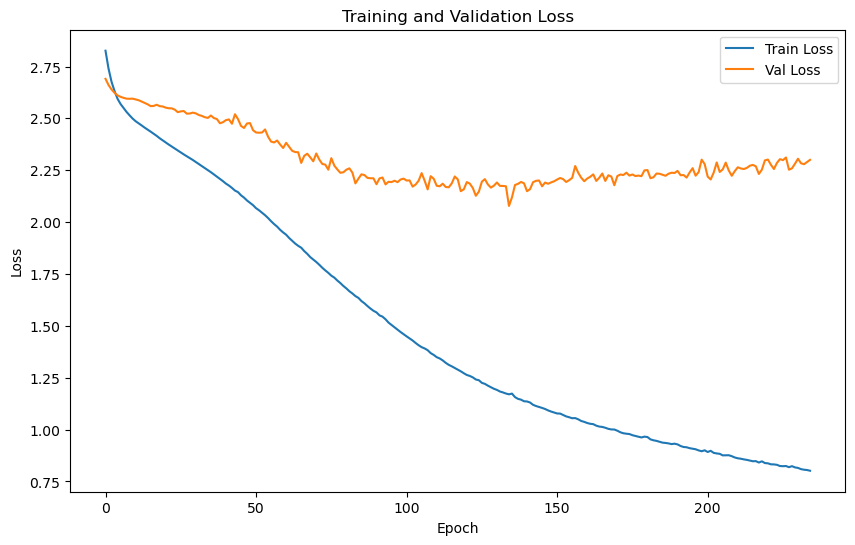

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.8867 | Test Accuracy: 62.15%


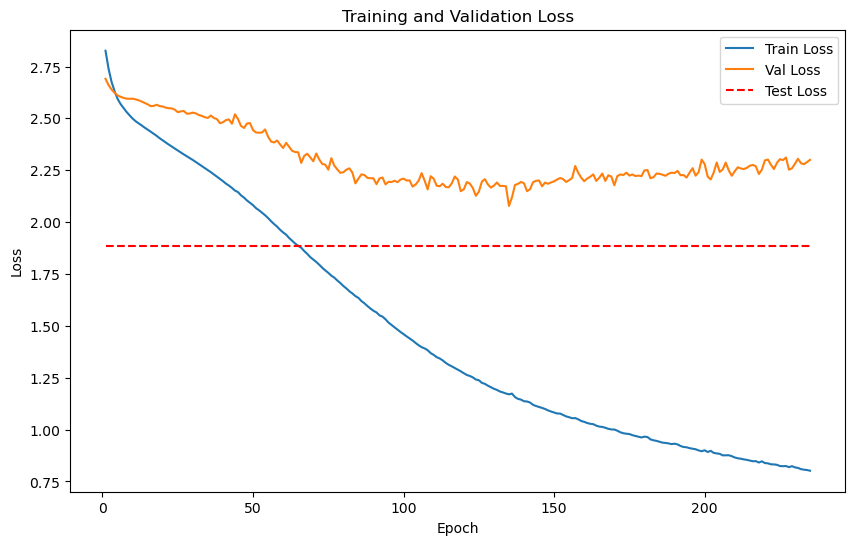

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.5241
    Batch [2/2], Train Loss: 0.5221
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5980
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5231, Avg Val Loss: 0.5490

Validation loss improved from inf to 0.5490. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.5202
    Batch [2/2], Train Loss: 0.5258
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5941
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5230, Avg Val Loss: 0.5471

Validation loss improved from 0.5490 to 0.5471. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.5222
    Batch [2/2], Train Loss: 0.5216
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5910
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5219, Avg Val Loss: 0.5455

Validation loss improved from 0.5471 to 0.5455. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.5239
    Batch [2/2], Train Loss: 0.5148
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5880
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5194, Avg Val Loss: 0.5440

Validation loss improved from 0.5455 to 0.5440. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.5205
    Batch [2/2], Train Loss: 0.5142
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5838
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5174, Avg Val Loss: 0.5419

Validation loss improved from 0.5440 to 0.5419. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.5175
    Batch [2/2], Train Loss: 0.5172
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5797
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5173, Avg Val Loss: 0.5399

Validation loss improved from 0.5419 to 0.5399. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.5170
    Batch [2/2], Train Loss: 0.5157
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5759
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5163, Avg Val Loss: 0.5380

Validation loss improved from 0.5399 to 0.5380. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.5123
    Batch [2/2], Train Loss: 0.5122
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5709
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5123, Avg Val Loss: 0.5355

Validation loss improved from 0.5380 to 0.5355. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.5107
    Batch [2/2], Train Loss: 0.5131
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5659
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5119, Avg Val Loss: 0.5330

Validation loss improved from 0.5355 to 0.5330. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.5104
    Batch [2/2], Train Loss: 0.5147
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5597
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5126, Avg Val Loss: 0.5299

Validation loss improved from 0.5330 to 0.5299. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.5081
    Batch [2/2], Train Loss: 0.5088
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5536
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5084, Avg Val Loss: 0.5268

Validation loss improved from 0.5299 to 0.5268. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.5120
    Batch [2/2], Train Loss: 0.5093
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.5477
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.5239

Validation loss improved from 0.5268 to 0.5239. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.5037


    Batch [2/2], Train Loss: 0.5084
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5421
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5211

Validation loss improved from 0.5239 to 0.5211. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.5068
    Batch [2/2], Train Loss: 0.5047
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5058, Avg Val Loss: 0.5182

Validation loss improved from 0.5211 to 0.5182. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.5110
    Batch [2/2], Train Loss: 0.5059
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5154

Validation loss improved from 0.5182 to 0.5154. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.5075


    Batch [2/2], Train Loss: 0.5055
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5065, Avg Val Loss: 0.5129

Validation loss improved from 0.5154 to 0.5129. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.5040
    Batch [2/2], Train Loss: 0.5035
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5037, Avg Val Loss: 0.5104

Validation loss improved from 0.5129 to 0.5104. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.5082
    Batch [2/2], Train Loss: 0.5083
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.5085

Validation loss improved from 0.5104 to 0.5085. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.5089


    Batch [2/2], Train Loss: 0.5078
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.5071

Validation loss improved from 0.5085 to 0.5071. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.5008


    Batch [2/2], Train Loss: 0.5008
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5056

Validation loss improved from 0.5071 to 0.5056. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.5037
    Batch [2/2], Train Loss: 0.5064
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5051, Avg Val Loss: 0.5047

Validation loss improved from 0.5056 to 0.5047. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.5045
    Batch [2/2], Train Loss: 0.4983
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5014, Avg Val Loss: 0.5037

Validation loss improved from 0.5047 to 0.5037. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.5043


    Batch [2/2], Train Loss: 0.5010
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5029

Validation loss improved from 0.5037 to 0.5029. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.5045


    Batch [2/2], Train Loss: 0.5019
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5032, Avg Val Loss: 0.5022

Validation loss improved from 0.5029 to 0.5022. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4994
    Batch [2/2], Train Loss: 0.4977
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5016

Validation loss improved from 0.5022 to 0.5016. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.5008


    Batch [2/2], Train Loss: 0.5039
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.5009

Validation loss improved from 0.5016 to 0.5009. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4999
    Batch [2/2], Train Loss: 0.5025
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5003

Validation loss improved from 0.5009 to 0.5003. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.4981


    Batch [2/2], Train Loss: 0.4997
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.4998

Validation loss improved from 0.5003 to 0.4998. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.5006


    Batch [2/2], Train Loss: 0.4943
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.4994

Validation loss improved from 0.4998 to 0.4994. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4956


    Batch [2/2], Train Loss: 0.4921
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.4989

Validation loss improved from 0.4994 to 0.4989. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.4954


    Batch [2/2], Train Loss: 0.4934
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4985

Validation loss improved from 0.4989 to 0.4985. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4973
    Batch [2/2], Train Loss: 0.4914
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4981

Validation loss improved from 0.4985 to 0.4981. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4941
    Batch [2/2], Train Loss: 0.4985
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.4978

Validation loss improved from 0.4981 to 0.4978. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4962
    Batch [2/2], Train Loss: 0.4919
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.4975

Validation loss improved from 0.4978 to 0.4975. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4949
    Batch [2/2], Train Loss: 0.4996
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.4972

Validation loss improved from 0.4975 to 0.4972. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4919
    Batch [2/2], Train Loss: 0.4937
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4970

Validation loss improved from 0.4972 to 0.4970. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.4920


    Batch [2/2], Train Loss: 0.4937
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4967

Validation loss improved from 0.4970 to 0.4967. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4969


    Batch [2/2], Train Loss: 0.4919
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4966

Validation loss improved from 0.4967 to 0.4966. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4930
    Batch [2/2], Train Loss: 0.4902
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4964

Validation loss improved from 0.4966 to 0.4964. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.4936
    Batch [2/2], Train Loss: 0.4884
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4960

Validation loss improved from 0.4964 to 0.4960. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.4894


    Batch [2/2], Train Loss: 0.4885
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4957

Validation loss improved from 0.4960 to 0.4957. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.4927


    Batch [2/2], Train Loss: 0.4910
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4955

Validation loss improved from 0.4957 to 0.4955. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.4928


    Batch [2/2], Train Loss: 0.4880
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4953

Validation loss improved from 0.4955 to 0.4953. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4906
    Batch [2/2], Train Loss: 0.4854
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4952

Validation loss improved from 0.4953 to 0.4952. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4886
    Batch [2/2], Train Loss: 0.4879
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4882
    Batch [2/2], Train Loss: 0.4908
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4952 to 0.4951. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.4926
    Batch [2/2], Train Loss: 0.4898
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.4862
    Batch [2/2], Train Loss: 0.4917
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.4874


    Batch [2/2], Train Loss: 0.4864
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.4886


    Batch [2/2], Train Loss: 0.4871
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4950

Validation loss improved from 0.4951 to 0.4950. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.4816


    Batch [2/2], Train Loss: 0.4837
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4947

Validation loss improved from 0.4950 to 0.4947. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.4864
    Batch [2/2], Train Loss: 0.4877
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4946

Validation loss improved from 0.4947 to 0.4946. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.4912
    Batch [2/2], Train Loss: 0.4891
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4946

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.4887
    Batch [2/2], Train Loss: 0.4930
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4890
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4945

Validation loss improved from 0.4946 to 0.4945. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.4880
    Batch [2/2], Train Loss: 0.4863
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4944

Validation loss improved from 0.4945 to 0.4944. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.4877
    Batch [2/2], Train Loss: 0.4882
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4945

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.4837
    Batch [2/2], Train Loss: 0.4800
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4945

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.4870
    Batch [2/2], Train Loss: 0.4860
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4942

Validation loss improved from 0.4944 to 0.4942. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.4873
    Batch [2/2], Train Loss: 0.4801
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4941

Validation loss improved from 0.4942 to 0.4941. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.4860
    Batch [2/2], Train Loss: 0.4855
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4939

Validation loss improved from 0.4941 to 0.4939. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.4836
    Batch [2/2], Train Loss: 0.4799
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4936

Validation loss improved from 0.4939 to 0.4936. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.4845
    Batch [2/2], Train Loss: 0.4924
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.4783


    Batch [2/2], Train Loss: 0.4824
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4937

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.4788


    Batch [2/2], Train Loss: 0.4856
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4937

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.4863


    Batch [2/2], Train Loss: 0.4893
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4936

Validation loss improved from 0.4936 to 0.4936. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.4831


    Batch [2/2], Train Loss: 0.4842
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4935

Validation loss improved from 0.4936 to 0.4935. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.4827


    Batch [2/2], Train Loss: 0.4781
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4935

Validation loss improved from 0.4935 to 0.4935. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.4837


    Batch [2/2], Train Loss: 0.4803
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4866
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4933

Validation loss improved from 0.4935 to 0.4933. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.4821
    Batch [2/2], Train Loss: 0.4798
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4931

Validation loss improved from 0.4933 to 0.4931. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.4816
    Batch [2/2], Train Loss: 0.4818
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4929

Validation loss improved from 0.4931 to 0.4929. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.4811
    Batch [2/2], Train Loss: 0.4834
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000


Epoch [71/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4929

Validation loss improved from 0.4929 to 0.4929. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.4845


    Batch [2/2], Train Loss: 0.4846
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.4819


    Batch [2/2], Train Loss: 0.4793
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4928

Validation loss improved from 0.4929 to 0.4928. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.4884


    Batch [2/2], Train Loss: 0.4799
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.4729


    Batch [2/2], Train Loss: 0.4804
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.4927

Validation loss improved from 0.4928 to 0.4927. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.4833


    Batch [2/2], Train Loss: 0.4839
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4927

Validation loss improved from 0.4927 to 0.4927. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.4777


    Batch [2/2], Train Loss: 0.4814
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4925

Validation loss improved from 0.4927 to 0.4925. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.4750


    Batch [2/2], Train Loss: 0.4748
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4922

Validation loss improved from 0.4925 to 0.4922. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.4780
    Batch [2/2], Train Loss: 0.4837
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4920

Validation loss improved from 0.4922 to 0.4920. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.4780
    Batch [2/2], Train Loss: 0.4765
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.4918

Validation loss improved from 0.4920 to 0.4918. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.4824
    Batch [2/2], Train Loss: 0.4795
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.4840


    Batch [2/2], Train Loss: 0.4758
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.4797
    Batch [2/2], Train Loss: 0.4844
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 0.4775


    Batch [2/2], Train Loss: 0.4756
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.4775


    Batch [2/2], Train Loss: 0.4755
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.4787
    Batch [2/2], Train Loss: 0.4797
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4919

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.4704
    Batch [2/2], Train Loss: 0.4789
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.4918

Validation loss improved from 0.4918 to 0.4918. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.4674


    Batch [2/2], Train Loss: 0.4798
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.4914

Validation loss improved from 0.4918 to 0.4914. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.4764


    Batch [2/2], Train Loss: 0.4754
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4913

Validation loss improved from 0.4914 to 0.4913. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.4793


    Batch [2/2], Train Loss: 0.4662
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.4709


    Batch [2/2], Train Loss: 0.4761
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.4831


    Batch [2/2], Train Loss: 0.4756
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.4759


    Batch [2/2], Train Loss: 0.4704
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4912

Validation loss improved from 0.4913 to 0.4912. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.4800


    Batch [2/2], Train Loss: 0.4755
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4908

Validation loss improved from 0.4912 to 0.4908. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.4752
    Batch [2/2], Train Loss: 0.4745
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4906

Validation loss improved from 0.4908 to 0.4906. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.4776
    Batch [2/2], Train Loss: 0.4689
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.4906

Validation loss improved from 0.4906 to 0.4906. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.4778
    Batch [2/2], Train Loss: 0.4760
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4906

Validation loss improved from 0.4906 to 0.4906. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.4716


    Batch [2/2], Train Loss: 0.4773
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.4903

Validation loss improved from 0.4906 to 0.4903. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.4781


    Batch [2/2], Train Loss: 0.4739
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4900

Validation loss improved from 0.4903 to 0.4900. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.4785


    Batch [2/2], Train Loss: 0.4678
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.4895

Validation loss improved from 0.4900 to 0.4895. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.4676
    Batch [2/2], Train Loss: 0.4688
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4787


    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4893

Validation loss improved from 0.4895 to 0.4893. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.4712


    Batch [2/2], Train Loss: 0.4744
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.4892

Validation loss improved from 0.4893 to 0.4892. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.4691


    Batch [2/2], Train Loss: 0.4717
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4892

Validation loss improved from 0.4892 to 0.4892. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.4635
    Batch [2/2], Train Loss: 0.4673
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.4889

Validation loss improved from 0.4892 to 0.4889. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.4728
    Batch [2/2], Train Loss: 0.4745
LOG: Epoch [105/2000] - Validation


    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4889

Validation loss improved from 0.4889 to 0.4889. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 0.4730


    Batch [2/2], Train Loss: 0.4707
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4888

Validation loss improved from 0.4889 to 0.4888. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.4668
    Batch [2/2], Train Loss: 0.4668
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4884

Validation loss improved from 0.4888 to 0.4884. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.4705
    Batch [2/2], Train Loss: 0.4768
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.4670
    Batch [2/2], Train Loss: 0.4713
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.4691
    Batch [2/2], Train Loss: 0.4697
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4883

Validation loss improved from 0.4884 to 0.4883. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.4712
    Batch [2/2], Train Loss: 0.4704
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4883

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.4660
    Batch [2/2], Train Loss: 0.4706
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4880

Validation loss improved from 0.4883 to 0.4880. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.4721
    Batch [2/2], Train Loss: 0.4666
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4881

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.4695


    Batch [2/2], Train Loss: 0.4666
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4879

Validation loss improved from 0.4880 to 0.4879. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.4694
    Batch [2/2], Train Loss: 0.4736
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4879

Validation loss improved from 0.4879 to 0.4879. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.4679
    Batch [2/2], Train Loss: 0.4737
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4879

Validation loss improved from 0.4879 to 0.4879. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.4747
    Batch [2/2], Train Loss: 0.4669
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4877

Validation loss improved from 0.4879 to 0.4877. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.4703


    Batch [2/2], Train Loss: 0.4666
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4876

Validation loss improved from 0.4877 to 0.4876. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.4682


    Batch [2/2], Train Loss: 0.4714
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.4874

Validation loss improved from 0.4876 to 0.4874. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.4727


    Batch [2/2], Train Loss: 0.4663
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4875

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.4696


    Batch [2/2], Train Loss: 0.4687
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.4872

Validation loss improved from 0.4874 to 0.4872. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.4585


    Batch [2/2], Train Loss: 0.4691
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4872

Validation loss improved from 0.4872 to 0.4872. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.4629
    Batch [2/2], Train Loss: 0.4645
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4871

Validation loss improved from 0.4872 to 0.4871. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.4623


    Batch [2/2], Train Loss: 0.4599
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4870

Validation loss improved from 0.4871 to 0.4870. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.4695


    Batch [2/2], Train Loss: 0.4654
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4871

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.4670


    Batch [2/2], Train Loss: 0.4679
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.4752


    Batch [2/2], Train Loss: 0.4660
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.4664
    Batch [2/2], Train Loss: 0.4632
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.4599


    Batch [2/2], Train Loss: 0.4686
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4880

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.4672


    Batch [2/2], Train Loss: 0.4720
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.4636


    Batch [2/2], Train Loss: 0.4695
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.4669


    Batch [2/2], Train Loss: 0.4611
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.4698


    Batch [2/2], Train Loss: 0.4661
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.4620
    Batch [2/2], Train Loss: 0.4547
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4875

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.4662


    Batch [2/2], Train Loss: 0.4649
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.4656


    Batch [2/2], Train Loss: 0.4677
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4873

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.4553


    Batch [2/2], Train Loss: 0.4574
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4869

Validation loss improved from 0.4870 to 0.4869. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.4659


    Batch [2/2], Train Loss: 0.4675
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4868

Validation loss improved from 0.4869 to 0.4868. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.4623


    Batch [2/2], Train Loss: 0.4616
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4866

Validation loss improved from 0.4868 to 0.4866. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.4644


    Batch [2/2], Train Loss: 0.4598
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4868

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.4654


    Batch [2/2], Train Loss: 0.4708
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4872

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.4629


    Batch [2/2], Train Loss: 0.4657
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4875

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.4576


    Batch [2/2], Train Loss: 0.4617
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.4592
    Batch [2/2], Train Loss: 0.4620
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.4632


    Batch [2/2], Train Loss: 0.4611
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.4655


    Batch [2/2], Train Loss: 0.4634
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.4528


    Batch [2/2], Train Loss: 0.4620
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4875

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.4656


    Batch [2/2], Train Loss: 0.4531
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4873

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.4621


    Batch [2/2], Train Loss: 0.4665
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4871

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.4564


    Batch [2/2], Train Loss: 0.4592
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4871

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.4548


    Batch [2/2], Train Loss: 0.4655
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4870

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.4605


    Batch [2/2], Train Loss: 0.4637
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4866

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.4658


    Batch [2/2], Train Loss: 0.4593
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4867

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.4607


    Batch [2/2], Train Loss: 0.4637
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4868

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.4518
    Batch [2/2], Train Loss: 0.4599
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4866

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.4520
    Batch [2/2], Train Loss: 0.4601
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4865

Validation loss improved from 0.4866 to 0.4865. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.4657
    Batch [2/2], Train Loss: 0.4590
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.4864

Validation loss improved from 0.4865 to 0.4864. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.4661


    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4863

Validation loss improved from 0.4864 to 0.4863. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.4643
    Batch [2/2], Train Loss: 0.4604
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.4865

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.4565
    Batch [2/2], Train Loss: 0.4585
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4863

Validation loss improved from 0.4863 to 0.4863. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.4592
    Batch [2/2], Train Loss: 0.4621
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4862

Validation loss improved from 0.4863 to 0.4862. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.4615


    Batch [2/2], Train Loss: 0.4536
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4862

Validation loss improved from 0.4862 to 0.4862. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.4566


    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4859

Validation loss improved from 0.4862 to 0.4859. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.4628


    Batch [2/2], Train Loss: 0.4531
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4856

Validation loss improved from 0.4859 to 0.4856. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.4506


    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4855

Validation loss improved from 0.4856 to 0.4855. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.4549


    Batch [2/2], Train Loss: 0.4560
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4853

Validation loss improved from 0.4855 to 0.4853. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.4553


    Batch [2/2], Train Loss: 0.4594
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4851

Validation loss improved from 0.4853 to 0.4851. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.4507
    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4849

Validation loss improved from 0.4851 to 0.4849. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.4644
    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4847

Validation loss improved from 0.4849 to 0.4847. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.4583
    Batch [2/2], Train Loss: 0.4502
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4844

Validation loss improved from 0.4847 to 0.4844. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.4542


    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4845

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.4552
    Batch [2/2], Train Loss: 0.4583
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.4522
    Batch [2/2], Train Loss: 0.4518
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4843

Validation loss improved from 0.4844 to 0.4843. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.4564


    Batch [2/2], Train Loss: 0.4560
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.4546


    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4847

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.4584
    Batch [2/2], Train Loss: 0.4536
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4848

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.4527
    Batch [2/2], Train Loss: 0.4560
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.4424
    Batch [2/2], Train Loss: 0.4569
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4851

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.4549
    Batch [2/2], Train Loss: 0.4518
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4852

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.4586


    Batch [2/2], Train Loss: 0.4552
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.4527


    Batch [2/2], Train Loss: 0.4541
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4854

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.4545
    Batch [2/2], Train Loss: 0.4487
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.4544


    Batch [2/2], Train Loss: 0.4568
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.4538


    Batch [2/2], Train Loss: 0.4542
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.4582


    Batch [2/2], Train Loss: 0.4540
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.4612


    Batch [2/2], Train Loss: 0.4507
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 0.4543


    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4846

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4583
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4845

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.4528


    Batch [2/2], Train Loss: 0.4476
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4843

Validation loss improved from 0.4843 to 0.4843. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.4547
    Batch [2/2], Train Loss: 0.4517
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4839

Validation loss improved from 0.4843 to 0.4839. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.4526
    Batch [2/2], Train Loss: 0.4538
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4837

Validation loss improved from 0.4839 to 0.4837. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.4491
    Batch [2/2], Train Loss: 0.4462
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4836

Validation loss improved from 0.4837 to 0.4836. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.4475
    Batch [2/2], Train Loss: 0.4572
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.4497
    Batch [2/2], Train Loss: 0.4547
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.4506
    Batch [2/2], Train Loss: 0.4506
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.4507
    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.4534
    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.4559
    Batch [2/2], Train Loss: 0.4468
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4835

Validation loss improved from 0.4836 to 0.4835. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.4483
    Batch [2/2], Train Loss: 0.4558
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4833

Validation loss improved from 0.4835 to 0.4833. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.4586
    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4829

Validation loss improved from 0.4833 to 0.4829. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.4501
    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4827

Validation loss improved from 0.4829 to 0.4827. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.4547
    Batch [2/2], Train Loss: 0.4500
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4827

Validation loss improved from 0.4827 to 0.4827. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.4495
    Batch [2/2], Train Loss: 0.4489
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4826

Validation loss improved from 0.4827 to 0.4826. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.4544
    Batch [2/2], Train Loss: 0.4455
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4827

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.4511
    Batch [2/2], Train Loss: 0.4381
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4827

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.4445
    Batch [2/2], Train Loss: 0.4499
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4825

Validation loss improved from 0.4826 to 0.4825. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.4451
    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.4822

Validation loss improved from 0.4825 to 0.4822. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.4439
    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4821

Validation loss improved from 0.4822 to 0.4821. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.4448


    Batch [2/2], Train Loss: 0.4457
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4821

Validation loss improved from 0.4821 to 0.4821. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.4449


    Batch [2/2], Train Loss: 0.4395
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.4820

Validation loss improved from 0.4821 to 0.4820. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.4416


    Batch [2/2], Train Loss: 0.4460
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4819

Validation loss improved from 0.4820 to 0.4819. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.4499
    Batch [2/2], Train Loss: 0.4491
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4819

Validation loss improved from 0.4819 to 0.4819. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.4451
    Batch [2/2], Train Loss: 0.4448
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4818

Validation loss improved from 0.4819 to 0.4818. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.4406
    Batch [2/2], Train Loss: 0.4423
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4817

Validation loss improved from 0.4818 to 0.4817. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.4465


    Batch [2/2], Train Loss: 0.4374
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4817

Validation loss improved from 0.4817 to 0.4817. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.4403


    Batch [2/2], Train Loss: 0.4408
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.4816

Validation loss improved from 0.4817 to 0.4816. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 0.4407


    Batch [2/2], Train Loss: 0.4440
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4817

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.4530


    Batch [2/2], Train Loss: 0.4526
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4819

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.4505


    Batch [2/2], Train Loss: 0.4448
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4820

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.4505


    Batch [2/2], Train Loss: 0.4396
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.4820

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.4461


    Batch [2/2], Train Loss: 0.4407
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4821

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.4409


    Batch [2/2], Train Loss: 0.4438
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4820

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.4515


    Batch [2/2], Train Loss: 0.4473
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4817

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.4398


    Batch [2/2], Train Loss: 0.4404
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4815

Validation loss improved from 0.4816 to 0.4815. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 0.4386


    Batch [2/2], Train Loss: 0.4370
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4813

Validation loss improved from 0.4815 to 0.4813. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.4400


    Batch [2/2], Train Loss: 0.4458
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4810

Validation loss improved from 0.4813 to 0.4810. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.4379


    Batch [2/2], Train Loss: 0.4434
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4808

Validation loss improved from 0.4810 to 0.4808. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.4420


    Batch [2/2], Train Loss: 0.4342
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4807

Validation loss improved from 0.4808 to 0.4807. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.4394
    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4806

Validation loss improved from 0.4807 to 0.4806. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.4406


    Batch [2/2], Train Loss: 0.4317
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.4460


    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4805

Validation loss improved from 0.4806 to 0.4805. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.4356
    Batch [2/2], Train Loss: 0.4448
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.4804

Validation loss improved from 0.4805 to 0.4804. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.4423


    Batch [2/2], Train Loss: 0.4414
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.4804

Validation loss improved from 0.4804 to 0.4804. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.4434
    Batch [2/2], Train Loss: 0.4439
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4803

Validation loss improved from 0.4804 to 0.4803. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.4382
    Batch [2/2], Train Loss: 0.4421
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.4352
    Batch [2/2], Train Loss: 0.4476
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.4458


    Batch [2/2], Train Loss: 0.4326
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.4400


    Batch [2/2], Train Loss: 0.4493
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4802

Validation loss improved from 0.4803 to 0.4802. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.4353
    Batch [2/2], Train Loss: 0.4381
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.4800

Validation loss improved from 0.4802 to 0.4800. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.4425
    Batch [2/2], Train Loss: 0.4411
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.4798

Validation loss improved from 0.4800 to 0.4798. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.4414
    Batch [2/2], Train Loss: 0.4404
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4597


    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.4798

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.4430


    Batch [2/2], Train Loss: 0.4429
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.4320


    Batch [2/2], Train Loss: 0.4484
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.4796

Validation loss improved from 0.4798 to 0.4796. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.4323


    Batch [2/2], Train Loss: 0.4371
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.4796

Validation loss improved from 0.4796 to 0.4796. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.4302
    Batch [2/2], Train Loss: 0.4471
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.4796

Validation loss improved from 0.4796 to 0.4796. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.4320
    Batch [2/2], Train Loss: 0.4391
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.4798

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.4397
    Batch [2/2], Train Loss: 0.4387
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.4461
    Batch [2/2], Train Loss: 0.4378
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.4355
    Batch [2/2], Train Loss: 0.4374
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4796

Validation loss improved from 0.4796 to 0.4796. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.4376
    Batch [2/2], Train Loss: 0.4397
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.4794

Validation loss improved from 0.4796 to 0.4794. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.4395


    Batch [2/2], Train Loss: 0.4355
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.4794

Validation loss improved from 0.4794 to 0.4794. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.4376
    Batch [2/2], Train Loss: 0.4352
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4795

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.4389
    Batch [2/2], Train Loss: 0.4316
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.4796

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.4367


    Batch [2/2], Train Loss: 0.4346
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.4796

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.4297
    Batch [2/2], Train Loss: 0.4325
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.4796

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.4234
    Batch [2/2], Train Loss: 0.4421
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.4411


    Batch [2/2], Train Loss: 0.4328
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.4325
    Batch [2/2], Train Loss: 0.4302
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.4796

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.4298
    Batch [2/2], Train Loss: 0.4269
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.4796

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.4362
    Batch [2/2], Train Loss: 0.4321
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4795

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.4297
    Batch [2/2], Train Loss: 0.4286
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.4791

Validation loss improved from 0.4794 to 0.4791. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.4370
    Batch [2/2], Train Loss: 0.4373
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4790

Validation loss improved from 0.4791 to 0.4790. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.4347
    Batch [2/2], Train Loss: 0.4397
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4788

Validation loss improved from 0.4790 to 0.4788. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.4323
    Batch [2/2], Train Loss: 0.4328
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4787

Validation loss improved from 0.4788 to 0.4787. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.4389
    Batch [2/2], Train Loss: 0.4398
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.4326


    Batch [2/2], Train Loss: 0.4356
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.4331


    Batch [2/2], Train Loss: 0.4285
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.4328


    Batch [2/2], Train Loss: 0.4295
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.4786

Validation loss improved from 0.4787 to 0.4786. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.4302


    Batch [2/2], Train Loss: 0.4376
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.4785

Validation loss improved from 0.4786 to 0.4785. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.4314


    Batch [2/2], Train Loss: 0.4341
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.4348


    Batch [2/2], Train Loss: 0.4315
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.4320


    Batch [2/2], Train Loss: 0.4326
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.4330


    Batch [2/2], Train Loss: 0.4304
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.4338


    Batch [2/2], Train Loss: 0.4305
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.4414
    Batch [2/2], Train Loss: 0.4342
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.4321
    Batch [2/2], Train Loss: 0.4310
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.4302


    Batch [2/2], Train Loss: 0.4314
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.4325


    Batch [2/2], Train Loss: 0.4344
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.4355
    Batch [2/2], Train Loss: 0.4323
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.4310
    Batch [2/2], Train Loss: 0.4223
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.4784

Validation loss improved from 0.4785 to 0.4784. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.4317
    Batch [2/2], Train Loss: 0.4272
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.4784

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.4220
    Batch [2/2], Train Loss: 0.4303
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.4782

Validation loss improved from 0.4784 to 0.4782. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.4323
    Batch [2/2], Train Loss: 0.4322
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4558
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.4779

Validation loss improved from 0.4782 to 0.4779. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.4256
    Batch [2/2], Train Loss: 0.4292
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.4556
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.4778

Validation loss improved from 0.4779 to 0.4778. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 0.4292


    Batch [2/2], Train Loss: 0.4301
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.4777

Validation loss improved from 0.4778 to 0.4777. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.4270


    Batch [2/2], Train Loss: 0.4227
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.4775

Validation loss improved from 0.4777 to 0.4775. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.4324


    Batch [2/2], Train Loss: 0.4278
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.4772

Validation loss improved from 0.4775 to 0.4772. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.4310


    Batch [2/2], Train Loss: 0.4322
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.4771

Validation loss improved from 0.4772 to 0.4771. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.4328
    Batch [2/2], Train Loss: 0.4349
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.4773

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.4368
    Batch [2/2], Train Loss: 0.4256
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.4776

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.4283
    Batch [2/2], Train Loss: 0.4259
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.4777

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.4341


    Batch [2/2], Train Loss: 0.4257
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4775

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.4284


    Batch [2/2], Train Loss: 0.4256
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.4774

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.4256


    Batch [2/2], Train Loss: 0.4270
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.4770

Validation loss improved from 0.4771 to 0.4770. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.4240
    Batch [2/2], Train Loss: 0.4275
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4767

Validation loss improved from 0.4770 to 0.4767. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.4237
    Batch [2/2], Train Loss: 0.4235
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.4766

Validation loss improved from 0.4767 to 0.4766. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.4273
    Batch [2/2], Train Loss: 0.4256
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.4766

Validation loss improved from 0.4766 to 0.4766. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.4284
    Batch [2/2], Train Loss: 0.4311
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.4764

Validation loss improved from 0.4766 to 0.4764. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.4311


    Batch [2/2], Train Loss: 0.4303
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.4765

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.4201


    Batch [2/2], Train Loss: 0.4228
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.4766

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.4274
    Batch [2/2], Train Loss: 0.4230
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.4767

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.4322
    Batch [2/2], Train Loss: 0.4279
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.4768

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.4248
    Batch [2/2], Train Loss: 0.4195
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.4771

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.4200
    Batch [2/2], Train Loss: 0.4338
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.4773

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.4314
    Batch [2/2], Train Loss: 0.4176
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.4775

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.4216
    Batch [2/2], Train Loss: 0.4222
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.4778

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.4230
    Batch [2/2], Train Loss: 0.4176
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.4775

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.4151
    Batch [2/2], Train Loss: 0.4267
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.4776

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.4253


    Batch [2/2], Train Loss: 0.4251
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.4774

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.4222


    Batch [2/2], Train Loss: 0.4275
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.4773

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.4207


    Batch [2/2], Train Loss: 0.4212
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.4771

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.4230
    Batch [2/2], Train Loss: 0.4213
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.4772

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.4219


    Batch [2/2], Train Loss: 0.4152
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.4771

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.4228


    Batch [2/2], Train Loss: 0.4267
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.4770

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.4234


    Batch [2/2], Train Loss: 0.4160
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.4769

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.4213


    Batch [2/2], Train Loss: 0.4142
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.4768

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.4232


    Batch [2/2], Train Loss: 0.4277
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.4769

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.4171


    Batch [2/2], Train Loss: 0.4207
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.4772

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.4210


    Batch [2/2], Train Loss: 0.4170
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.4770

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.4248


    Batch [2/2], Train Loss: 0.4259
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.4772

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.4135
    Batch [2/2], Train Loss: 0.4174
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.4770

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.4221
    Batch [2/2], Train Loss: 0.4169
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.4768

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.4196


    Batch [2/2], Train Loss: 0.4256
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.4766

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.4161


    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4765

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.4207


    Batch [2/2], Train Loss: 0.4190
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.4763

Validation loss improved from 0.4764 to 0.4763. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.4158
    Batch [2/2], Train Loss: 0.4215
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.4762

Validation loss improved from 0.4763 to 0.4762. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.4172
    Batch [2/2], Train Loss: 0.4110
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.4761

Validation loss improved from 0.4762 to 0.4761. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.4155
    Batch [2/2], Train Loss: 0.4177
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.4275
    Batch [2/2], Train Loss: 0.4212
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.4188
    Batch [2/2], Train Loss: 0.4063
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.4760

Validation loss improved from 0.4761 to 0.4760. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.4239
    Batch [2/2], Train Loss: 0.4213
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.4112
    Batch [2/2], Train Loss: 0.4196
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.4196


    Batch [2/2], Train Loss: 0.4236
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.4189
    Batch [2/2], Train Loss: 0.4169
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.4174
    Batch [2/2], Train Loss: 0.4217
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.4759

Validation loss improved from 0.4760 to 0.4759. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.4194
    Batch [2/2], Train Loss: 0.4231
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.4759

Validation loss improved from 0.4759 to 0.4759. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.4175
    Batch [2/2], Train Loss: 0.4268
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.4208
    Batch [2/2], Train Loss: 0.4234
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.4759

Validation loss improved from 0.4759 to 0.4759. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.4207
    Batch [2/2], Train Loss: 0.4231
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.4757

Validation loss improved from 0.4759 to 0.4757. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.4208
    Batch [2/2], Train Loss: 0.4195
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.4132
    Batch [2/2], Train Loss: 0.4195
LOG: Epoch [341/2000] - Validation


    Batch [1/2], Val Loss: 0.4513
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4757

Validation loss improved from 0.4757 to 0.4757. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.4147


    Batch [2/2], Train Loss: 0.4166
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.4141


    Batch [2/2], Train Loss: 0.4227
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.4316


    Batch [2/2], Train Loss: 0.4284
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.4177


    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.4210


    Batch [2/2], Train Loss: 0.4192
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.4321
    Batch [2/2], Train Loss: 0.4193
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.4095
    Batch [2/2], Train Loss: 0.4164
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.4235
    Batch [2/2], Train Loss: 0.4170
LOG: Epoch [349/2000] - Validation


    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.4211


    Batch [2/2], Train Loss: 0.4155
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.4108


    Batch [2/2], Train Loss: 0.4161
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.4230
    Batch [2/2], Train Loss: 0.4183
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.4764

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.4072


    Batch [2/2], Train Loss: 0.4234
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4763

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 0.4163


    Batch [2/2], Train Loss: 0.4089
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.4763

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.4172


    Batch [2/2], Train Loss: 0.4223
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.4159
    Batch [2/2], Train Loss: 0.4134
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.4199
    Batch [2/2], Train Loss: 0.4244
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.4234
    Batch [2/2], Train Loss: 0.4227
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.4149
    Batch [2/2], Train Loss: 0.4128
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.4212


    Batch [2/2], Train Loss: 0.4193
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.4183


    Batch [2/2], Train Loss: 0.4121
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.4240
    Batch [2/2], Train Loss: 0.4106
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.4201
    Batch [2/2], Train Loss: 0.4165
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.4103
    Batch [2/2], Train Loss: 0.4131
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.4204
    Batch [2/2], Train Loss: 0.4122
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.4152


    Batch [2/2], Train Loss: 0.4129
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.4763

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.4151
    Batch [2/2], Train Loss: 0.4233
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.4763

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.4239
    Batch [2/2], Train Loss: 0.4244
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [369/2000] - Training


    Batch [1/2], Train Loss: 0.4083
    Batch [2/2], Train Loss: 0.4192
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.4108
    Batch [2/2], Train Loss: 0.4112
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.4213
    Batch [2/2], Train Loss: 0.4208
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.4216
    Batch [2/2], Train Loss: 0.4205
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.4176
    Batch [2/2], Train Loss: 0.4121
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.4172
    Batch [2/2], Train Loss: 0.4232
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.4082
    Batch [2/2], Train Loss: 0.4138
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.4142
    Batch [2/2], Train Loss: 0.4199
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.4175
    Batch [2/2], Train Loss: 0.4185
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.4207


    Batch [2/2], Train Loss: 0.4197
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.4186


    Batch [2/2], Train Loss: 0.4232
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.4091


    Batch [2/2], Train Loss: 0.4250
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.4180
    Batch [2/2], Train Loss: 0.4237
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.4225
    Batch [2/2], Train Loss: 0.4269
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.4103


    Batch [2/2], Train Loss: 0.4186
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.4233
    Batch [2/2], Train Loss: 0.4198
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.4239
    Batch [2/2], Train Loss: 0.4161
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.4209
    Batch [2/2], Train Loss: 0.4229
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.4192
    Batch [2/2], Train Loss: 0.4174
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.4124


    Batch [2/2], Train Loss: 0.4100
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.4142
    Batch [2/2], Train Loss: 0.4227
LOG: Epoch [389/2000] - Validation


    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.4143


    Batch [2/2], Train Loss: 0.4187
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.4143


    Batch [2/2], Train Loss: 0.4185
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.4161


    Batch [2/2], Train Loss: 0.4084
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.4181
    Batch [2/2], Train Loss: 0.4156
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.4226
    Batch [2/2], Train Loss: 0.4189
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4520


    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.4188


    Batch [2/2], Train Loss: 0.4214
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.4096
    Batch [2/2], Train Loss: 0.4176
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.4179
    Batch [2/2], Train Loss: 0.4144
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.4271
    Batch [2/2], Train Loss: 0.4245
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.4183
    Batch [2/2], Train Loss: 0.4184
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.4187


    Batch [2/2], Train Loss: 0.4229
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.4146
    Batch [2/2], Train Loss: 0.4147
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.4199


    Batch [2/2], Train Loss: 0.4208
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.4208


    Batch [2/2], Train Loss: 0.4210
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.4155


    Batch [2/2], Train Loss: 0.4092
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.4149


    Batch [2/2], Train Loss: 0.4112
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.4156


    Batch [2/2], Train Loss: 0.4181
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.4159


    Batch [2/2], Train Loss: 0.4193
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.4300
    Batch [2/2], Train Loss: 0.4080
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.4178
    Batch [2/2], Train Loss: 0.4177
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4522


    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.4124


    Batch [2/2], Train Loss: 0.4103
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.4173


    Batch [2/2], Train Loss: 0.4138
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.4191
    Batch [2/2], Train Loss: 0.4120
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.4111


    Batch [2/2], Train Loss: 0.4302
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.4145


    Batch [2/2], Train Loss: 0.4139
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.4190
    Batch [2/2], Train Loss: 0.4120
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.4157
    Batch [2/2], Train Loss: 0.4236
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.4223
    Batch [2/2], Train Loss: 0.4241
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.4176


    Batch [2/2], Train Loss: 0.4196
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.4256


    Batch [2/2], Train Loss: 0.4197
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.4082


    Batch [2/2], Train Loss: 0.4230
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.4142
    Batch [2/2], Train Loss: 0.4179
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.4214
    Batch [2/2], Train Loss: 0.4170
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.4260
    Batch [2/2], Train Loss: 0.4090
LOG: Epoch [423/2000] - Validation


    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.4157


    Batch [2/2], Train Loss: 0.4109
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.4241


    Batch [2/2], Train Loss: 0.4227
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.4139
    Batch [2/2], Train Loss: 0.4123
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.4166


    Batch [2/2], Train Loss: 0.4184
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.4257
    Batch [2/2], Train Loss: 0.4139
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.4205
    Batch [2/2], Train Loss: 0.4226
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.4163
    Batch [2/2], Train Loss: 0.4117
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.4762

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.4190
    Batch [2/2], Train Loss: 0.4159
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.4169
    Batch [2/2], Train Loss: 0.4229
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.4178
    Batch [2/2], Train Loss: 0.4196
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.4205
    Batch [2/2], Train Loss: 0.4122
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.4202
    Batch [2/2], Train Loss: 0.4126
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.4207
    Batch [2/2], Train Loss: 0.4146
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.4184
    Batch [2/2], Train Loss: 0.4184
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.4196
    Batch [2/2], Train Loss: 0.4146
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.4216
    Batch [2/2], Train Loss: 0.4123
LOG: Epoch [439/2000] - Validation


    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.4761

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.4161


    Batch [2/2], Train Loss: 0.4161
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.4175


    Batch [2/2], Train Loss: 0.4131
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 441!!
No improvement for 100 epochs


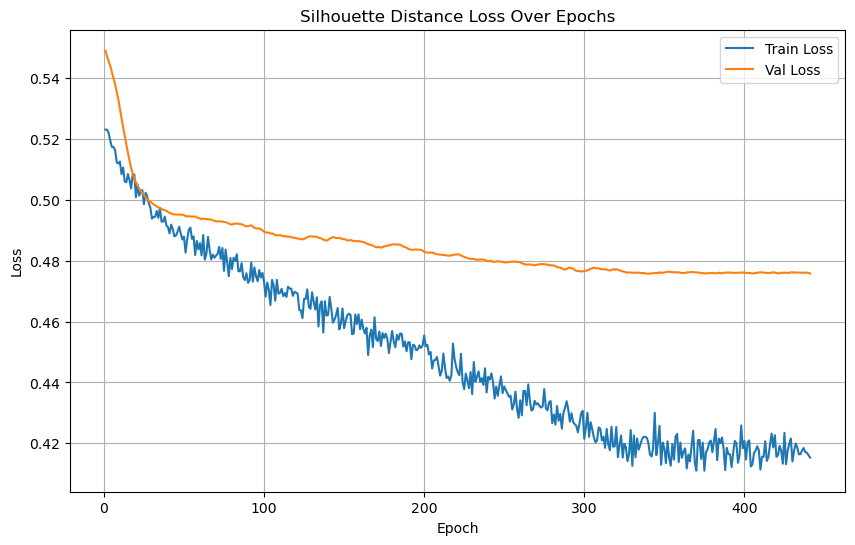

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/73], Loss: 0.2937


Test Batch [20/73], Loss: 0.1314
Test Batch [30/73], Loss: 0.3184
Test Batch [40/73], Loss: 0.5000
Test Batch [50/73], Loss: 0.4064
Test Batch [60/73], Loss: 0.3811
Test Batch [70/73], Loss: 0.3331



Test Loss: 0.3260


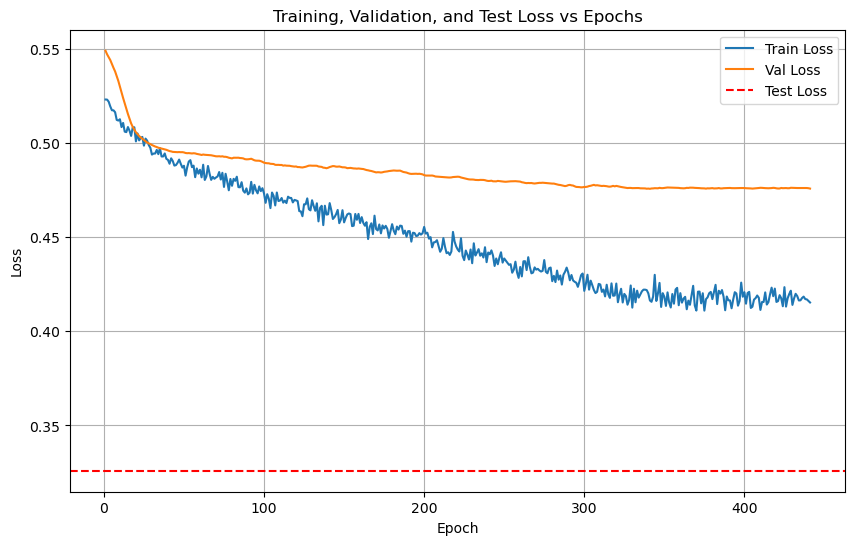

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/73 for test dataset.


  Processed batch 20/73 for test dataset.


  Processed batch 30/73 for test dataset.
  Processed batch 40/73 for test dataset.
  Processed batch 50/73 for test dataset.


  Processed batch 60/73 for test dataset.
  Processed batch 70/73 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 53.85%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.50      0.20      0.29         5
           2       0.14      0.20      0.17         5
           3       0.00      0.00      0.00         5
           4       0.50      0.40      0.44         5
           5       0.33      0.20      0.25         5
           6       0.67      0.80      0.73         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         5
          11       0.67      0.80      0.73         5
          12       0.80      0.80      0.80         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5895  |  Val Loss: 2.5328
Validation loss improved from inf to 2.5328.
[Epoch 2/1000] Train Loss: 2.5613  |  Val Loss: 2.5205
Validation loss improved from 2.5328 to 2.5205.
[Epoch 3/1000] Train Loss: 2.5372  |  Val Loss: 2.5094
Validation loss improved from 2.5205 to 2.5094.
[Epoch 4/1000] Train Loss: 2.5147  |  Val Loss: 2.4993
Validation loss improved from 2.5094 to 2.4993.
[Epoch 5/1000] Train Loss: 2.4941  |  Val Loss: 2.4894
Validation loss improved from 2.4993 to 2.4894.


[Epoch 6/1000] Train Loss: 2.4751  |  Val Loss: 2.4808
Validation loss improved from 2.4894 to 2.4808.
[Epoch 7/1000] Train Loss: 2.4552  |  Val Loss: 2.4710
Validation loss improved from 2.4808 to 2.4710.
[Epoch 8/1000] Train Loss: 2.4359  |  Val Loss: 2.4612
Validation loss improved from 2.4710 to 2.4612.
[Epoch 9/1000] Train Loss: 2.4166  |  Val Loss: 2.4515
Validation loss improved from 2.4612 to 2.4515.


[Epoch 10/1000] Train Loss: 2.3979  |  Val Loss: 2.4439
Validation loss improved from 2.4515 to 2.4439.


[Epoch 11/1000] Train Loss: 2.3789  |  Val Loss: 2.4351
Validation loss improved from 2.4439 to 2.4351.
[Epoch 12/1000] Train Loss: 2.3604  |  Val Loss: 2.4250
Validation loss improved from 2.4351 to 2.4250.
[Epoch 13/1000] Train Loss: 2.3419  |  Val Loss: 2.4141
Validation loss improved from 2.4250 to 2.4141.
[Epoch 14/1000] Train Loss: 2.3235  |  Val Loss: 2.4038
Validation loss improved from 2.4141 to 2.4038.
[Epoch 15/1000] Train Loss: 2.3068  |  Val Loss: 2.3930
Validation loss improved from 2.4038 to 2.3930.
[Epoch 16/1000] Train Loss: 2.2896  |  Val Loss: 2.3829
Validation loss improved from 2.3930 to 2.3829.
[Epoch 17/1000] Train Loss: 2.2738  |  Val Loss: 2.3733
Validation loss improved from 2.3829 to 2.3733.


[Epoch 18/1000] Train Loss: 2.2587  |  Val Loss: 2.3632
Validation loss improved from 2.3733 to 2.3632.
[Epoch 19/1000] Train Loss: 2.2432  |  Val Loss: 2.3534
Validation loss improved from 2.3632 to 2.3534.
[Epoch 20/1000] Train Loss: 2.2286  |  Val Loss: 2.3446
Validation loss improved from 2.3534 to 2.3446.
[Epoch 21/1000] Train Loss: 2.2141  |  Val Loss: 2.3340
Validation loss improved from 2.3446 to 2.3340.


[Epoch 22/1000] Train Loss: 2.1995  |  Val Loss: 2.3215
Validation loss improved from 2.3340 to 2.3215.
[Epoch 23/1000] Train Loss: 2.1841  |  Val Loss: 2.3098
Validation loss improved from 2.3215 to 2.3098.
[Epoch 24/1000] Train Loss: 2.1688  |  Val Loss: 2.2995
Validation loss improved from 2.3098 to 2.2995.
[Epoch 25/1000] Train Loss: 2.1536  |  Val Loss: 2.2907
Validation loss improved from 2.2995 to 2.2907.
[Epoch 26/1000] Train Loss: 2.1384  |  Val Loss: 2.2803
Validation loss improved from 2.2907 to 2.2803.
[Epoch 27/1000] Train Loss: 2.1230  |  Val Loss: 2.2709
Validation loss improved from 2.2803 to 2.2709.
[Epoch 28/1000] Train Loss: 2.1073  |  Val Loss: 2.2619
Validation loss improved from 2.2709 to 2.2619.
[Epoch 29/1000] Train Loss: 2.0917  |  Val Loss: 2.2529
Validation loss improved from 2.2619 to 2.2529.


[Epoch 30/1000] Train Loss: 2.0757  |  Val Loss: 2.2467
Validation loss improved from 2.2529 to 2.2467.
[Epoch 31/1000] Train Loss: 2.0605  |  Val Loss: 2.2404
Validation loss improved from 2.2467 to 2.2404.
[Epoch 32/1000] Train Loss: 2.0438  |  Val Loss: 2.2308
Validation loss improved from 2.2404 to 2.2308.
[Epoch 33/1000] Train Loss: 2.0273  |  Val Loss: 2.2204
Validation loss improved from 2.2308 to 2.2204.
[Epoch 34/1000] Train Loss: 2.0106  |  Val Loss: 2.2104
Validation loss improved from 2.2204 to 2.2104.
[Epoch 35/1000] Train Loss: 1.9933  |  Val Loss: 2.2005
Validation loss improved from 2.2104 to 2.2005.


[Epoch 36/1000] Train Loss: 1.9755  |  Val Loss: 2.1909
Validation loss improved from 2.2005 to 2.1909.
[Epoch 37/1000] Train Loss: 1.9582  |  Val Loss: 2.1822
Validation loss improved from 2.1909 to 2.1822.
[Epoch 38/1000] Train Loss: 1.9411  |  Val Loss: 2.1736
Validation loss improved from 2.1822 to 2.1736.
[Epoch 39/1000] Train Loss: 1.9243  |  Val Loss: 2.1637
Validation loss improved from 2.1736 to 2.1637.
[Epoch 40/1000] Train Loss: 1.9077  |  Val Loss: 2.1542
Validation loss improved from 2.1637 to 2.1542.
[Epoch 41/1000] Train Loss: 1.8909  |  Val Loss: 2.1452
Validation loss improved from 2.1542 to 2.1452.


[Epoch 42/1000] Train Loss: 1.8748  |  Val Loss: 2.1421
Validation loss improved from 2.1452 to 2.1421.
[Epoch 43/1000] Train Loss: 1.8592  |  Val Loss: 2.1339
Validation loss improved from 2.1421 to 2.1339.
[Epoch 44/1000] Train Loss: 1.8423  |  Val Loss: 2.1244
Validation loss improved from 2.1339 to 2.1244.
[Epoch 45/1000] Train Loss: 1.8261  |  Val Loss: 2.1148
Validation loss improved from 2.1244 to 2.1148.
[Epoch 46/1000] Train Loss: 1.8095  |  Val Loss: 2.1051
Validation loss improved from 2.1148 to 2.1051.
[Epoch 47/1000] Train Loss: 1.7934  |  Val Loss: 2.0967
Validation loss improved from 2.1051 to 2.0967.


[Epoch 48/1000] Train Loss: 1.7780  |  Val Loss: 2.0893
Validation loss improved from 2.0967 to 2.0893.
[Epoch 49/1000] Train Loss: 1.7616  |  Val Loss: 2.0807
Validation loss improved from 2.0893 to 2.0807.
[Epoch 50/1000] Train Loss: 1.7456  |  Val Loss: 2.0716
Validation loss improved from 2.0807 to 2.0716.
[Epoch 51/1000] Train Loss: 1.7306  |  Val Loss: 2.0625
Validation loss improved from 2.0716 to 2.0625.
[Epoch 52/1000] Train Loss: 1.7142  |  Val Loss: 2.0555
Validation loss improved from 2.0625 to 2.0555.
[Epoch 53/1000] Train Loss: 1.6987  |  Val Loss: 2.0482
Validation loss improved from 2.0555 to 2.0482.


[Epoch 54/1000] Train Loss: 1.6825  |  Val Loss: 2.0425
Validation loss improved from 2.0482 to 2.0425.
[Epoch 55/1000] Train Loss: 1.6664  |  Val Loss: 2.0347
Validation loss improved from 2.0425 to 2.0347.
[Epoch 56/1000] Train Loss: 1.6507  |  Val Loss: 2.0288
Validation loss improved from 2.0347 to 2.0288.
[Epoch 57/1000] Train Loss: 1.6343  |  Val Loss: 2.0217
Validation loss improved from 2.0288 to 2.0217.
[Epoch 58/1000] Train Loss: 1.6176  |  Val Loss: 2.0150
Validation loss improved from 2.0217 to 2.0150.
[Epoch 59/1000] Train Loss: 1.6011  |  Val Loss: 2.0098
Validation loss improved from 2.0150 to 2.0098.
[Epoch 60/1000] Train Loss: 1.5843  |  Val Loss: 2.0010
Validation loss improved from 2.0098 to 2.0010.


[Epoch 61/1000] Train Loss: 1.5679  |  Val Loss: 1.9959
Validation loss improved from 2.0010 to 1.9959.
[Epoch 62/1000] Train Loss: 1.5510  |  Val Loss: 1.9924
Validation loss improved from 1.9959 to 1.9924.
[Epoch 63/1000] Train Loss: 1.5346  |  Val Loss: 1.9887
Validation loss improved from 1.9924 to 1.9887.
[Epoch 64/1000] Train Loss: 1.5181  |  Val Loss: 1.9885
Validation loss improved from 1.9887 to 1.9885.
[Epoch 65/1000] Train Loss: 1.5019  |  Val Loss: 1.9828
Validation loss improved from 1.9885 to 1.9828.


[Epoch 66/1000] Train Loss: 1.4862  |  Val Loss: 1.9787
Validation loss improved from 1.9828 to 1.9787.
[Epoch 67/1000] Train Loss: 1.4697  |  Val Loss: 1.9814
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 1.4525  |  Val Loss: 1.9782
Validation loss improved from 1.9787 to 1.9782.
[Epoch 69/1000] Train Loss: 1.4362  |  Val Loss: 1.9726
Validation loss improved from 1.9782 to 1.9726.
[Epoch 70/1000] Train Loss: 1.4197  |  Val Loss: 1.9666
Validation loss improved from 1.9726 to 1.9666.
[Epoch 71/1000] Train Loss: 1.4035  |  Val Loss: 1.9593
Validation loss improved from 1.9666 to 1.9593.


[Epoch 72/1000] Train Loss: 1.3873  |  Val Loss: 1.9615
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 1.3704  |  Val Loss: 1.9624
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 1.3542  |  Val Loss: 1.9628
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 1.3380  |  Val Loss: 1.9618
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 1.3215  |  Val Loss: 1.9514
Validation loss improved from 1.9593 to 1.9514.
[Epoch 77/1000] Train Loss: 1.3049  |  Val Loss: 1.9490
Validation loss improved from 1.9514 to 1.9490.


[Epoch 78/1000] Train Loss: 1.2896  |  Val Loss: 1.9460
Validation loss improved from 1.9490 to 1.9460.
[Epoch 79/1000] Train Loss: 1.2735  |  Val Loss: 1.9438
Validation loss improved from 1.9460 to 1.9438.
[Epoch 80/1000] Train Loss: 1.2571  |  Val Loss: 1.9385
Validation loss improved from 1.9438 to 1.9385.
[Epoch 81/1000] Train Loss: 1.2413  |  Val Loss: 1.9394
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 1.2251  |  Val Loss: 1.9456
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 83/1000] Train Loss: 1.2085  |  Val Loss: 1.9412
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 84/1000] Train Loss: 1.1926  |  Val Loss: 1.9358
Validation loss improved from 1.9385 to 1.9358.
[Epoch 85/1000] Train Loss: 1.1774  |  Val Loss: 1.9326
Validation loss improved from 1.9358 to 1.9326.
[Epoch 86/1000] Train Loss: 1.1629  |  Val Loss: 1.9450
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 87/1000] Train Loss: 1.1469  |  Val Loss: 1.9514
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 88/1000] Train Loss: 1.1325  |  Val Loss: 1.9602
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 89/1000] Train Loss: 1.1182  |  Val Loss: 1.9596
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 90/1000] Train Loss: 1.1024  |  Val Loss: 1.9617
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 91/1000] Train Loss: 1.0872  |  Val Loss: 1.9580
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 92/1000] Train Loss: 1.0741  |  Val Loss: 1.9688
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 93/1000] Train Loss: 1.0596  |  Val Loss: 2.0024
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 94/1000] Train Loss: 1.0479  |  Val Loss: 2.0079
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 95/1000] Train Loss: 1.0348  |  Val Loss: 2.0011
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 96/1000] Train Loss: 1.0213  |  Val Loss: 1.9804
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 97/1000] Train Loss: 1.0087  |  Val Loss: 1.9807
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 98/1000] Train Loss: 0.9961  |  Val Loss: 1.9840
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 99/1000] Train Loss: 0.9840  |  Val Loss: 1.9888
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 100/1000] Train Loss: 0.9713  |  Val Loss: 2.0160
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 101/1000] Train Loss: 0.9598  |  Val Loss: 2.0368
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 102/1000] Train Loss: 0.9489  |  Val Loss: 2.0355
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 103/1000] Train Loss: 0.9379  |  Val Loss: 2.0609
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 104/1000] Train Loss: 0.9272  |  Val Loss: 2.0762
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 105/1000] Train Loss: 0.9171  |  Val Loss: 2.0795
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 106/1000] Train Loss: 0.9065  |  Val Loss: 2.0840
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 107/1000] Train Loss: 0.8964  |  Val Loss: 2.1001
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 108/1000] Train Loss: 0.8866  |  Val Loss: 2.1112
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 109/1000] Train Loss: 0.8766  |  Val Loss: 2.1282
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 110/1000] Train Loss: 0.8672  |  Val Loss: 2.1300
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 111/1000] Train Loss: 0.8583  |  Val Loss: 2.1406
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 112/1000] Train Loss: 0.8494  |  Val Loss: 2.1452
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 113/1000] Train Loss: 0.8407  |  Val Loss: 2.1618
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 114/1000] Train Loss: 0.8321  |  Val Loss: 2.1908
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 115/1000] Train Loss: 0.8237  |  Val Loss: 2.2040
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 116/1000] Train Loss: 0.8160  |  Val Loss: 2.2099
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 117/1000] Train Loss: 0.8079  |  Val Loss: 2.2483
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 118/1000] Train Loss: 0.8006  |  Val Loss: 2.2800
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 119/1000] Train Loss: 0.7933  |  Val Loss: 2.2737
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 120/1000] Train Loss: 0.7855  |  Val Loss: 2.2837
!! Validation loss did NOT improve !! Patience: 35/100


[Epoch 121/1000] Train Loss: 0.7782  |  Val Loss: 2.3055
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 122/1000] Train Loss: 0.7716  |  Val Loss: 2.3200
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 123/1000] Train Loss: 0.7643  |  Val Loss: 2.3226
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 124/1000] Train Loss: 0.7579  |  Val Loss: 2.3608
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 125/1000] Train Loss: 0.7509  |  Val Loss: 2.3615
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 126/1000] Train Loss: 0.7442  |  Val Loss: 2.3723
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 127/1000] Train Loss: 0.7382  |  Val Loss: 2.3845
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 128/1000] Train Loss: 0.7320  |  Val Loss: 2.3970
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 129/1000] Train Loss: 0.7259  |  Val Loss: 2.3988
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 130/1000] Train Loss: 0.7202  |  Val Loss: 2.4261
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 131/1000] Train Loss: 0.7146  |  Val Loss: 2.4640
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 132/1000] Train Loss: 0.7095  |  Val Loss: 2.4666
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 133/1000] Train Loss: 0.7043  |  Val Loss: 2.4636
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 134/1000] Train Loss: 0.6991  |  Val Loss: 2.4327
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 135/1000] Train Loss: 0.6948  |  Val Loss: 2.4383
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 136/1000] Train Loss: 0.6892  |  Val Loss: 2.4777
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 137/1000] Train Loss: 0.6847  |  Val Loss: 2.5440
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 138/1000] Train Loss: 0.6803  |  Val Loss: 2.5984
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 139/1000] Train Loss: 0.6745  |  Val Loss: 2.6108
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 140/1000] Train Loss: 0.6692  |  Val Loss: 2.6095
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 141/1000] Train Loss: 0.6651  |  Val Loss: 2.6333
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 142/1000] Train Loss: 0.6606  |  Val Loss: 2.6629
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 143/1000] Train Loss: 0.6572  |  Val Loss: 2.5988
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 144/1000] Train Loss: 0.6529  |  Val Loss: 2.6153
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 145/1000] Train Loss: 0.6477  |  Val Loss: 2.6501
!! Validation loss did NOT improve !! Patience: 60/100


[Epoch 146/1000] Train Loss: 0.6427  |  Val Loss: 2.7149
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 147/1000] Train Loss: 0.6391  |  Val Loss: 2.7735
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 148/1000] Train Loss: 0.6350  |  Val Loss: 2.7895
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 149/1000] Train Loss: 0.6311  |  Val Loss: 2.7755
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 150/1000] Train Loss: 0.6275  |  Val Loss: 2.8126
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 151/1000] Train Loss: 0.6239  |  Val Loss: 2.8435
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 152/1000] Train Loss: 0.6204  |  Val Loss: 2.8677
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 153/1000] Train Loss: 0.6166  |  Val Loss: 2.8686
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 154/1000] Train Loss: 0.6132  |  Val Loss: 2.8788
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 155/1000] Train Loss: 0.6098  |  Val Loss: 2.9204
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 156/1000] Train Loss: 0.6063  |  Val Loss: 2.9386
!! Validation loss did NOT improve !! Patience: 71/100


[Epoch 157/1000] Train Loss: 0.6035  |  Val Loss: 2.9706
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 158/1000] Train Loss: 0.6000  |  Val Loss: 3.0049
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 159/1000] Train Loss: 0.5968  |  Val Loss: 2.9972
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 160/1000] Train Loss: 0.5935  |  Val Loss: 2.9946
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 161/1000] Train Loss: 0.5907  |  Val Loss: 2.9963
!! Validation loss did NOT improve !! Patience: 76/100


[Epoch 162/1000] Train Loss: 0.5874  |  Val Loss: 3.0604
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 163/1000] Train Loss: 0.5857  |  Val Loss: 3.1009
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 164/1000] Train Loss: 0.5827  |  Val Loss: 3.1546
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 165/1000] Train Loss: 0.5797  |  Val Loss: 3.1397
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 166/1000] Train Loss: 0.5761  |  Val Loss: 3.1971
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 167/1000] Train Loss: 0.5736  |  Val Loss: 3.2364
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 168/1000] Train Loss: 0.5717  |  Val Loss: 3.2562
!! Validation loss did NOT improve !! Patience: 83/100


[Epoch 169/1000] Train Loss: 0.5682  |  Val Loss: 3.2463
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 170/1000] Train Loss: 0.5661  |  Val Loss: 3.2507
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 171/1000] Train Loss: 0.5635  |  Val Loss: 3.2406
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 172/1000] Train Loss: 0.5613  |  Val Loss: 3.2331
!! Validation loss did NOT improve !! Patience: 87/100


[Epoch 173/1000] Train Loss: 0.5577  |  Val Loss: 3.2364
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 174/1000] Train Loss: 0.5550  |  Val Loss: 3.2848
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 175/1000] Train Loss: 0.5522  |  Val Loss: 3.3862
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 176/1000] Train Loss: 0.5505  |  Val Loss: 3.4195
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 177/1000] Train Loss: 0.5480  |  Val Loss: 3.4180
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 178/1000] Train Loss: 0.5458  |  Val Loss: 3.4193
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 179/1000] Train Loss: 0.5429  |  Val Loss: 3.4466
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 180/1000] Train Loss: 0.5409  |  Val Loss: 3.4443
!! Validation loss did NOT improve !! Patience: 95/100


[Epoch 181/1000] Train Loss: 0.5393  |  Val Loss: 3.4457
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 182/1000] Train Loss: 0.5366  |  Val Loss: 3.4592
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 183/1000] Train Loss: 0.5341  |  Val Loss: 3.4524
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 184/1000] Train Loss: 0.5318  |  Val Loss: 3.4737
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 185/1000] Train Loss: 0.5295  |  Val Loss: 3.4910
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 185 !!
No improvement for 100 epochs.


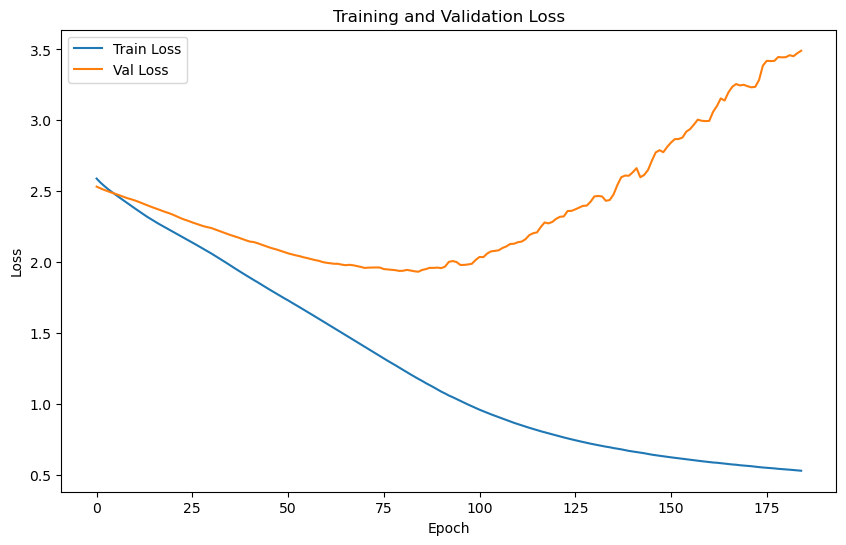

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 4.5752 | Test Accuracy: 62.80%


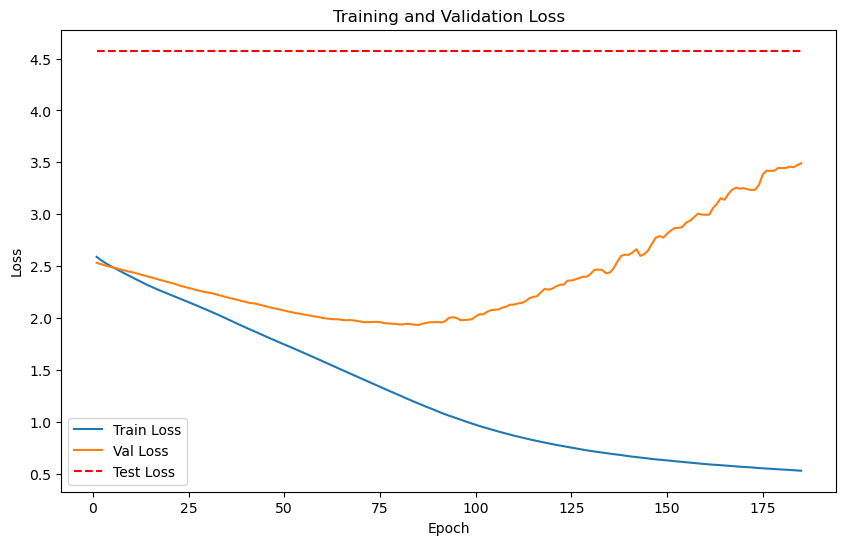

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


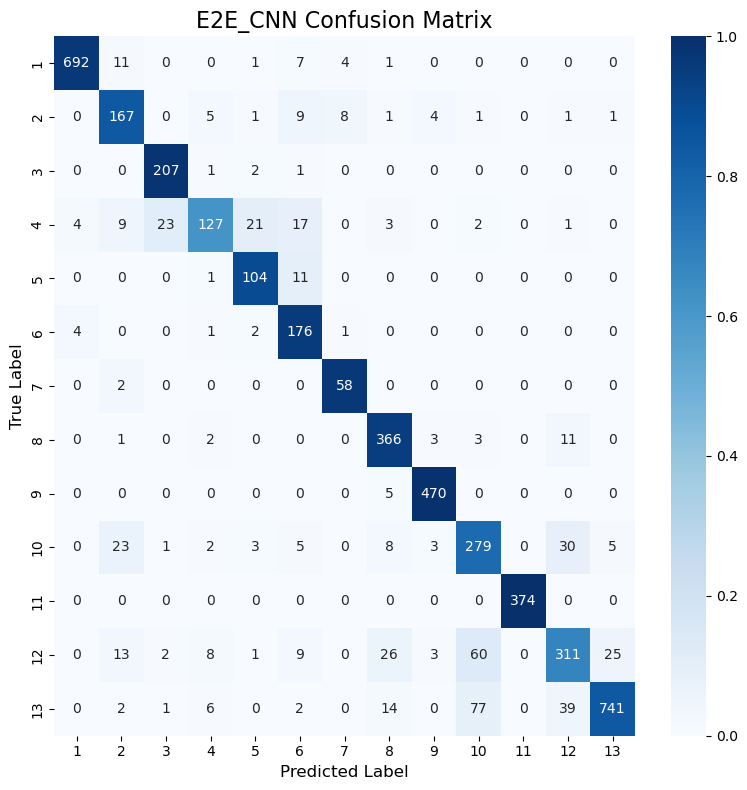

Classification Accuracy: 88.02%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


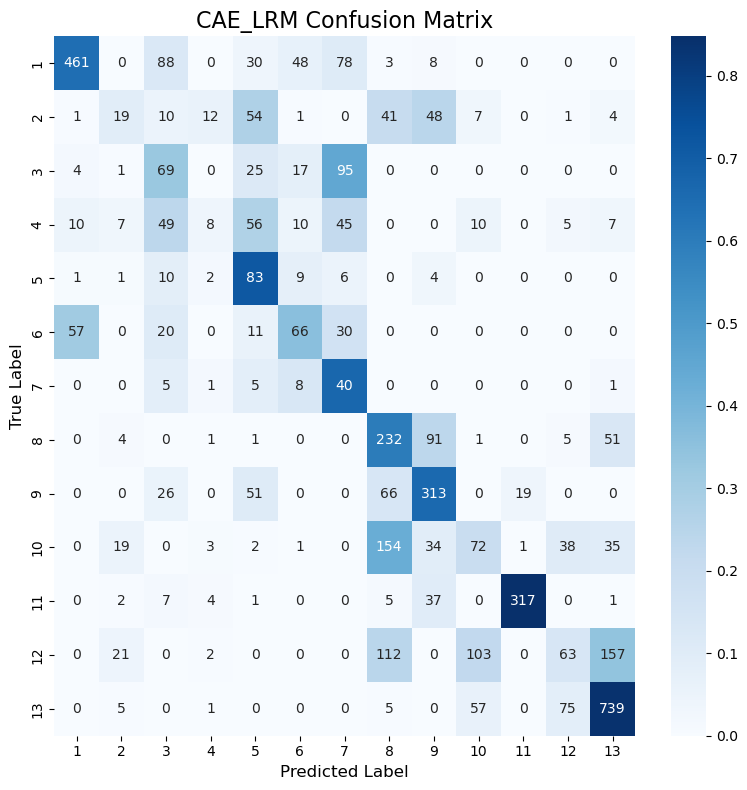

Classification Accuracy: 53.65%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


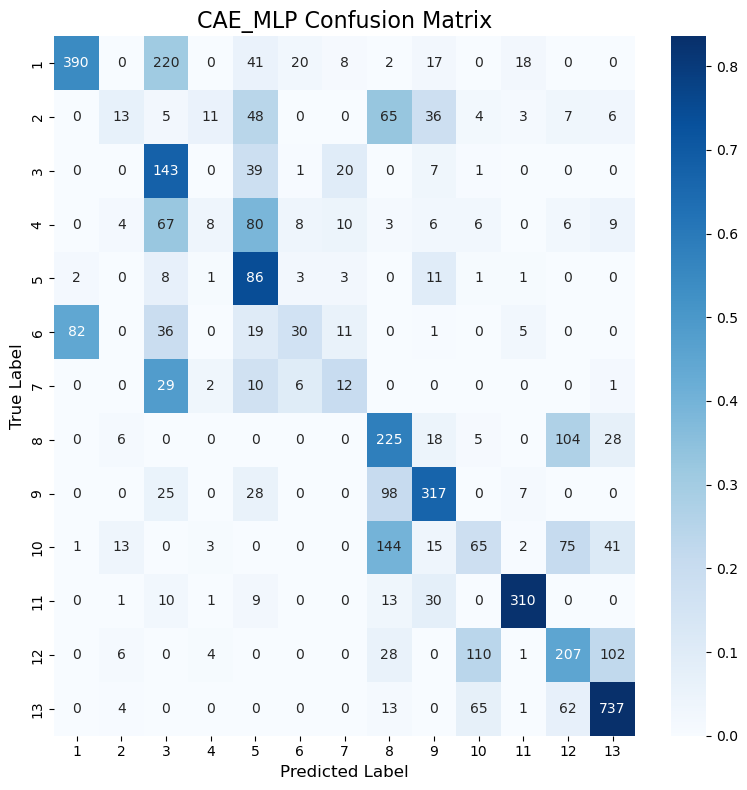

Classification Accuracy: 54.97%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


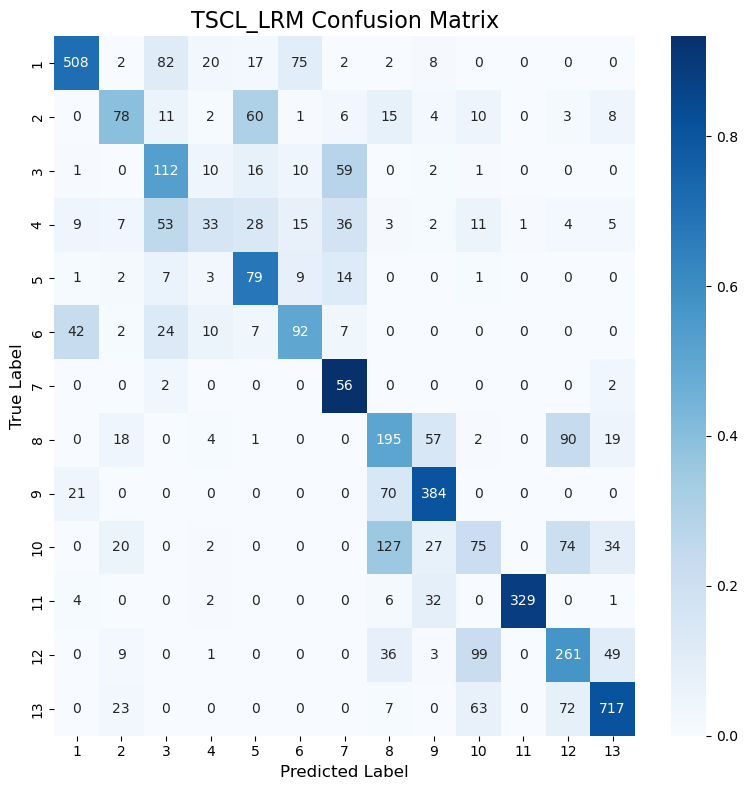

Classification Accuracy: 63.10%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


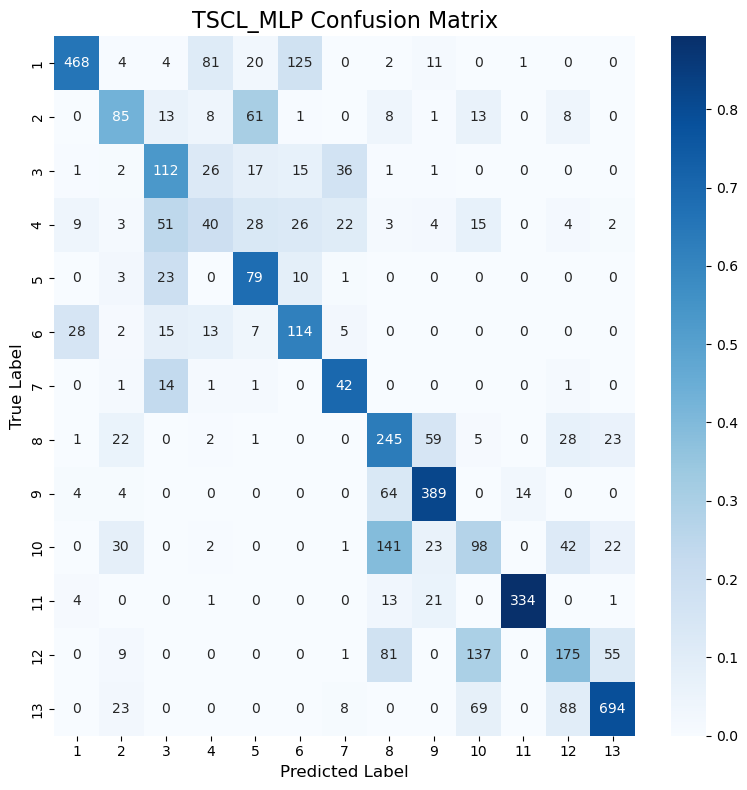

Classification Accuracy: 62.15%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


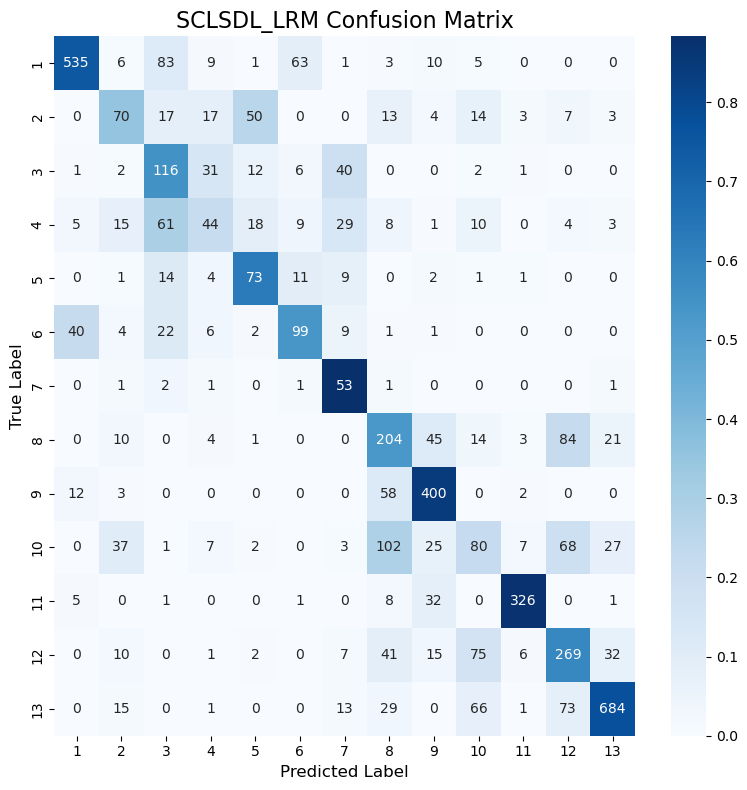

Classification Accuracy: 63.83%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


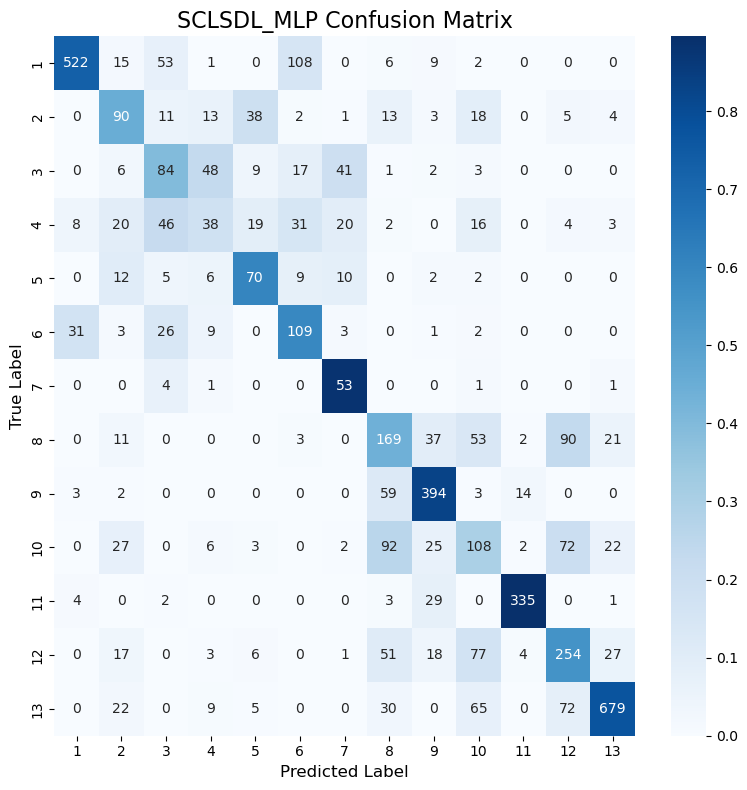

Classification Accuracy: 62.80%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          88.02
1    LRM (CAE)          53.65
2    MLP (CAE)          54.97
3     TSCL LRM          63.10
4     TSCL MLP          62.15
5  SCL_SDL LRM          63.83
6  SCL_SDL MLP          62.80

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          88.02
5  SCL_SDL LRM          63.83
3     TSCL LRM          63.10
6  SCL_SDL MLP          62.80
4     TSCL MLP          62.15
2    MLP (CAE)          54.97
1    LRM (CAE)          53.65
